In [11]:
# standard loads
import numpy as np #type:ignore
import matplotlib.pyplot as plt #type:ignore
from matplotlib.colors import ListedColormap #type:ignore
import pandas as pd #type:ignore
import os
import glob
import json
import h5py #type:ignore
from skimage import morphology #type:ignore
from skimage.morphology import skeletonize #type:ignore
from skimage.morphology import dilation, disk # type: ignore
from scipy import ndimage


# import specific algorithm functions
from input_formatting import input_formatting # * imports all functions from the referenced .py file
from Strahler_Correction_class import CreekNetworkAnalyzer
from Creek_Repair import process_creek_mask, save_creek_mask_h5, load_creek_mask_h5, process_creek_mask_diagnostic
from check_plots_step5 import plot_creek_orders, plot_creek_orders_big
from Process_CrossSections import process_xsects
from Process_JunctionAngles import process_junction_angles

%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

### input_formatting

In [12]:
# input_formatting
# formats elevation and slope raster ascii files in to .h5
# requires user manual input for filename of elevation and slope

# check if OUTPUTS folder is created - if not, create one
folder_path_check = "OUTPUTS"

# Check if the folder exists
if not os.path.exists(folder_path_check):
    # Create the folder
    os.makedirs(folder_path_check)
    print(f"Folder '{folder_path_check}' created.")
else:
    print(f"Folder '{folder_path_check}' already exists.")

print('Elevation Files:')
# Change file names for specific site - i.e., filename = 'INPUTS/blahblah_elev.txt' or 'INPUTS/blahblah_slope.txt'
filename_elev = 'INPUTS/av_DEM_converted_m_fillNoData.asc' # user input
filename_out_elev, filename_out_meta_elev = input_formatting(filename_elev)
print('File was saved as: ', filename_out_elev)
print('Metadata file was saved as: ', filename_out_meta_elev)

print('')

print('Slope Files:')
filename_slope = 'INPUTS/av_slope_degrees_fillNoData.asc' # user input
filename_out_slope, filename_out_meta_slope = input_formatting(filename_slope)
print('File was saved as: ', filename_out_slope)
print('Metadata file was saved as: ', filename_out_meta_slope)

Folder 'OUTPUTS' already exists.
Elevation Files:
ncols: 392.0
nrows: 401.0
x corner: 704509.4
y corner: 107140.8
cell size: 1.0
NoData value: -340282346638528859811704183484516925440.0
File was saved as:  INPUTS/av_DEM_converted_m_fillNoData.h5
Metadata file was saved as:  INPUTS/av_DEM_converted_m_fillNoData_metadata.h5

Slope Files:
ncols: 392.0
nrows: 401.0
x corner: 704509.4
y corner: 107140.8
cell size: 1.0
NoData value: -9999.0
File was saved as:  INPUTS/av_slope_degrees_fillNoData.h5
Metadata file was saved as:  INPUTS/av_slope_degrees_fillNoData_metadata.h5


### CHIROL_CREEK_ALGORITHM

In [13]:
# Section 1 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/13
import time

# import specific algorithm functions
from readvardef import readvardef

start_time = time.time()

# 1) User to select input variables
figview = 0  # Change to 1 to see additional figures

# Open User Variables instruction file
filename_UserVar = '/Users/sam/RDE Dropbox/Projects/22386.Ashleyville Marsh/WORK/CODE/Python/CHIROL_CREEK_EXTRACTION_ALGORITHM/INPUTS/UserVar_av.txt' # manual input, as opposed to MATLAB script's GUI selection
result = readvardef(filename_UserVar)
if result is None:
    print("User aborted or error occurred.")
    exit()

FILENAMES, PROCESSING, TIDE, THRESHOLDS, RECONNECTION = result

# Unpack data from global variables
name = FILENAMES["name"]
shortname = FILENAMES["shortname"]
elev = FILENAMES["elev"]
elevmeta = FILENAMES["elevmeta"]
slope = FILENAMES["slope"]
slopemeta = FILENAMES["slopemeta"]

resamplestep = PROCESSING["resamplestep"]
threshold = PROCESSING["threshold"]
detrendyn = PROCESSING["detrendyn"]
outletdetection = PROCESSING["outletdetection"]

HAT = TIDE["HAT"]
MHWS = TIDE["MHWS"]
MHWN = TIDE["MHWN"]
MLWS = TIDE["MLWS"]
MLWN = TIDE["MLWN"]

Cth = THRESHOLDS["Cth"]
Ctharea = THRESHOLDS["Ctharea"]
LZth = THRESHOLDS["LZth"]
LZtharea = THRESHOLDS["LZtharea"]
HZth = THRESHOLDS["HZth"]
HZtharea = THRESHOLDS["HZtharea"]

nbbreaches = RECONNECTION["nbbreaches"]
noisethreshold = RECONNECTION["noisethreshold"]
reconnect = RECONNECTION["reconnect"]
reconnectiondist = RECONNECTION["reconnectiondist"]
ordermax = RECONNECTION["ordermax"]
filtersmall1 = RECONNECTION["filtersmall1"]
filterlarge1 = RECONNECTION["filterlarge1"]
smoothing = RECONNECTION["smoothing"]
connectivity = RECONNECTION["connectivity"]
holesizeinfill = RECONNECTION["holesizeinfill"]
filtersmall2 = RECONNECTION["filtersmall2"]
filterlarge2 = RECONNECTION["filterlarge2"]

#  Print out the values to verify they were read correctly
# print("Loaded variables:")
# for category in [FILENAMES, PROCESSING, TIDE, THRESHOLDS, RECONNECTION]:
#     for key, value in category.items():
#         print(f"{key}: {value}")

end_time = time.time()
# print(f"Execution time: {end_time - start_time} seconds")

In [14]:
# Section 2 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/15

# import specific algorithm functions
from Loadlidarmaps import Loadlidarmaps
from RemoveaboveHAT import RemoveaboveHAT

# Load the data
Xs, Ys, Zs, X, Y, Z, gs, xc, yc = Loadlidarmaps(elev, elevmeta, slope, slopemeta)

# Remove values above HAT
Z, Zs, meandepth, meanslope = RemoveaboveHAT(Z, Zs, HAT, detrendyn)

# Print some information about the loaded and processed data
print(f"Data loaded and processed:")
print(f"X range: {np.min(X)} to {np.max(X)} meters")
print(f"Y range: {np.min(Y)} to {np.max(Y)} meters")
print(f"Z range: {np.nanmin(Z)} to {np.nanmax(Z)} meters")
print(f"Mean depth: {meandepth} meters")
print(f"Mean slope: {meanslope} degrees")
print(f"Grid size: {gs} meters")

# Subsample the dataset to make mapping quicker
# X2 = X[::resamplestep, ::resamplestep]
# Y2 = Y[::resamplestep, ::resamplestep]
X2 = X[::resamplestep] # was 2D in MATLAB, I guess not 2D in Python?
Y2 = Y[::resamplestep] # was 2D in MATLAB, I guess not 2D in Python?
Z2 = Z[::resamplestep, ::resamplestep]

print(f"Subsampled data shape: {Z2.shape}")

Data loaded and processed:
X range: 704509.386 to 704900.386 meters
Y range: 107140.822 to 107540.822 meters
Z range: -1.013437032699585 to 2.2827565670013428 meters
Mean depth: 0.4961816064174111 meters
Mean slope: 2.4339671037132393 degrees
Grid size: 1.0 meters
Subsampled data shape: (196, 201)


In [15]:
# Section 3 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/15 and 2024/10/10

# Your variables
variables_detection = {
    "threshold": threshold,
    "Zs": Zs.tolist(),   # Convert arrays to lists to make them JSON serializable
    "Z": Z.tolist(),
    "gs": gs,
    "X": X,
    "Y": Y,
    "X2": X2,
    "Y2": Y2,
    "Z2": Z2,
    "LZtharea": LZtharea,
    "LZth": LZth,
    "HZtharea": HZtharea,
    "HZth": HZth,
    "Ctharea": Ctharea,
    "Cth": Cth
}

# Convert all numpy arrays to lists
variables_detection = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in variables_detection.items()}

# Save to a JSON file
with open("variables_Creek_Detection.json", "w") as f:
    json.dump(variables_detection, f)

# After running this cell, you need to run in terminal, following these steps: <br>
# 1) If you're on macOS or Linux, make sure that Tkinter (which matplotlib uses for plotting) is properly installed. 
#     On macOS, you can install it via Homebrew using: <br>
#     ```brew install python-tk```
#     NOTE: Homebrew is a package manager for macOS (and Linux)
#       that simplifies the process of installing, updating, and managing software and tools on your system.
# 2) Open terminal (Command Prompt in Windows)
# 3) Change current directory to folder containing creek extraction .py files - the "~" is to reference your user local folder
#     (spaces in filepath need to be preceded by a single backslash \ to not break up continuous filepath): <br>
#      ```cd ~/RDE\ Dropbox/Projects/22386.Ashleyville\ Marsh/WORK/CODE/Python/CHIROL_CREEK_EXTRACTION_ALGORITHM```
# 4) Run .py file:  <br>
#     ```python Creek_Detection.py```
# 5) Plots should appear in python GUI windows - you can adjust plot positioning in this window, and save the figures. 
#       If the threshold value is 1, you will be prompted to click GUI plots of slope and hypsometry.
# 6) As instructed in terminal print statement, press Enter (return) key to close plots.

In [16]:
# Load the Step 3 processed variables from the JSON file
with open("processed_variables_Creek_Detection.json", "r") as f:
    variables = json.load(f)

creek = variables["creek"]
CumArea = variables["CumArea"]
binrange = variables["binrange"]
CumAreas = variables["CumAreas"]
binranges = variables["binranges"]

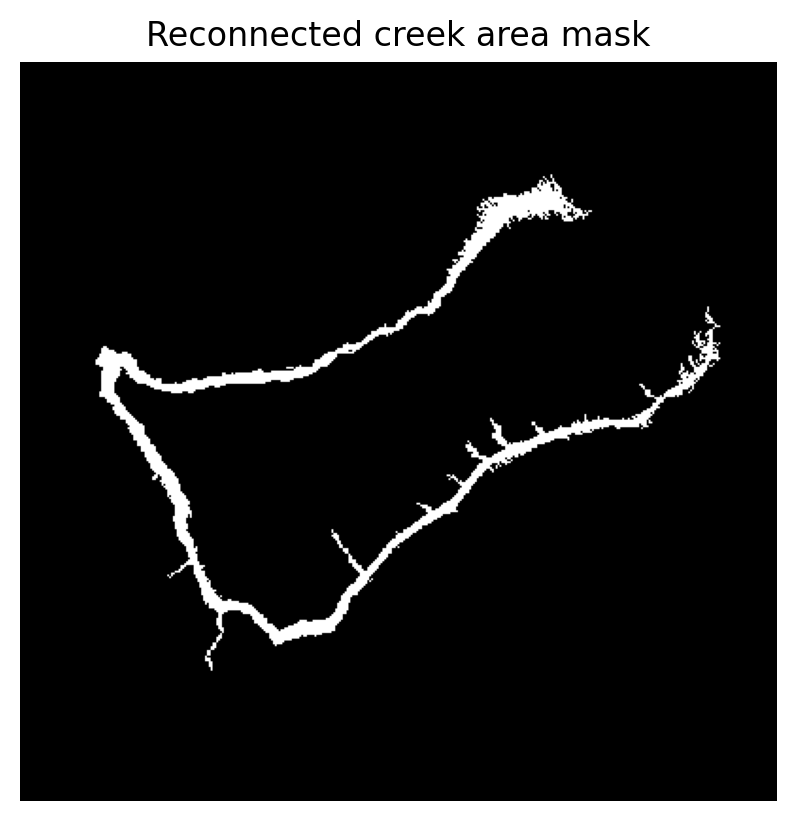

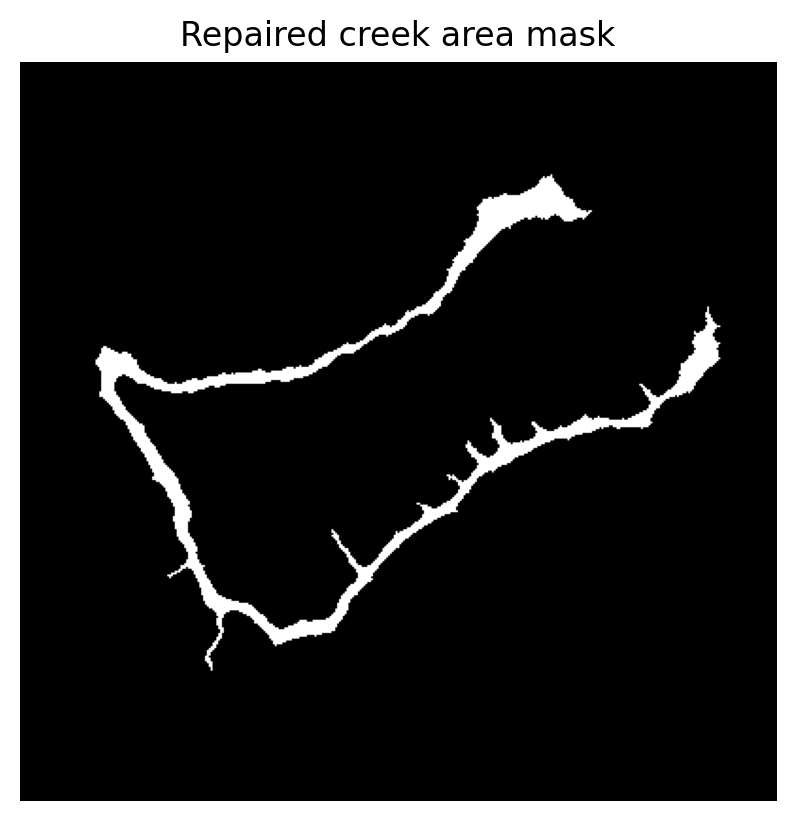

In [17]:
# Section 4 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/10/14

# import specific algorithm functions
from Creek_Repair import process_creek_mask, save_creek_mask_h5, load_creek_mask_h5, process_creek_mask_diagnostic

# load raw creek mask from Step 3
with h5py.File('creekmask_raw.h5', 'r') as hf:
    creekmask_raw = hf['creekmask_raw'][:]
    
# execute functions in Creek_Repair.py and process_creek_mask function
creekmask = process_creek_mask(creekmask_raw, reconnect, noisethreshold, reconnectiondist, connectivity,
                                    filtersmall1, filterlarge1, smoothing, filtersmall2, filterlarge2, holesizeinfill)
# ^the process_creek_mask function inputs differ from the .py file due to use of underscores in .py as opposed to no underscores in .ipynb
save_creek_mask_h5(creekmask, 'creekmask.h5')

# for troubleshooting issues in oversmoothing and filling operations, run diagnostic function with helpful print statements and plots:
# repaired_mask = process_creek_mask_diagnostic(creekmask_raw, reconnect, noisethreshold, reconnectiondist, connectivity,
#                                     filtersmall1, filterlarge1, smoothing, filtersmall2, filterlarge2, holesizeinfill)

Starting while loop 1:
while 1/4, Iteration 1: 24 endpoints remaining
order i =  1
col =  0
k =  0
E location y, x =  (61, 281)


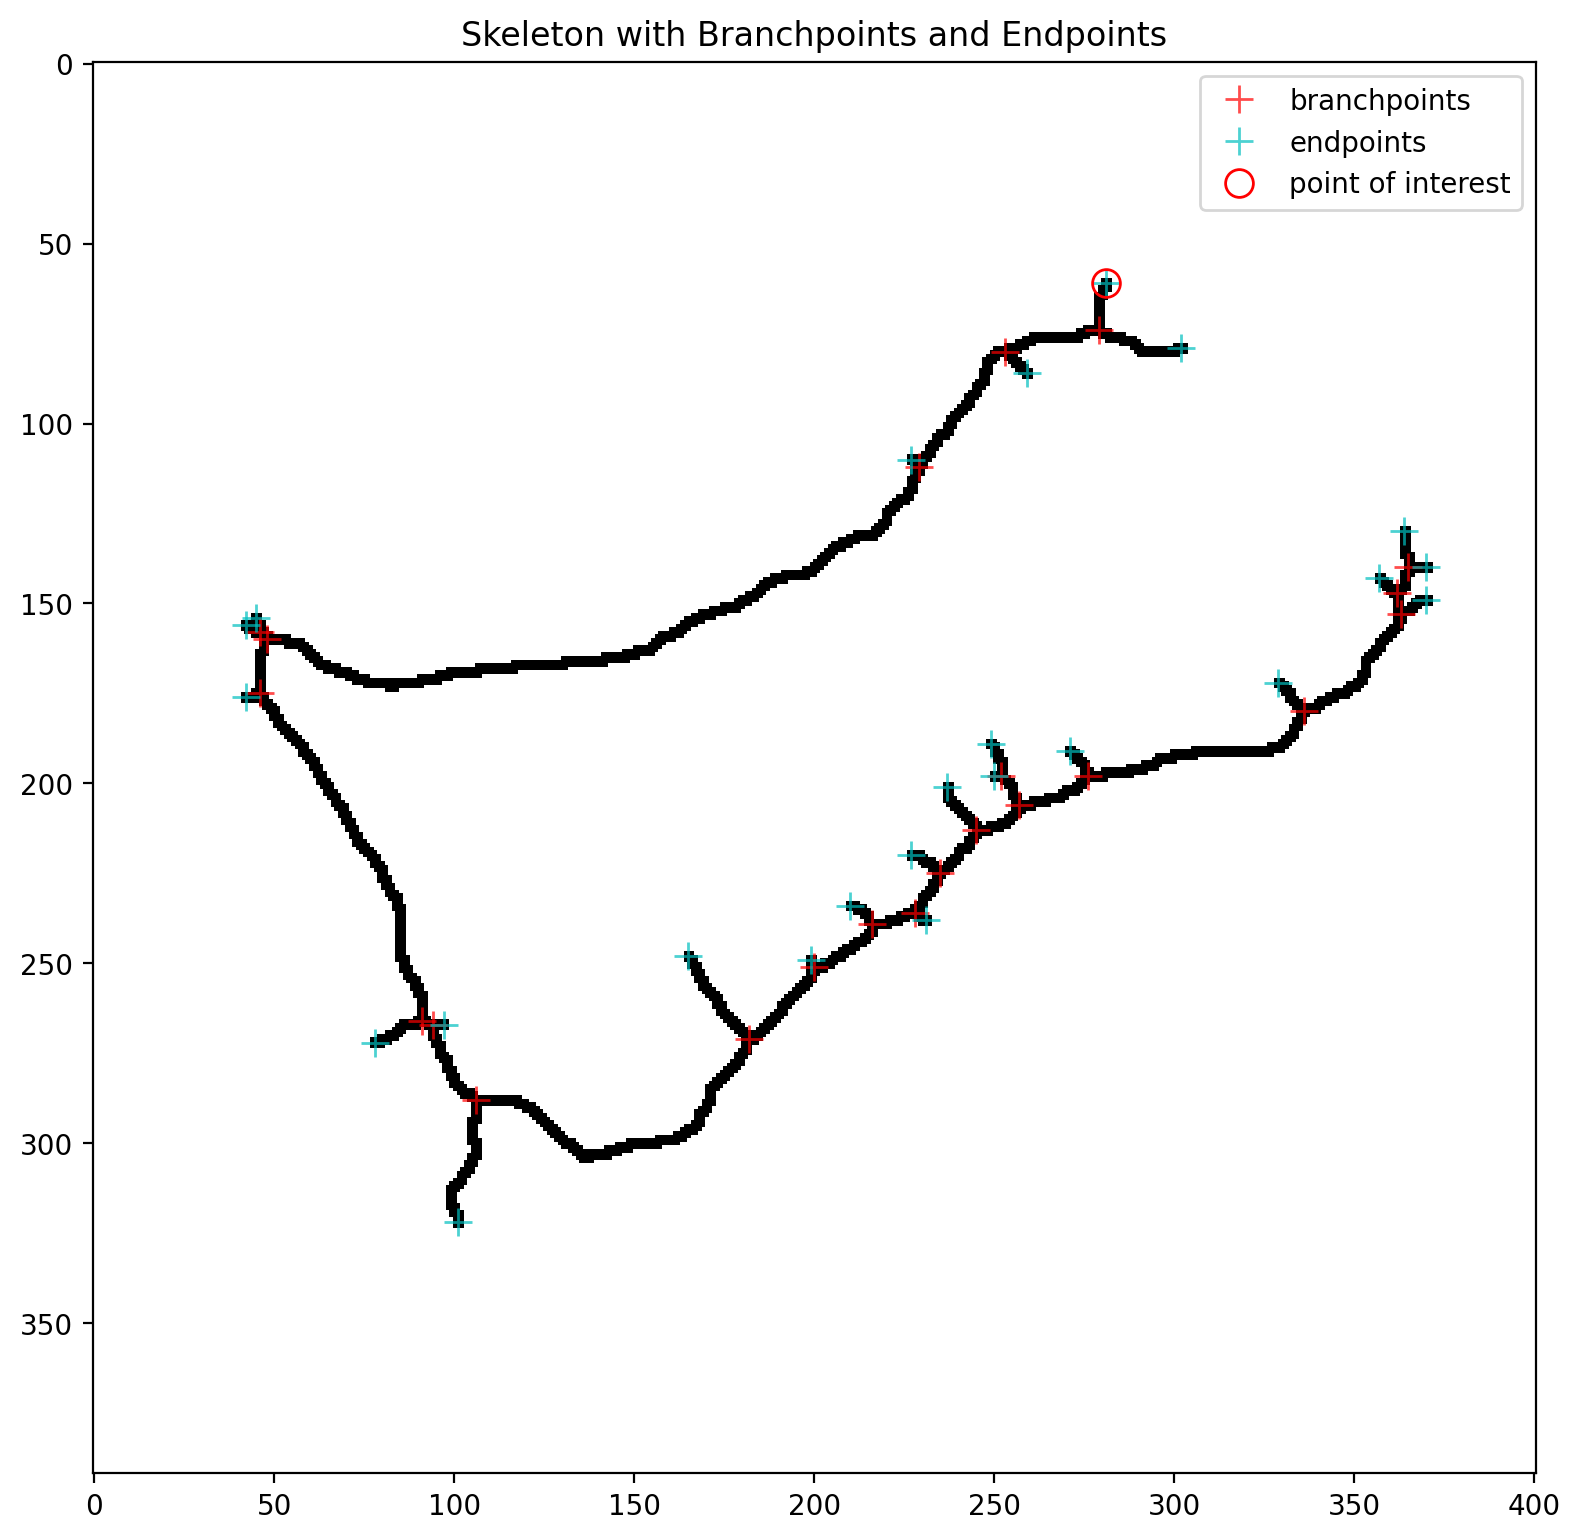

col =  6
k =  1
E location y, x =  (79, 302)


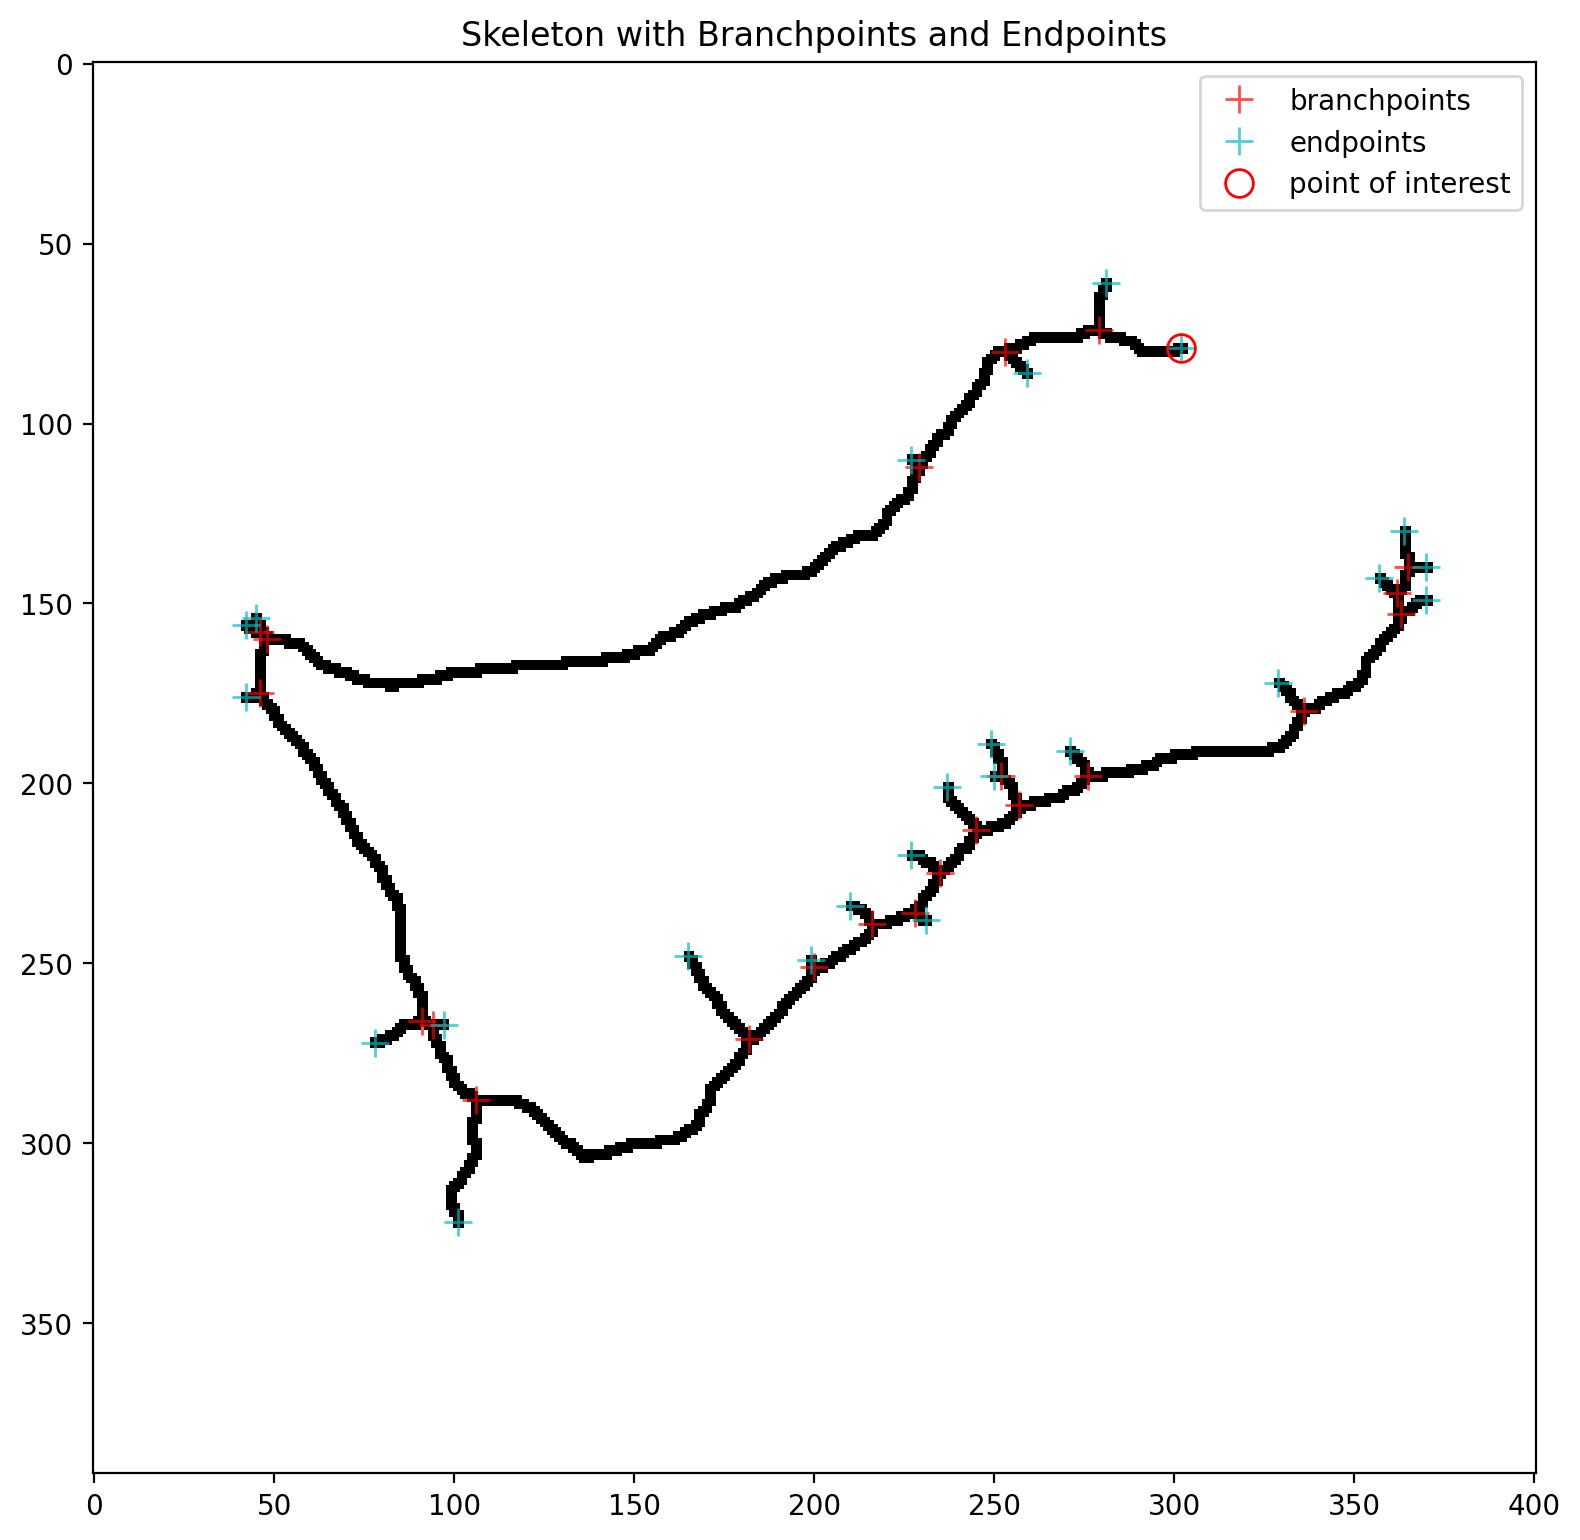

col =  12
k =  2
E location y, x =  (86, 259)


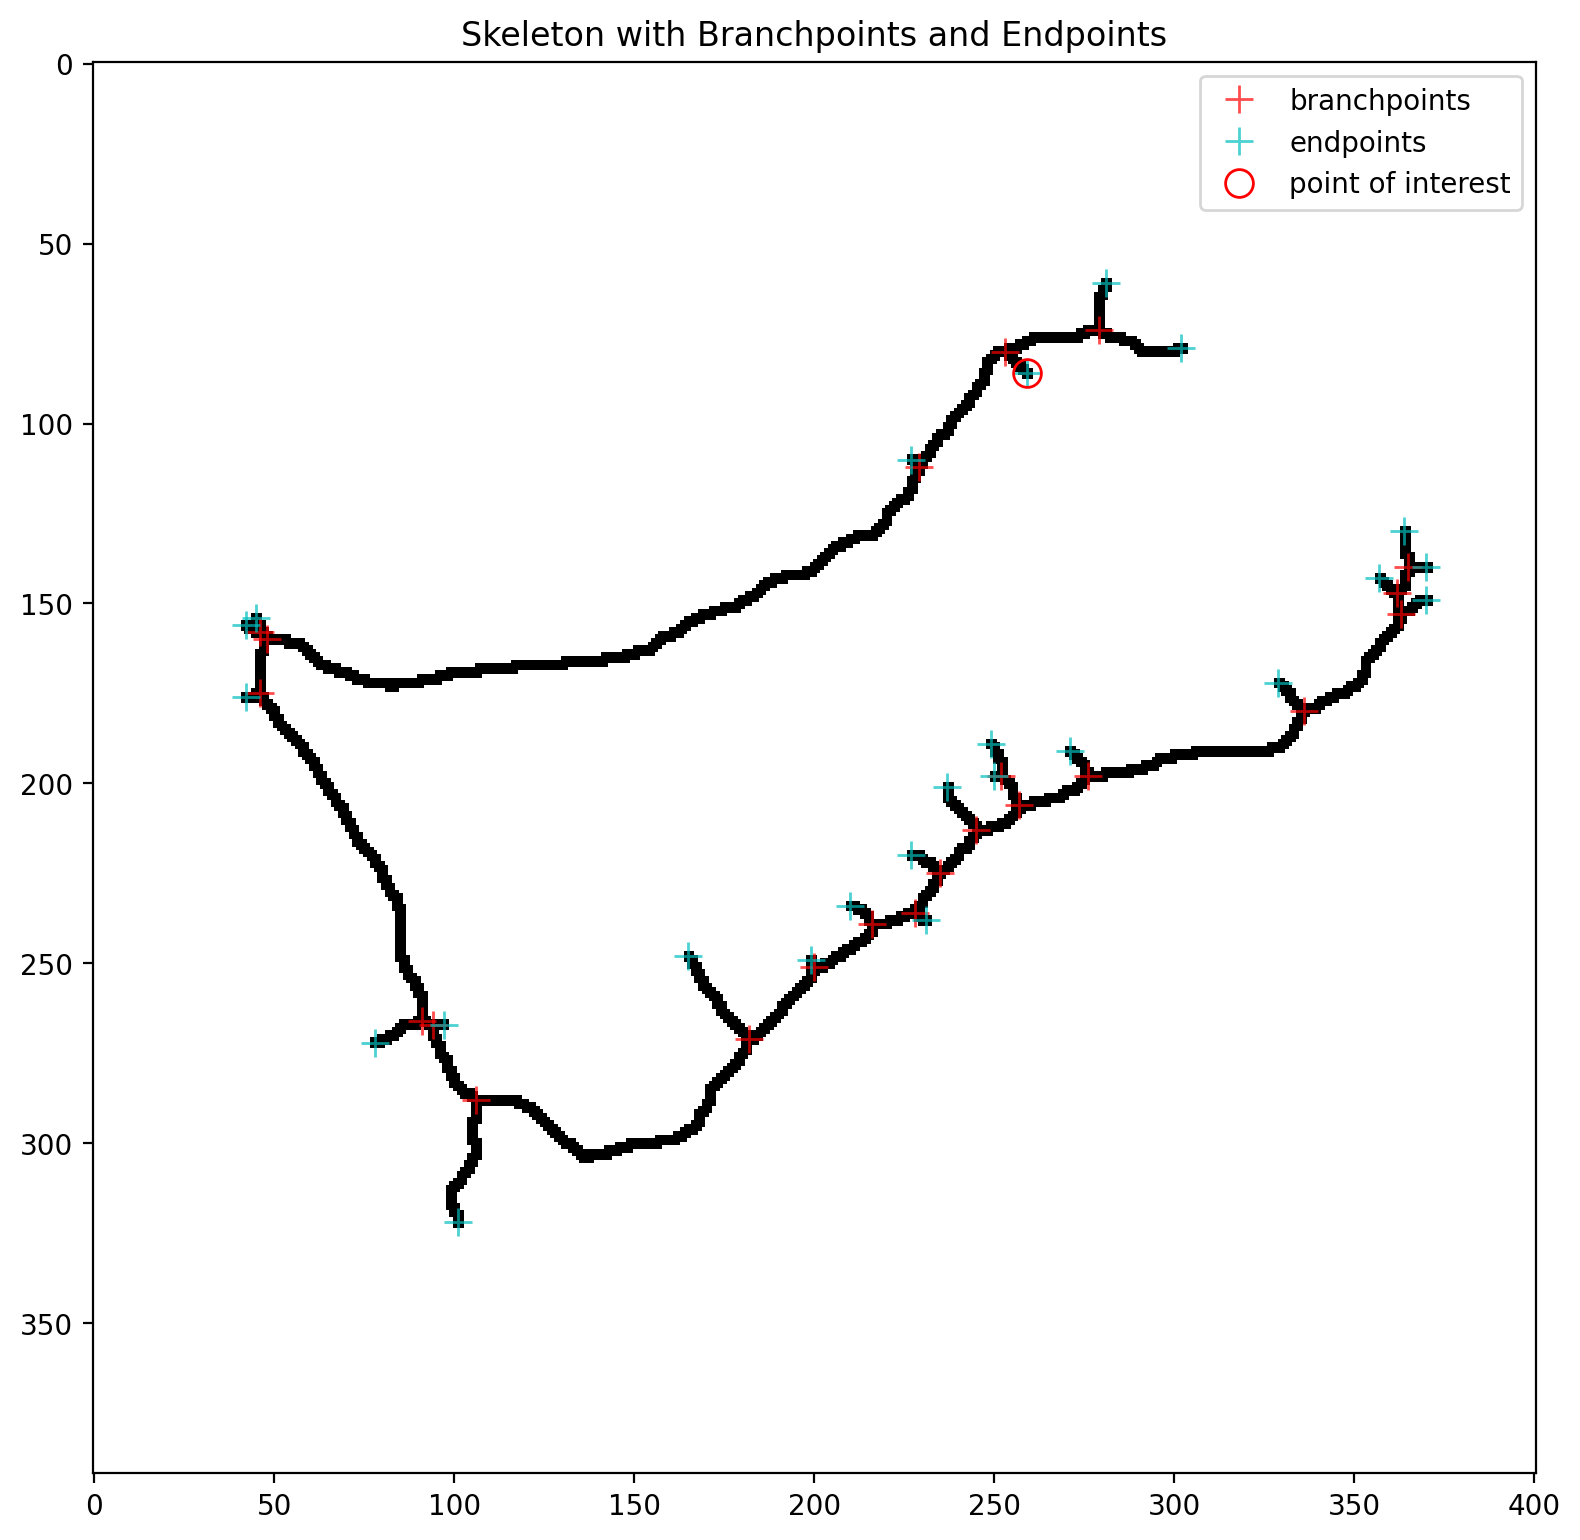

col =  18
k =  3
E location y, x =  (110, 227)


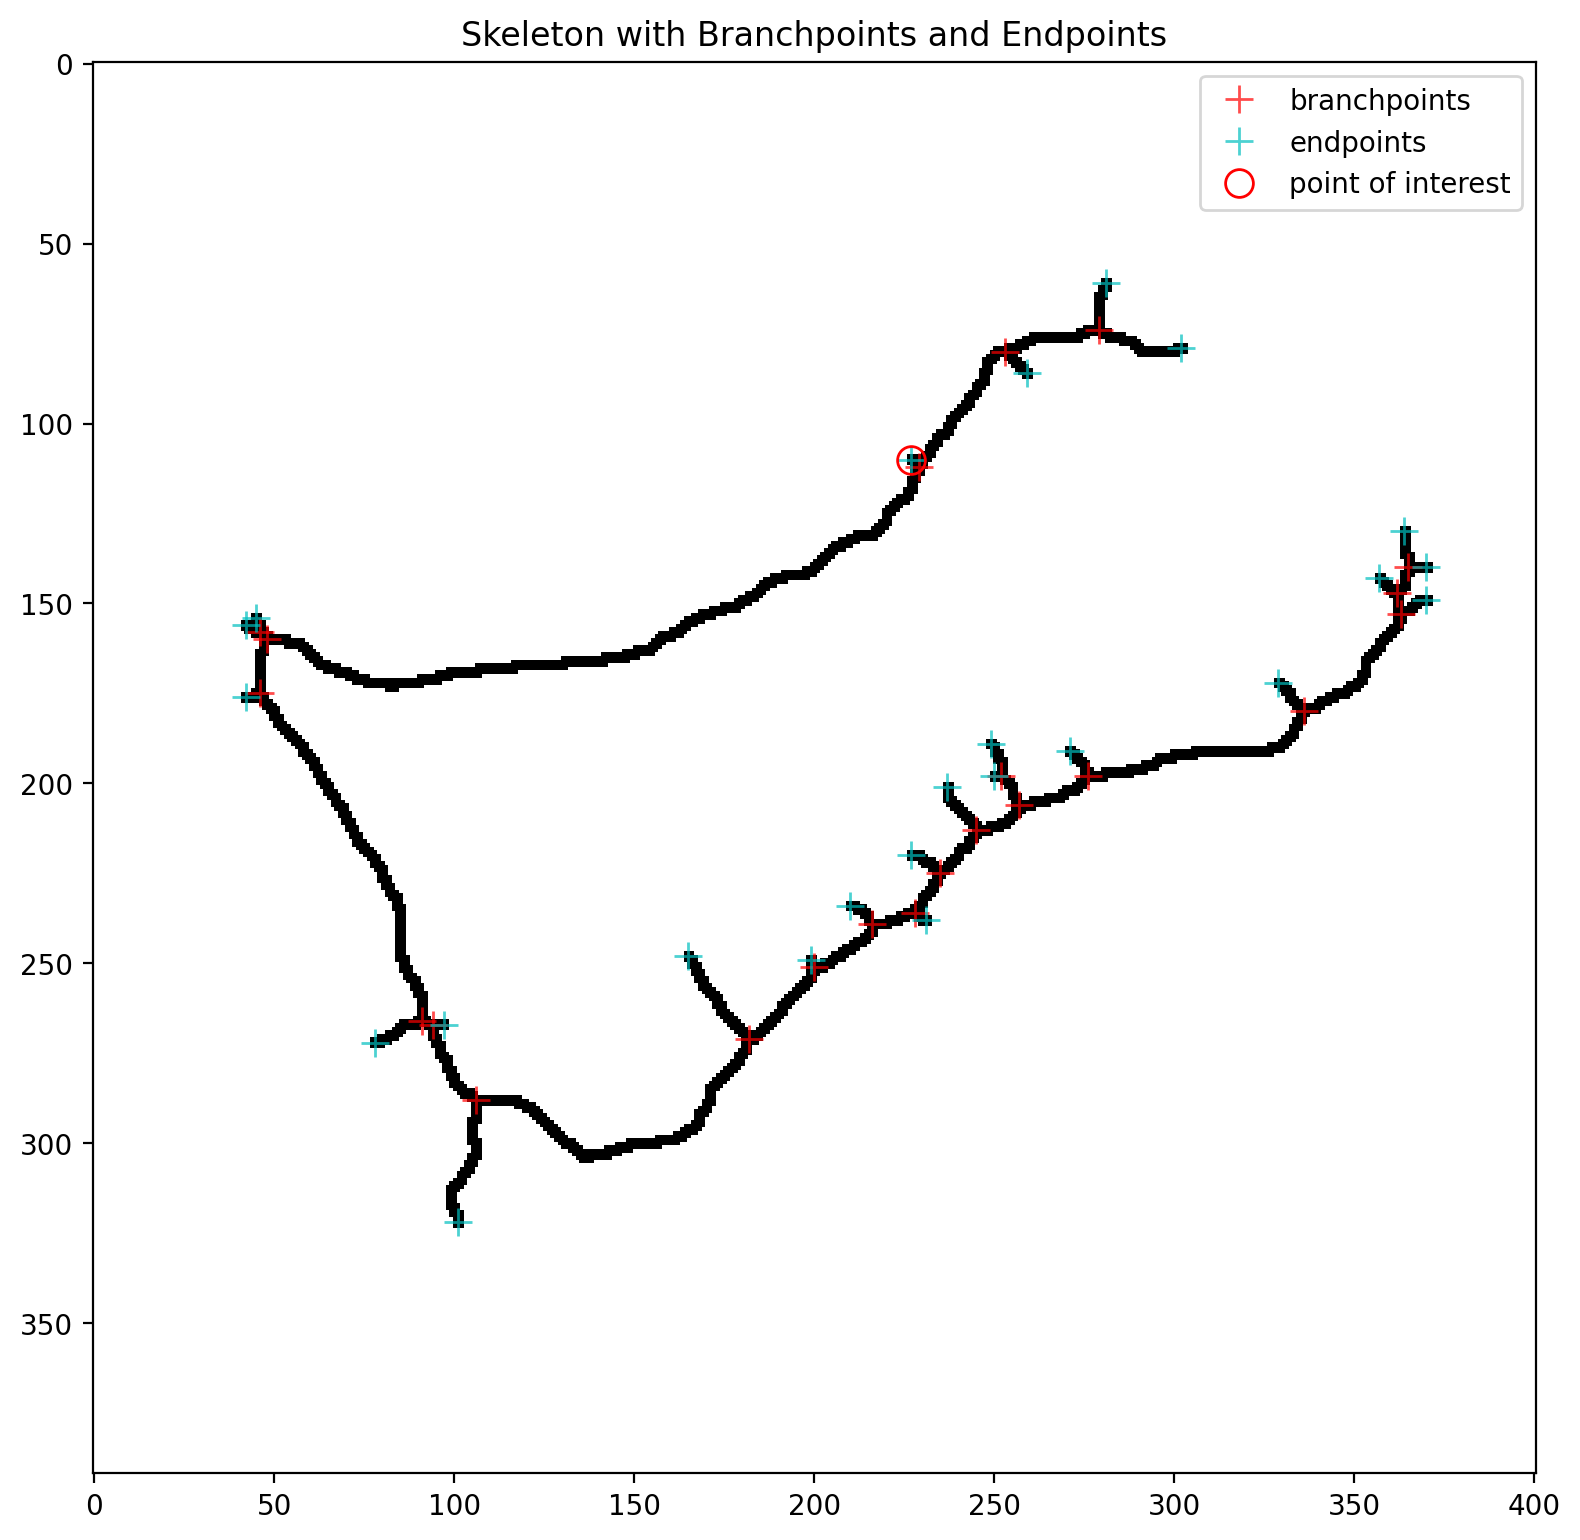

col =  24
k =  4
E location y, x =  (130, 364)


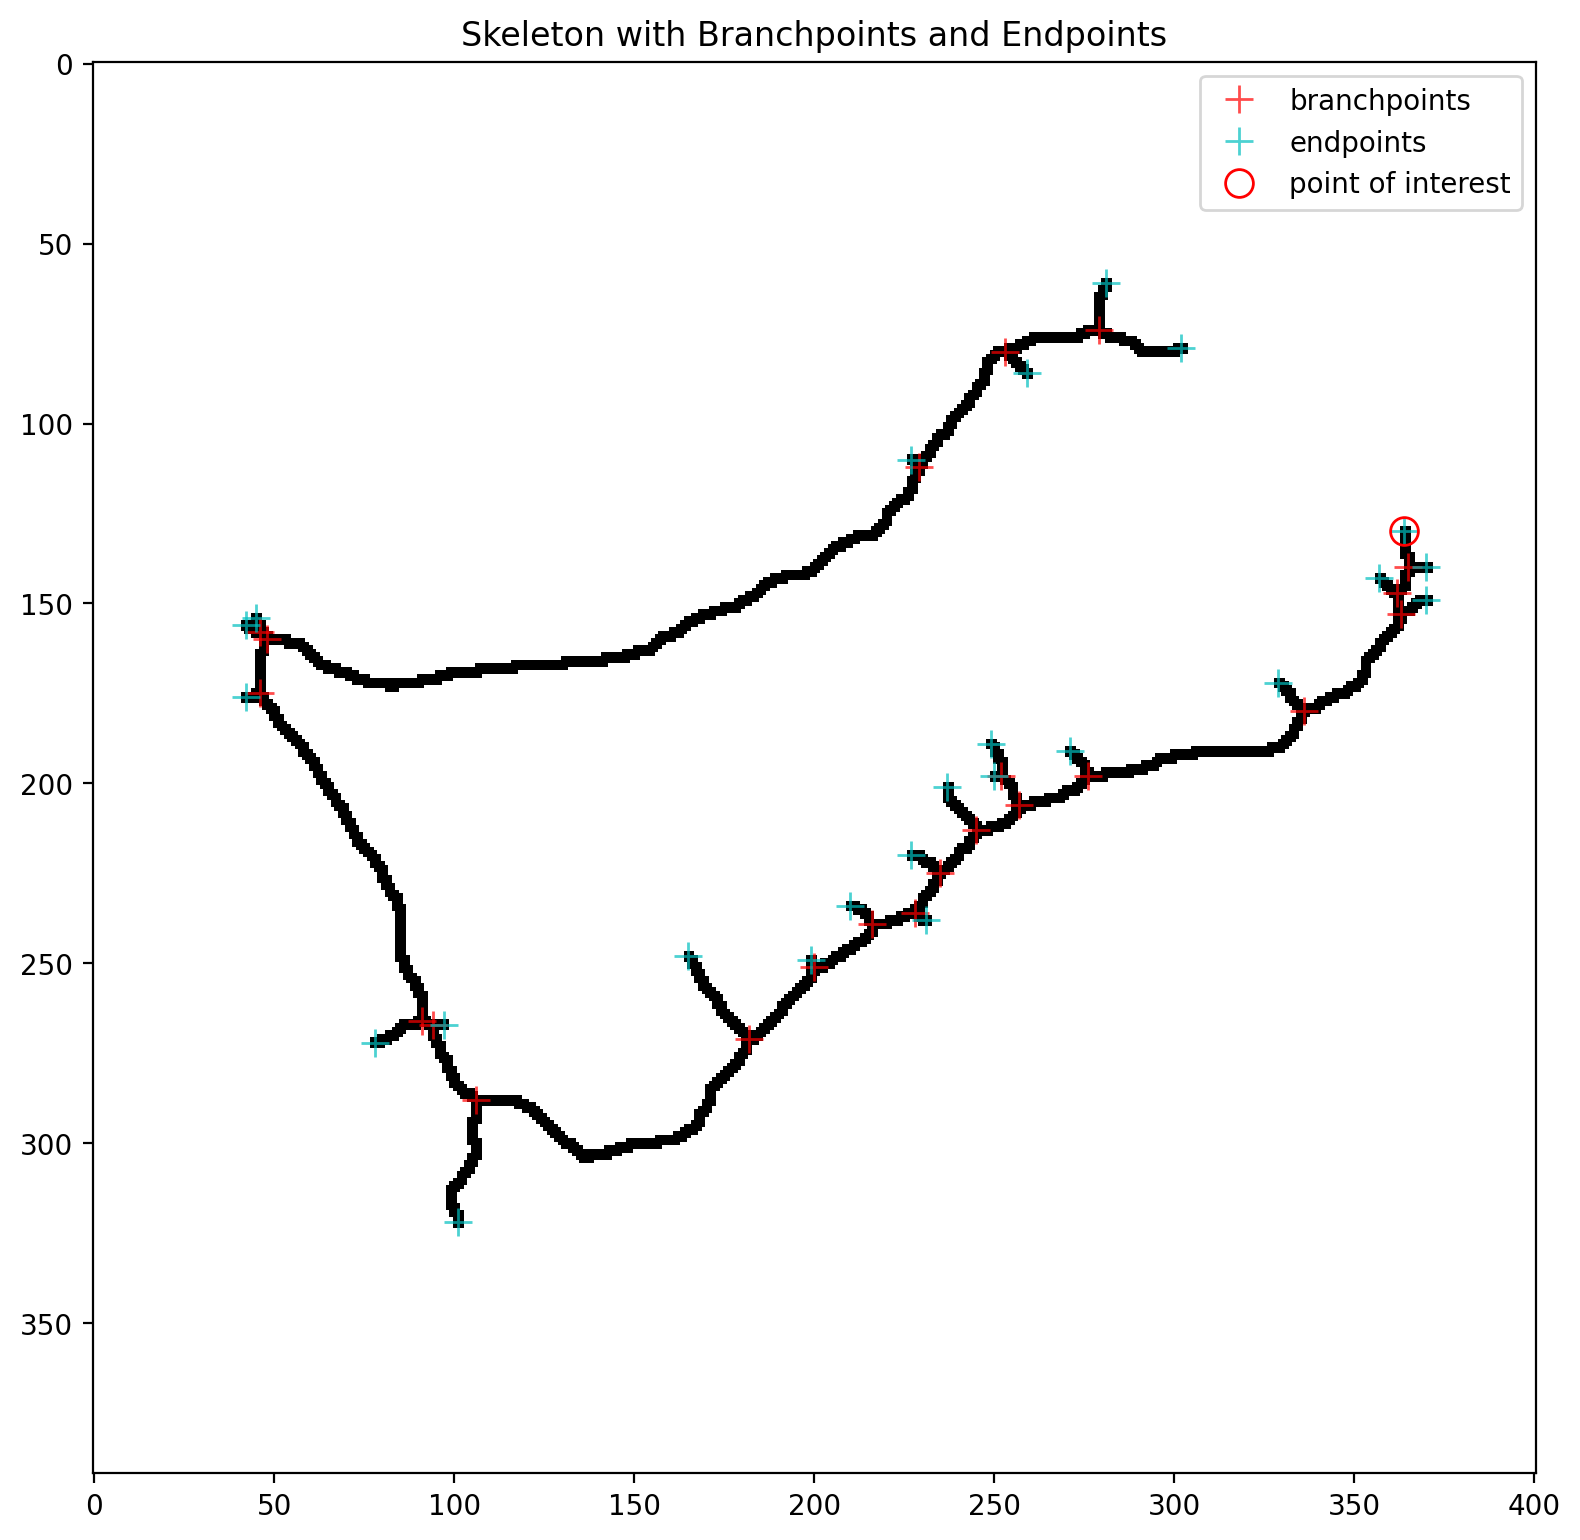

col =  30
k =  5
E location y, x =  (140, 370)


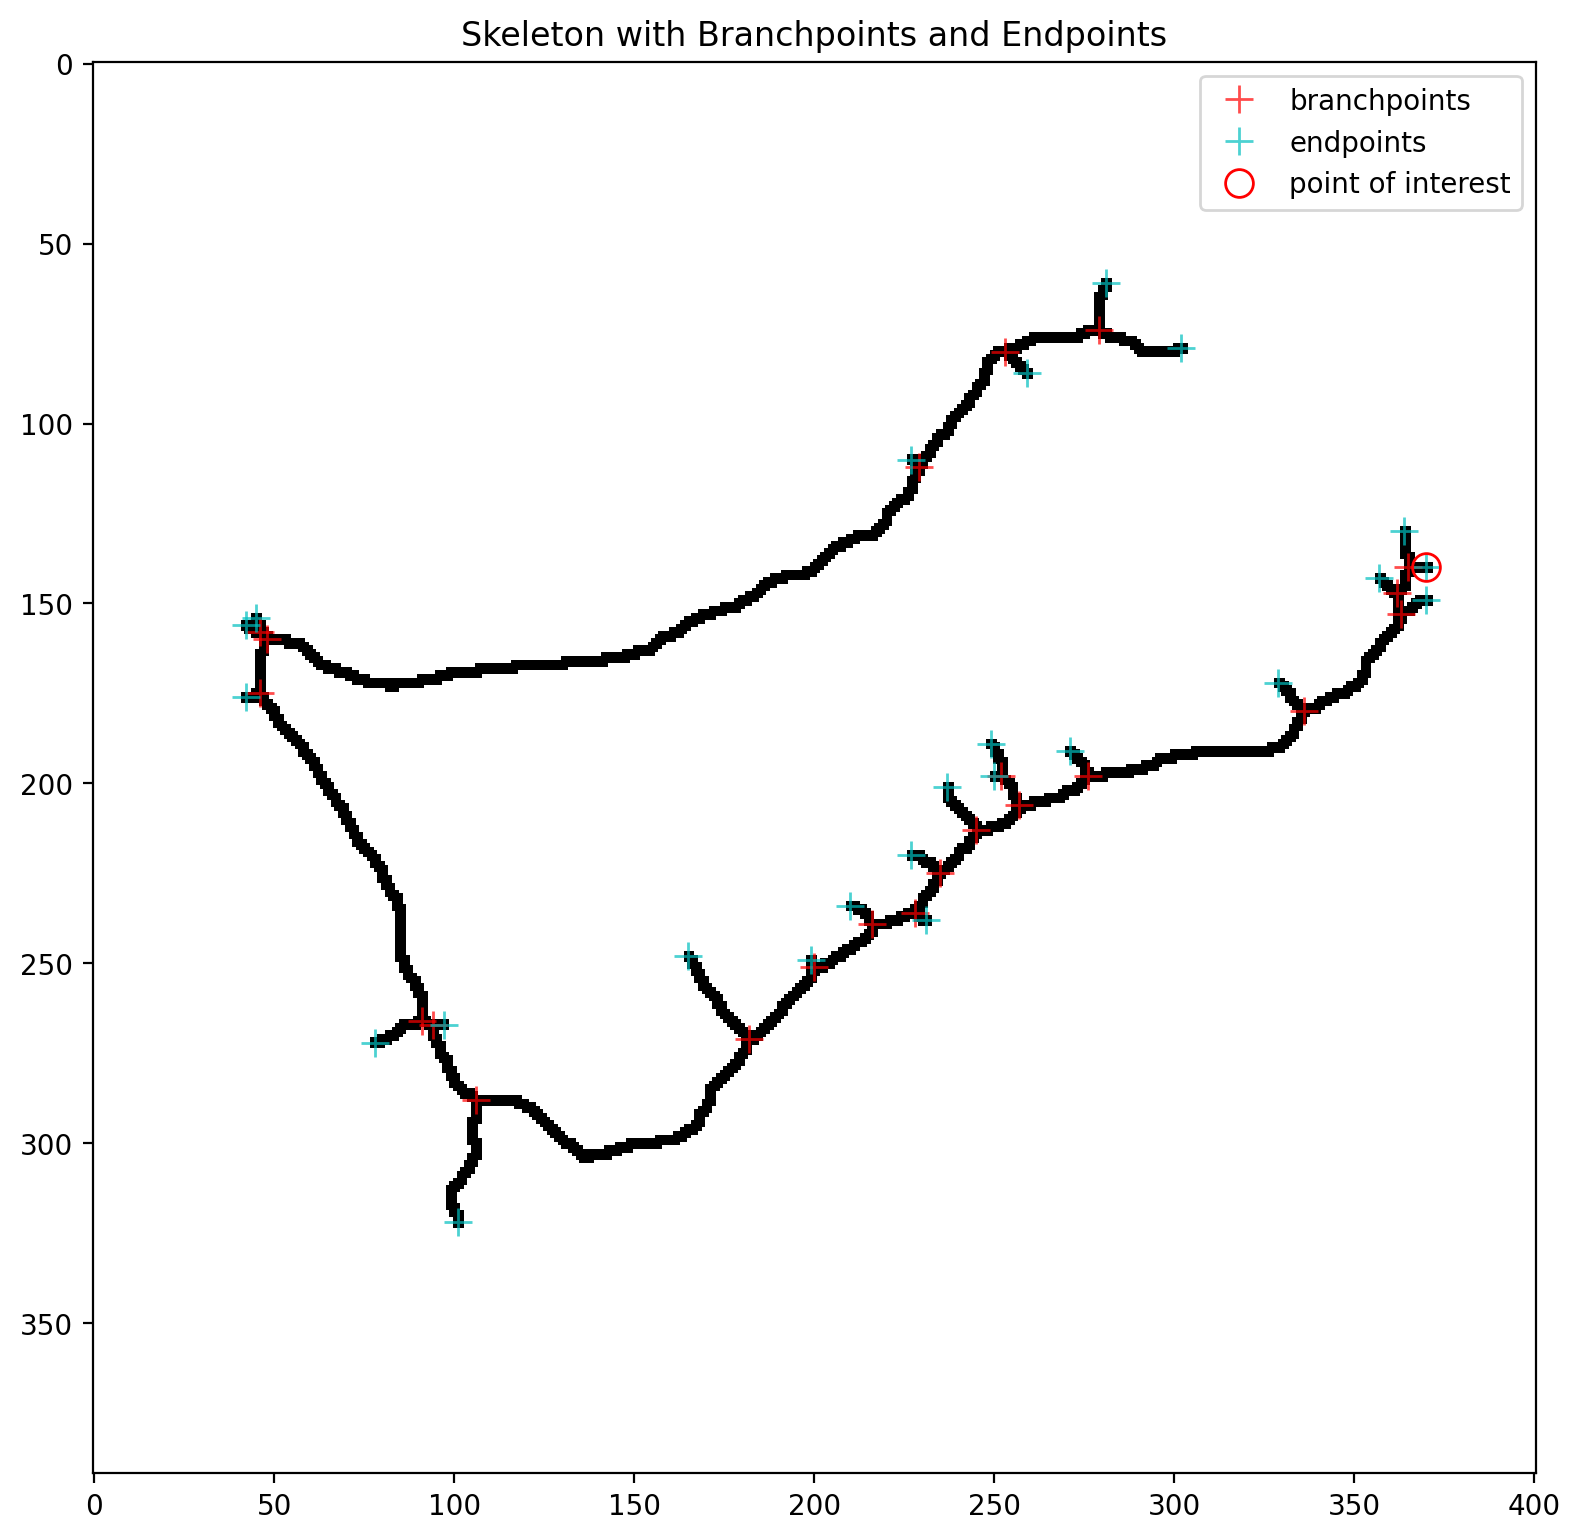

col =  36
k =  6
E location y, x =  (143, 357)


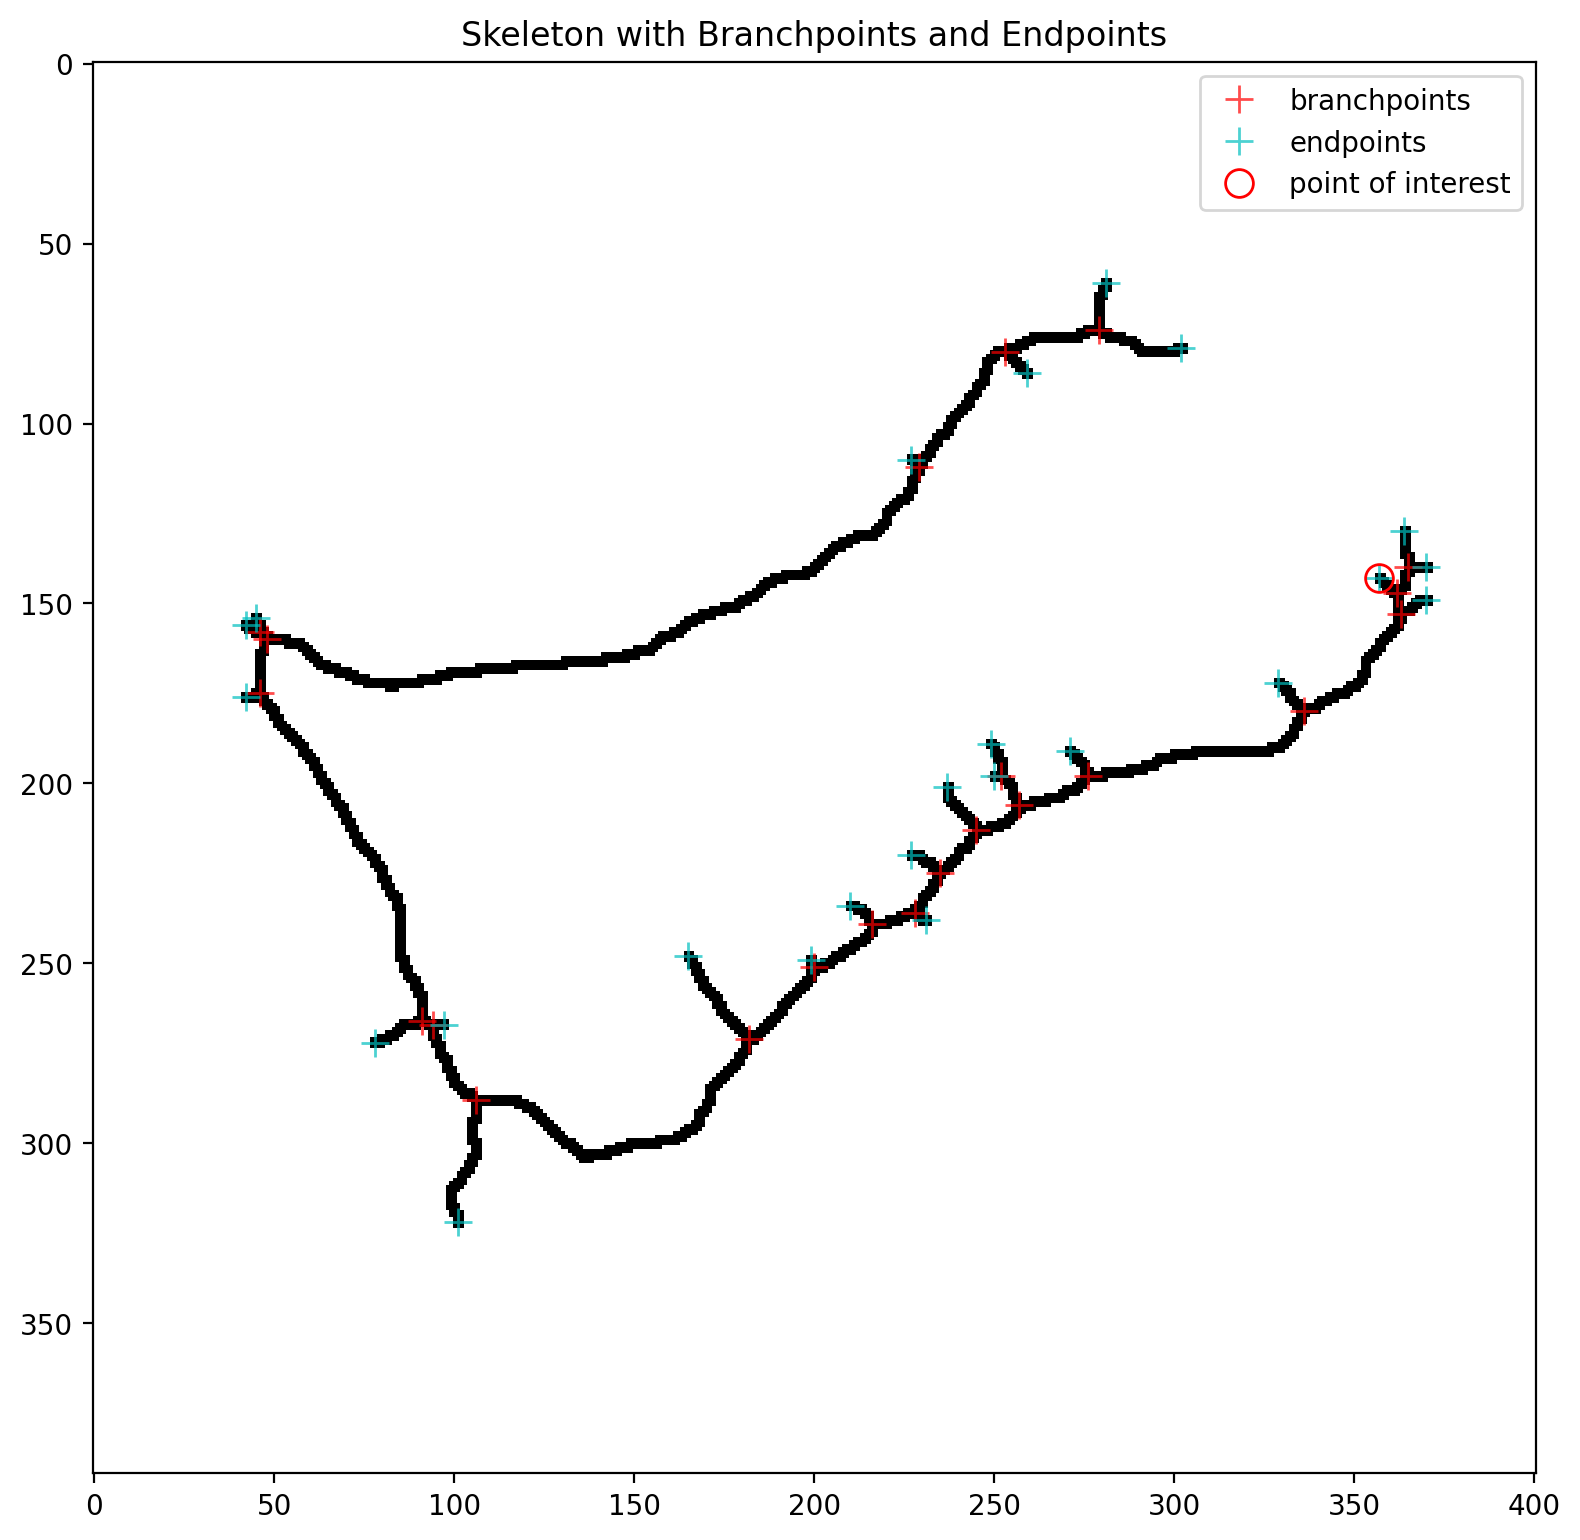

col =  42
k =  7
E location y, x =  (149, 370)


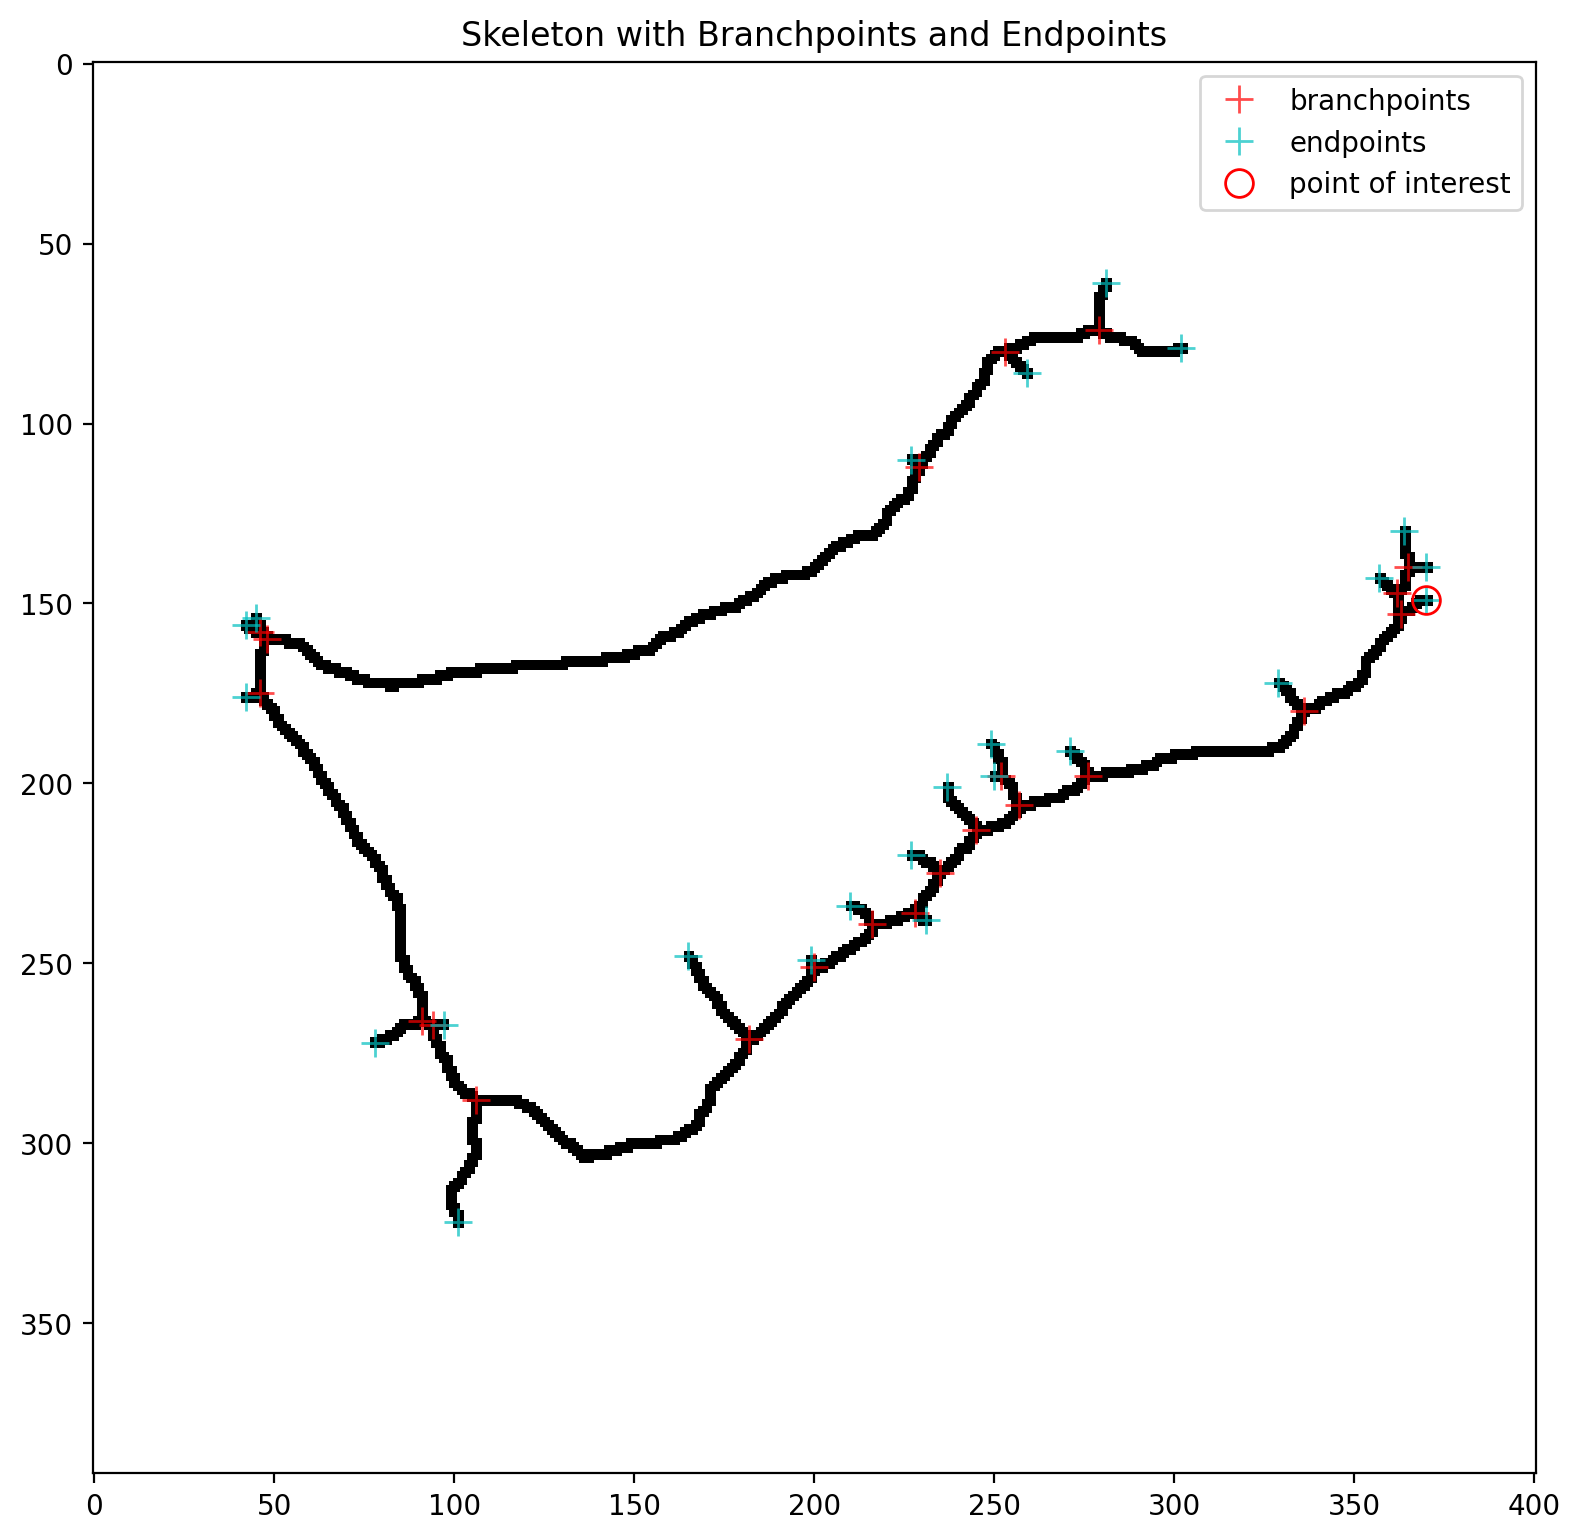

col =  48
k =  8
E location y, x =  (154, 45)


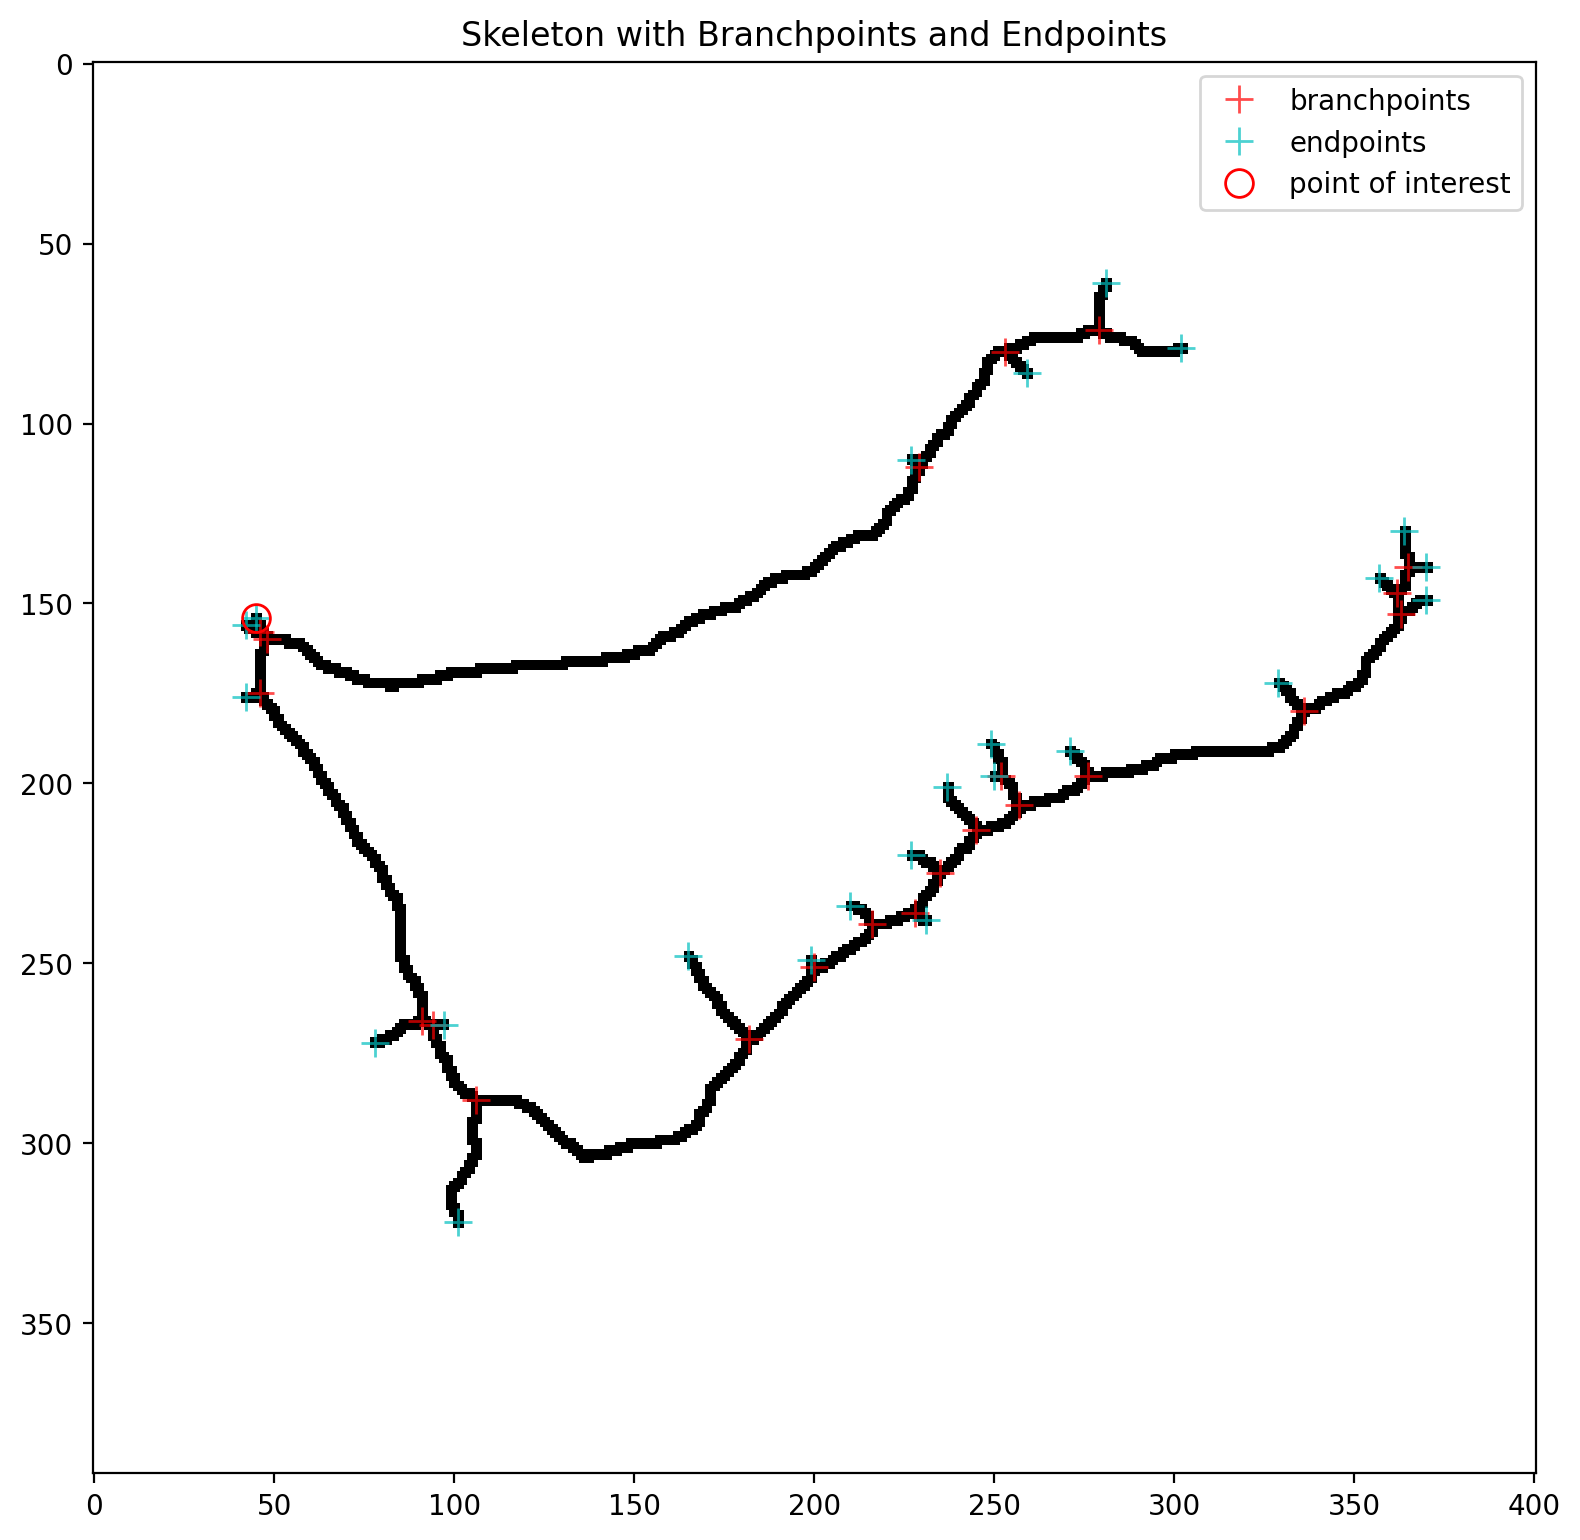

col =  54
k =  9
E location y, x =  (172, 329)


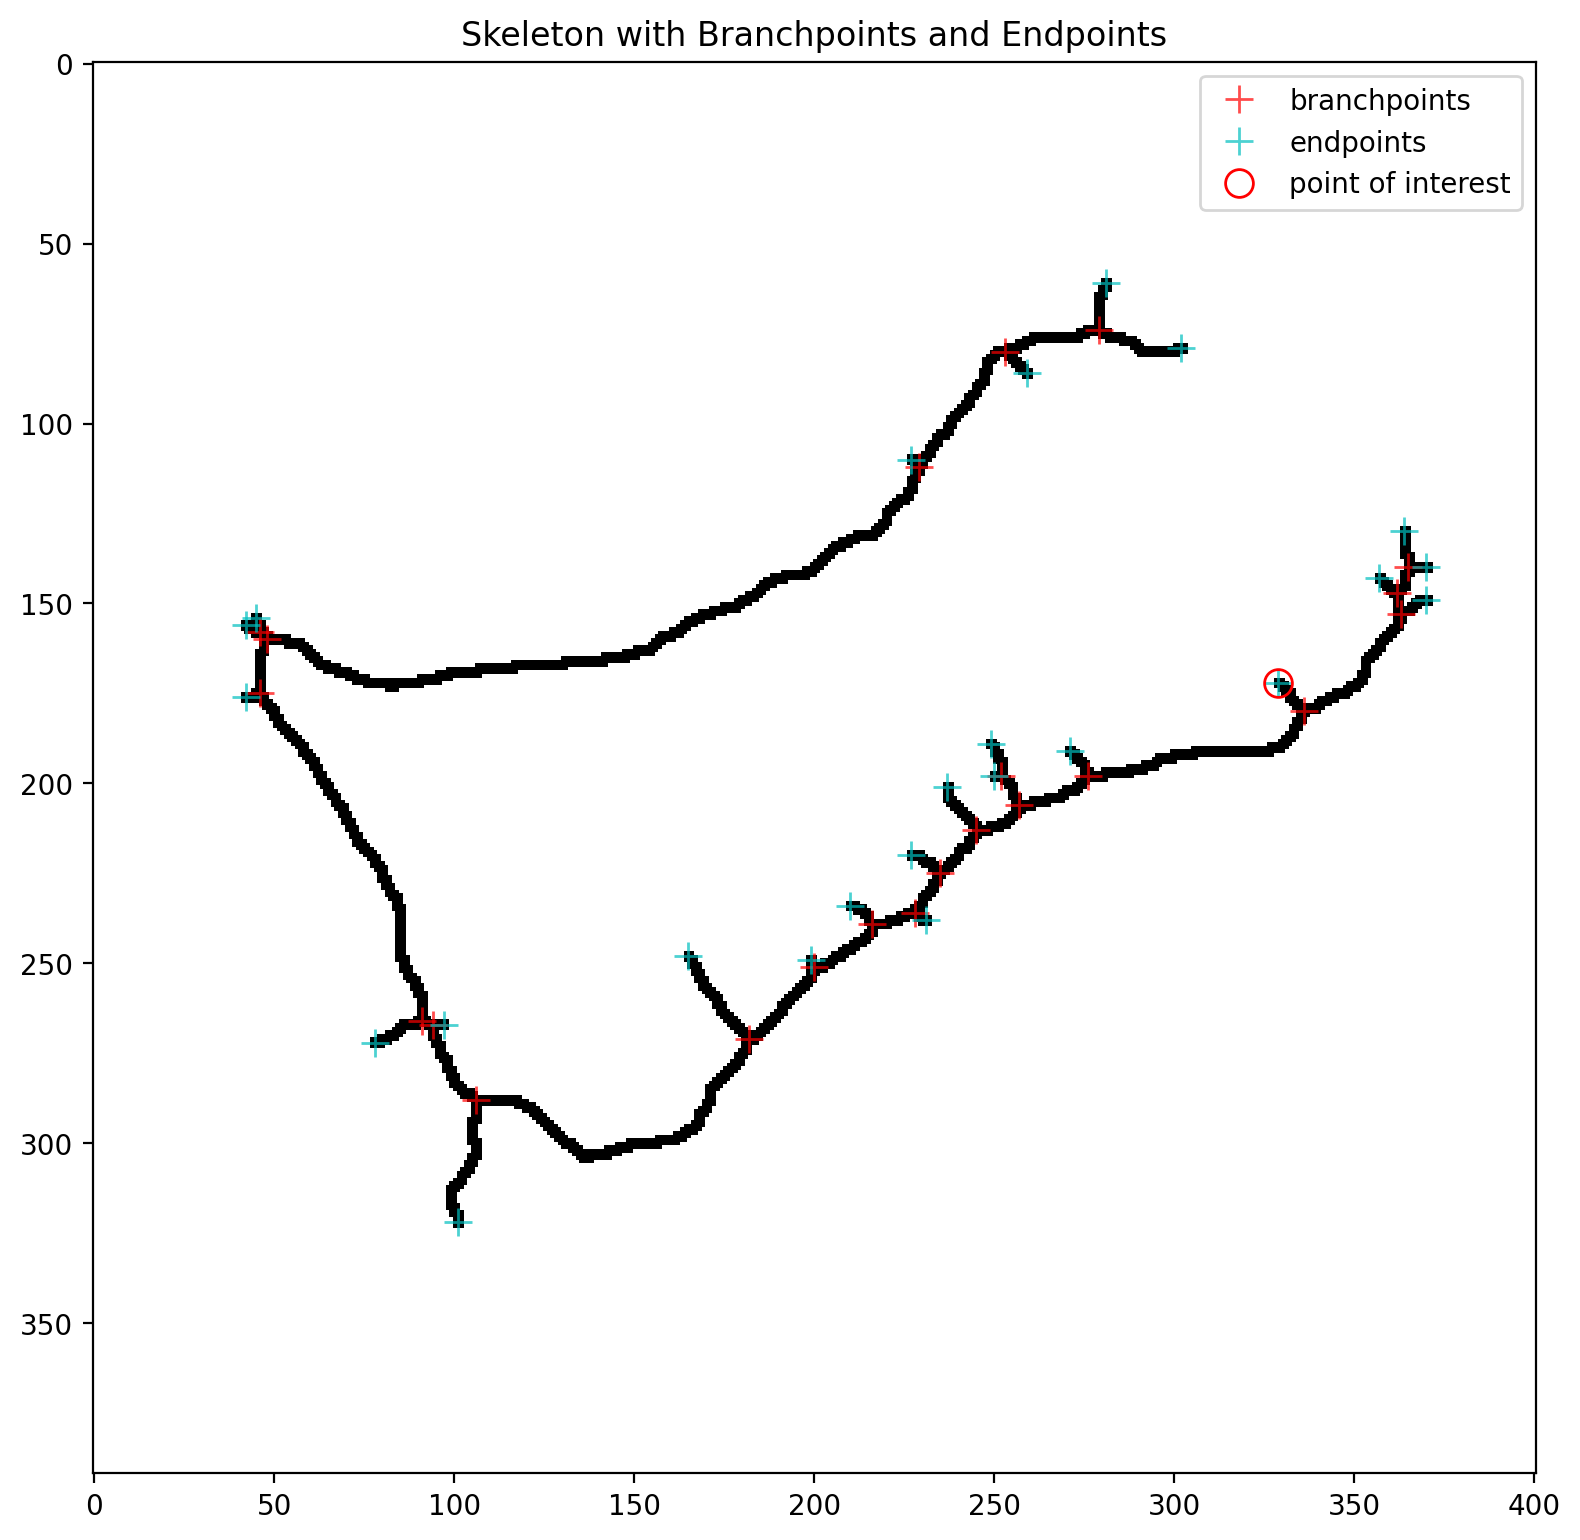

col =  60
k =  10
E location y, x =  (176, 42)


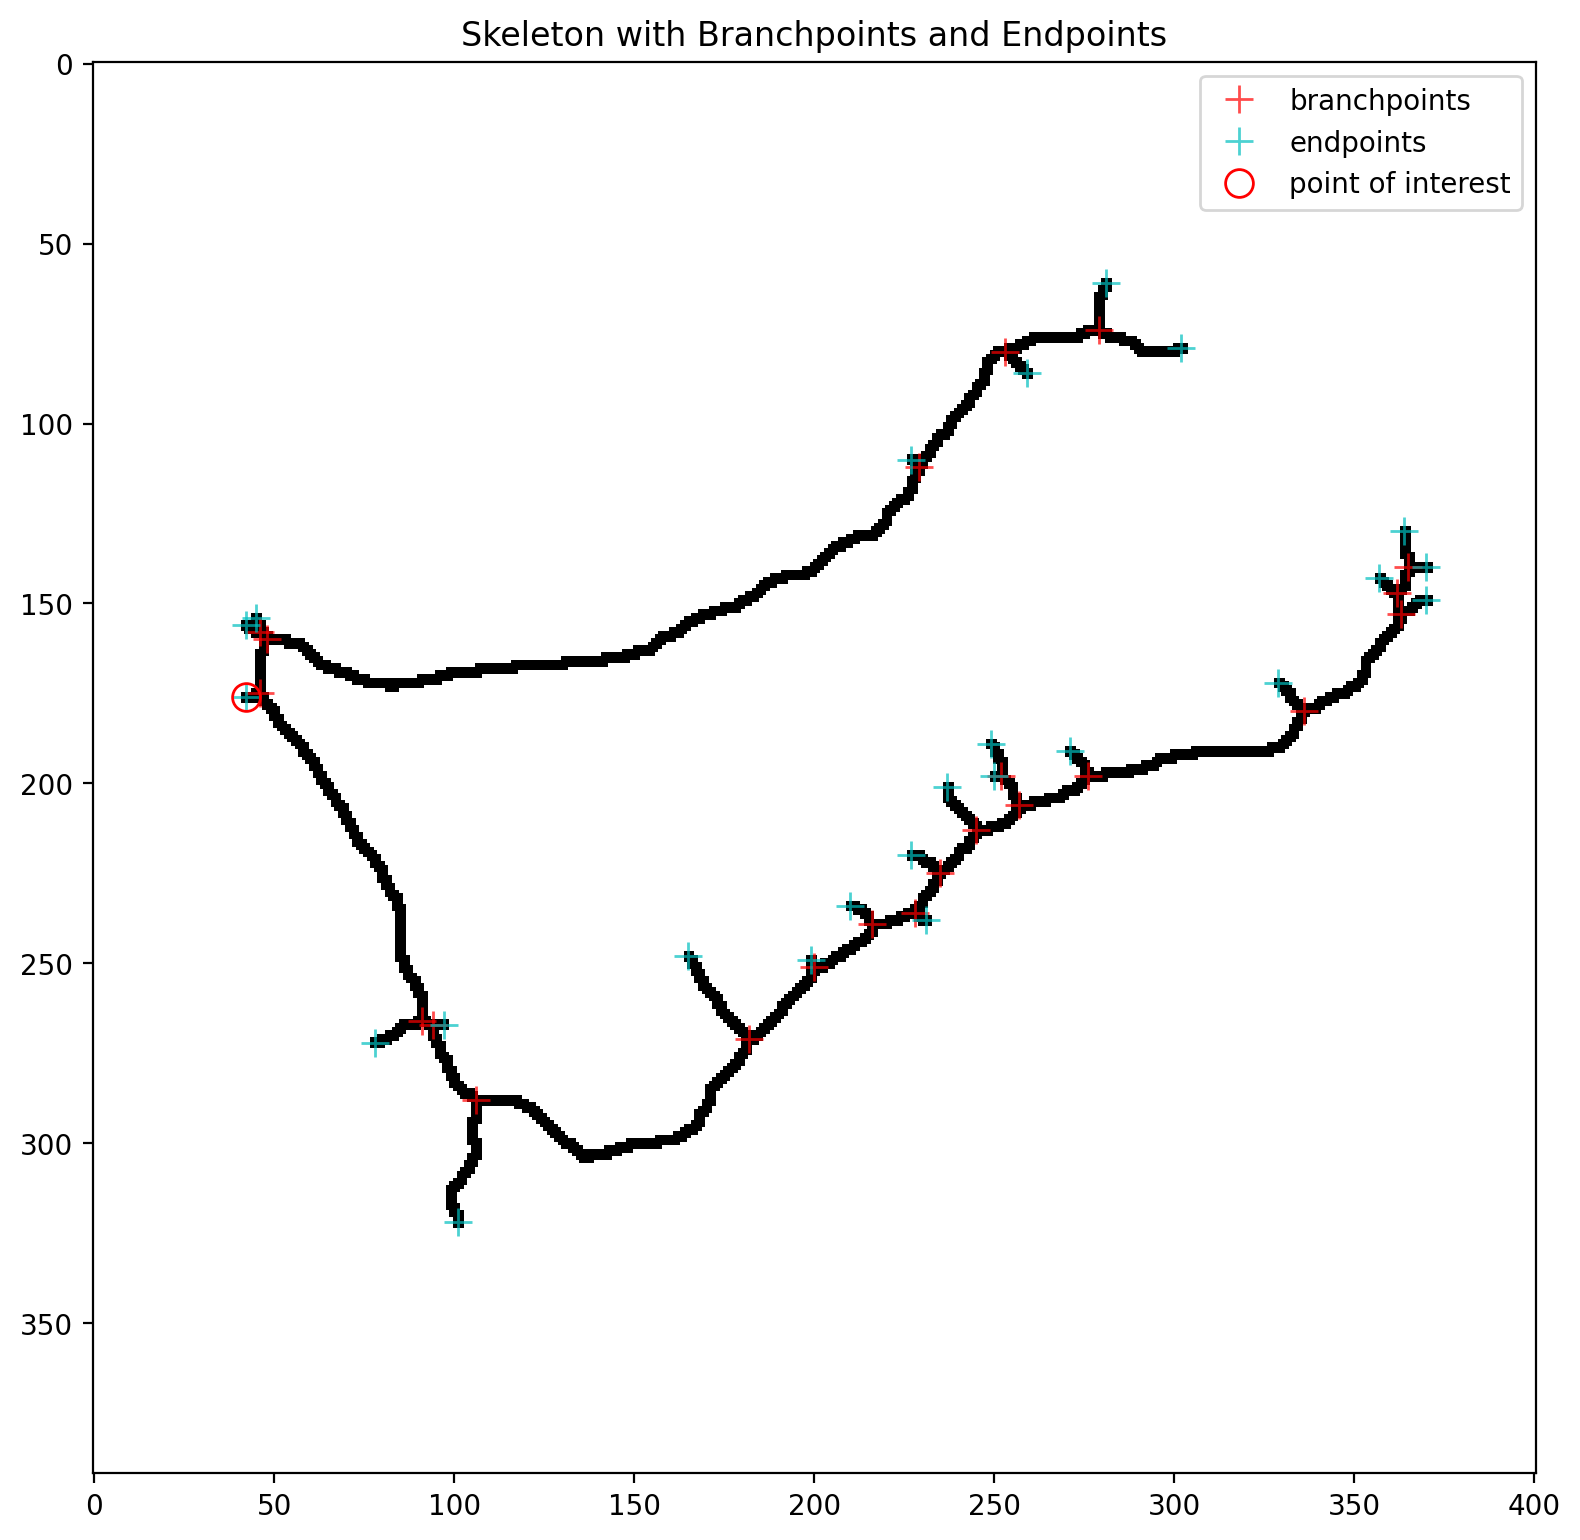

col =  66
k =  11
E location y, x =  (189, 249)


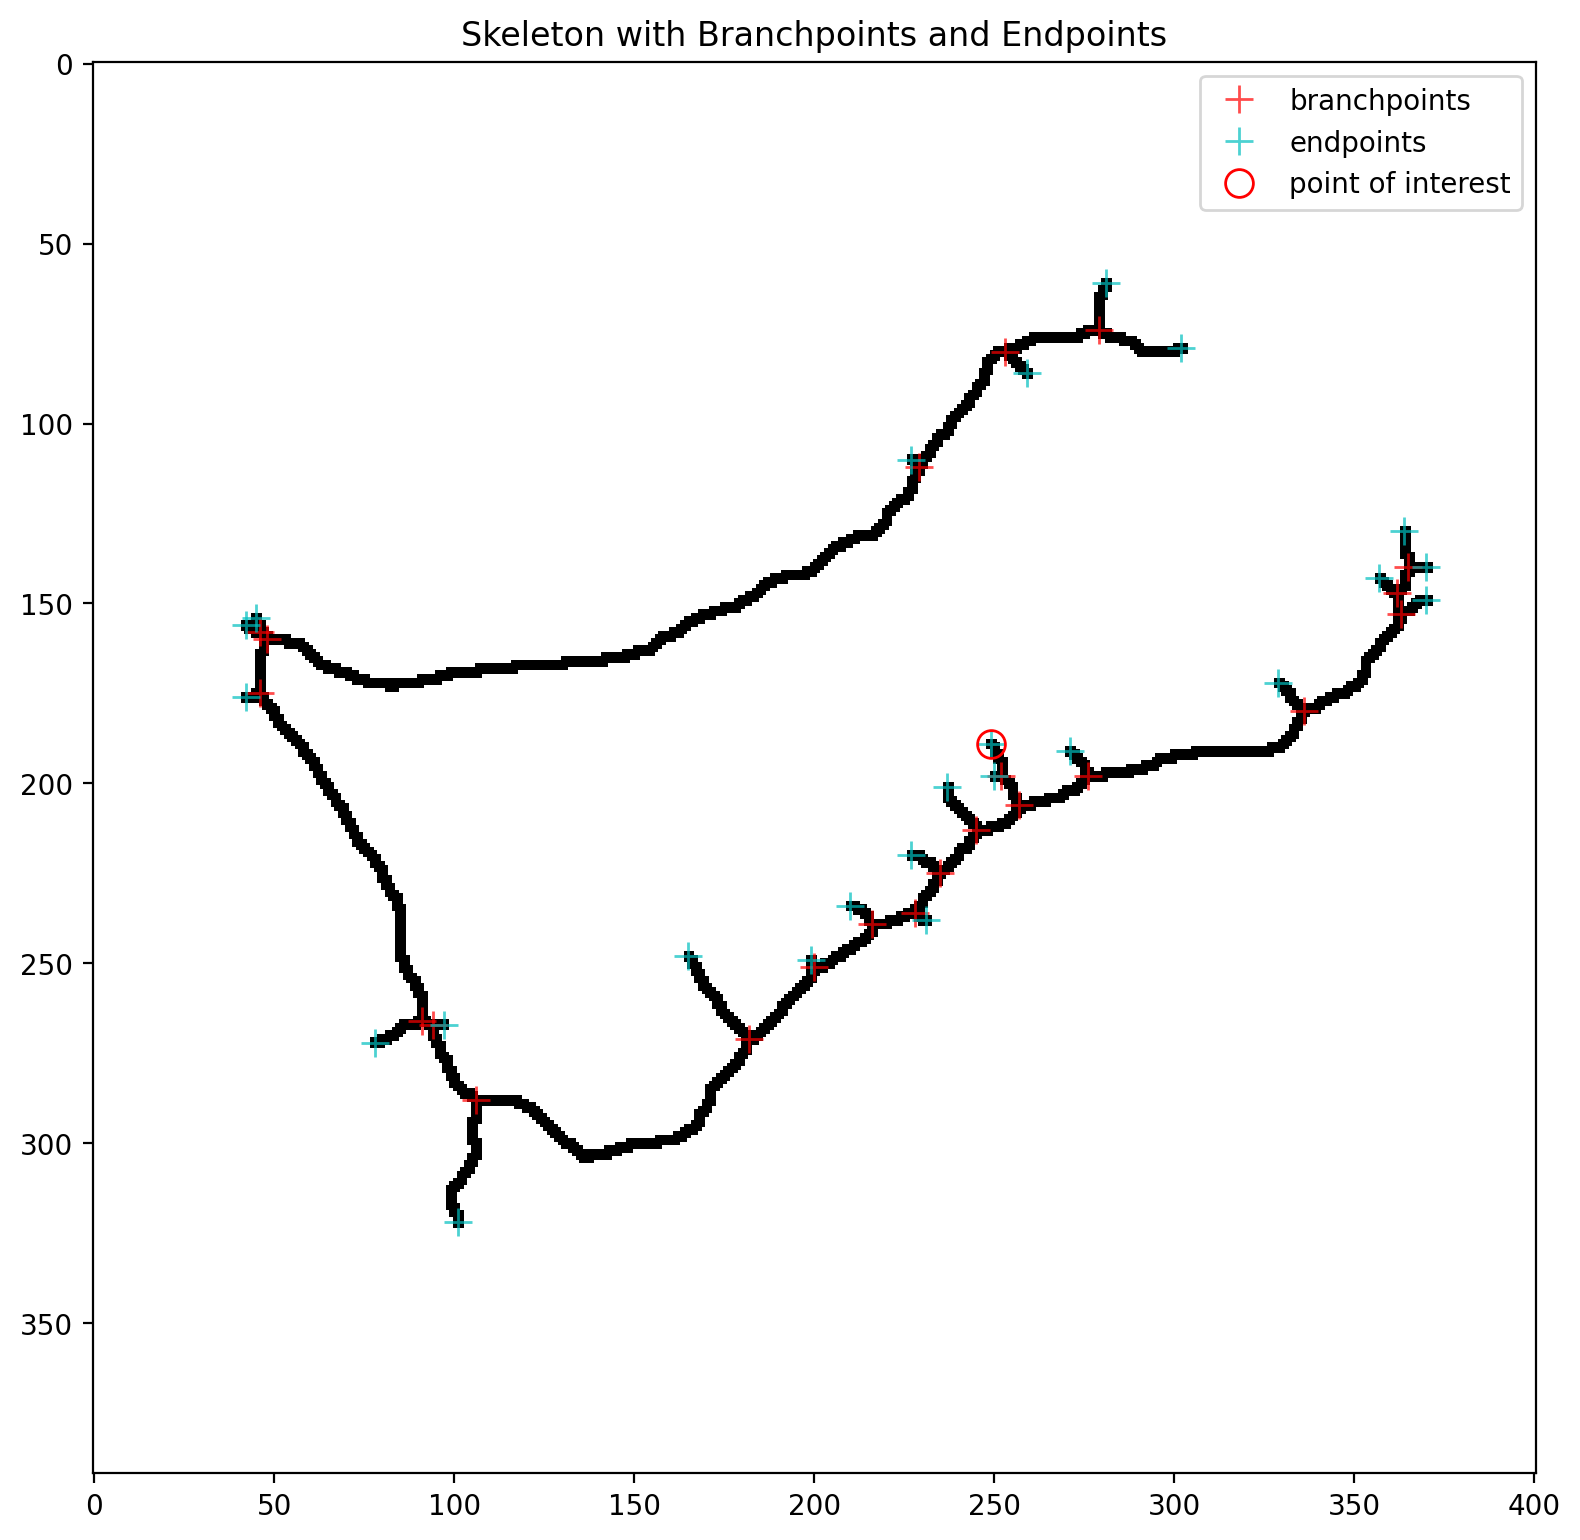

col =  72
k =  12
E location y, x =  (191, 271)


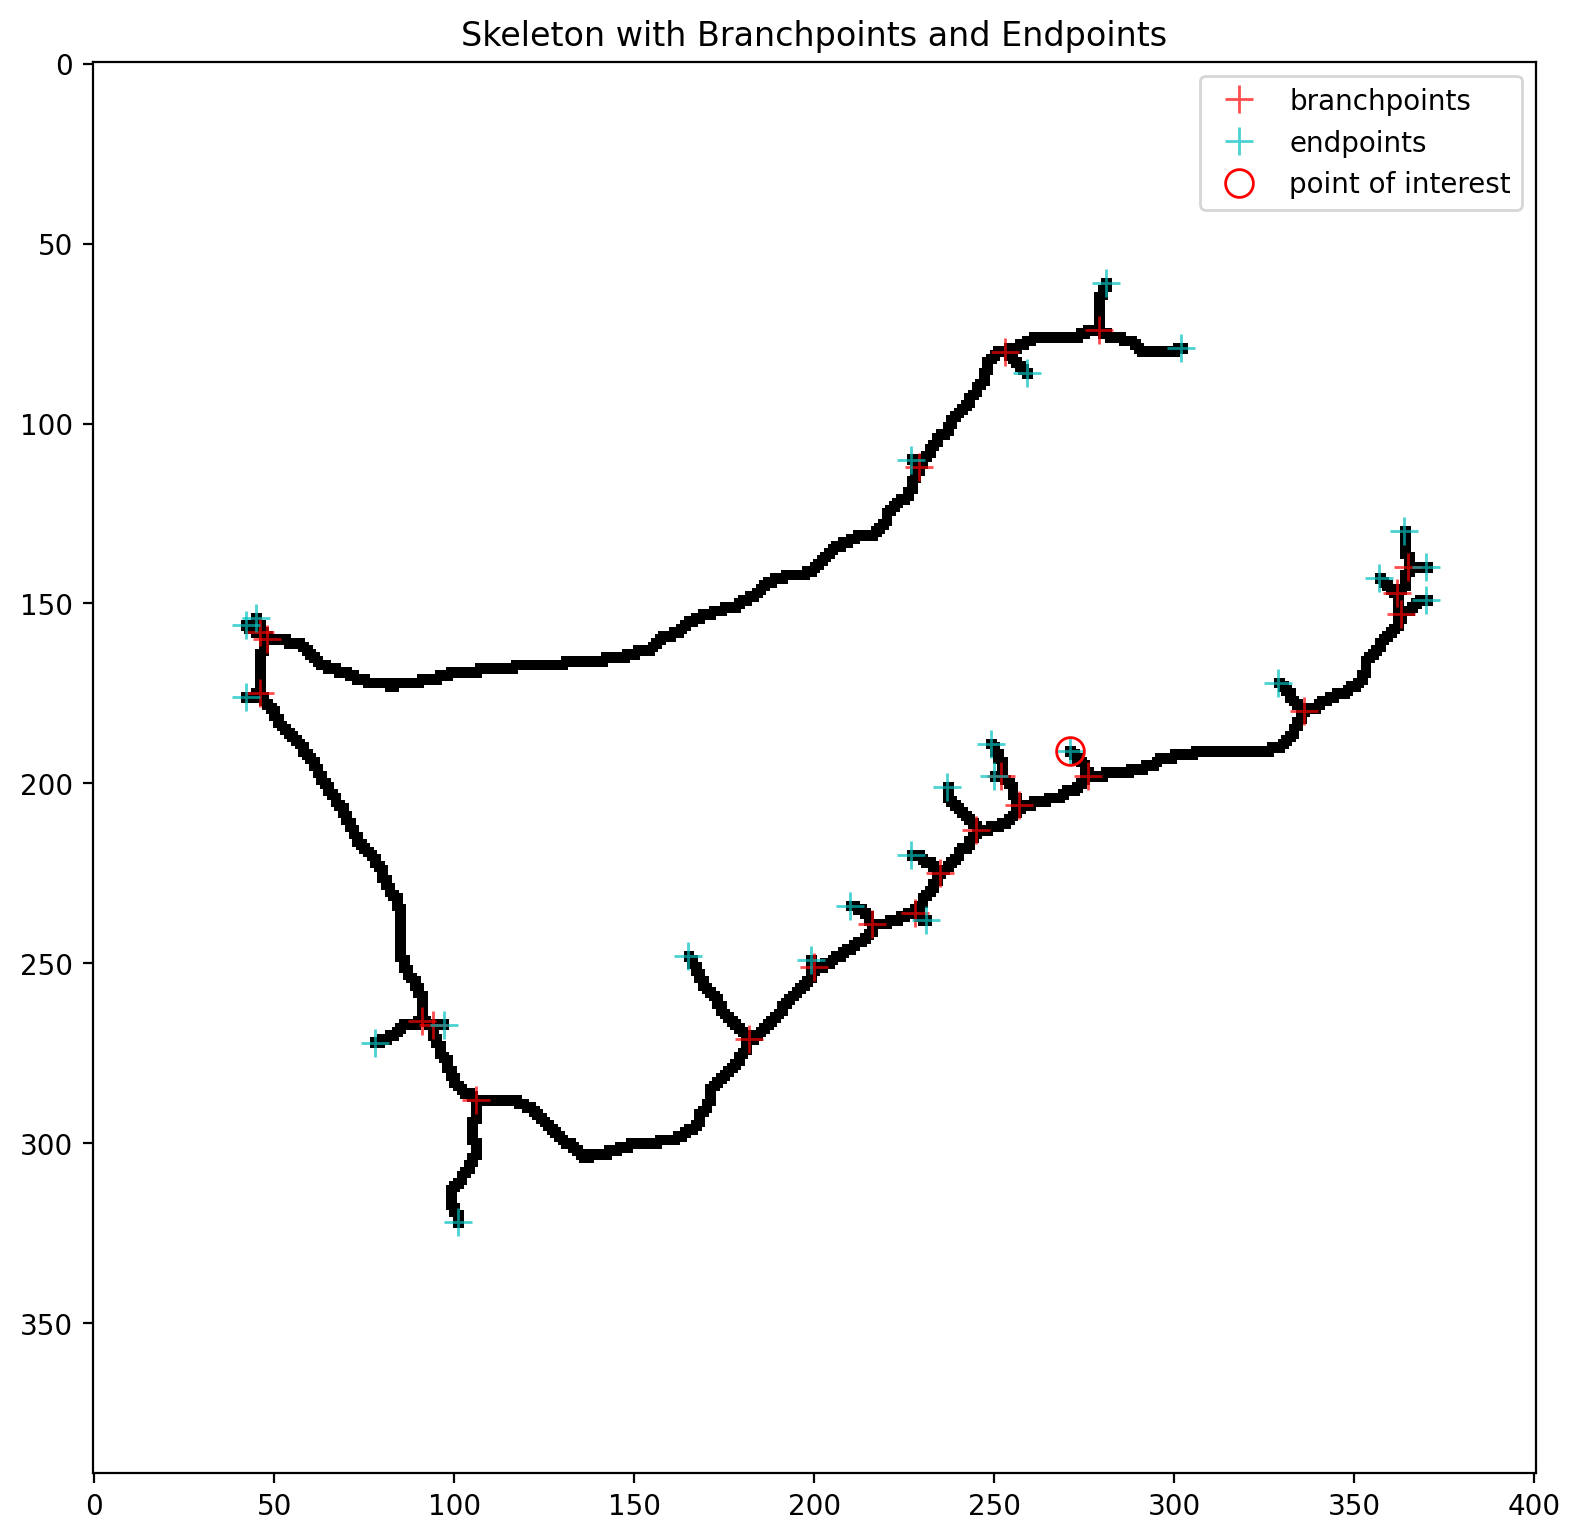

col =  78
k =  13
E location y, x =  (198, 250)


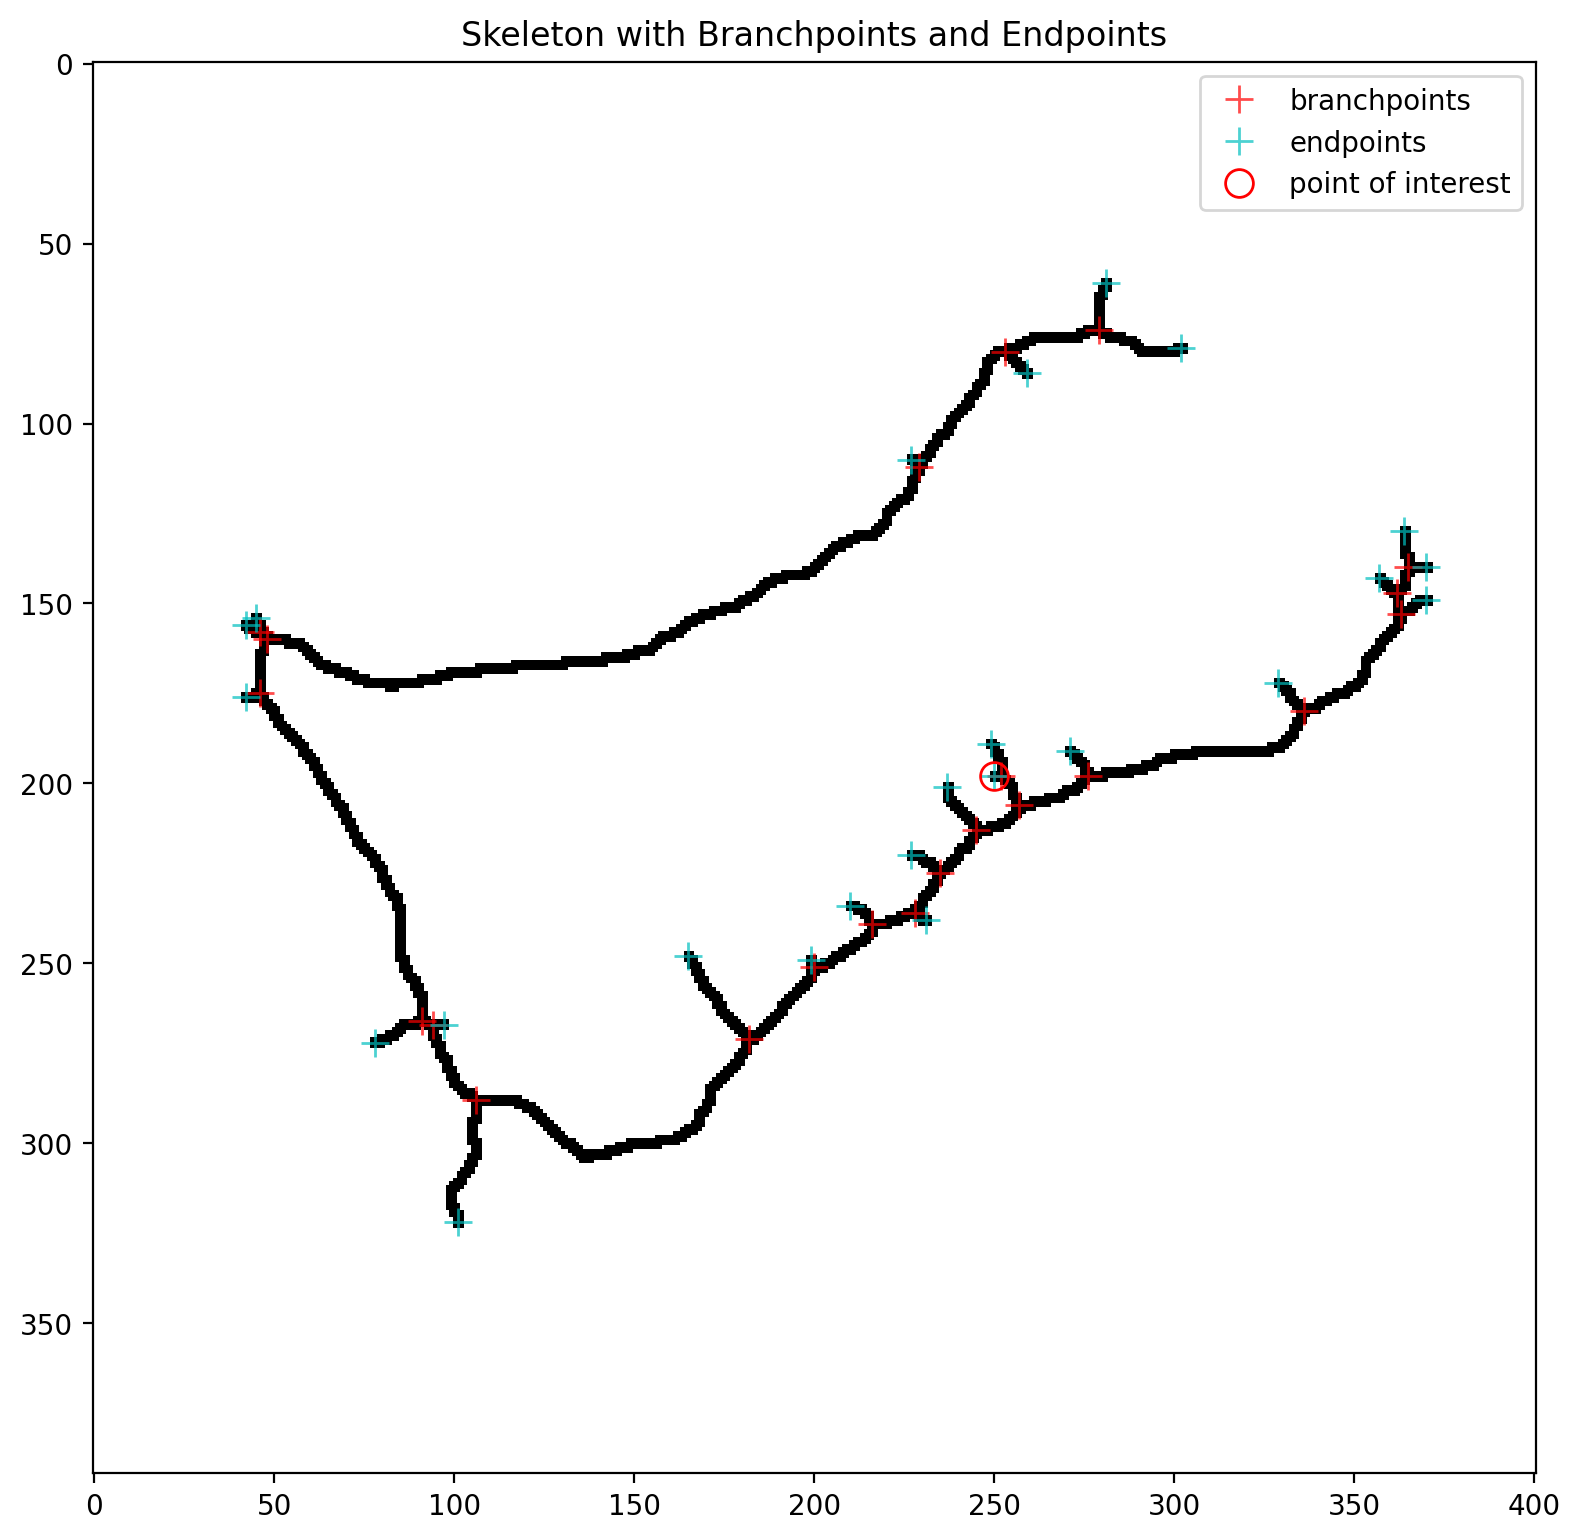

col =  84
k =  14
E location y, x =  (201, 237)


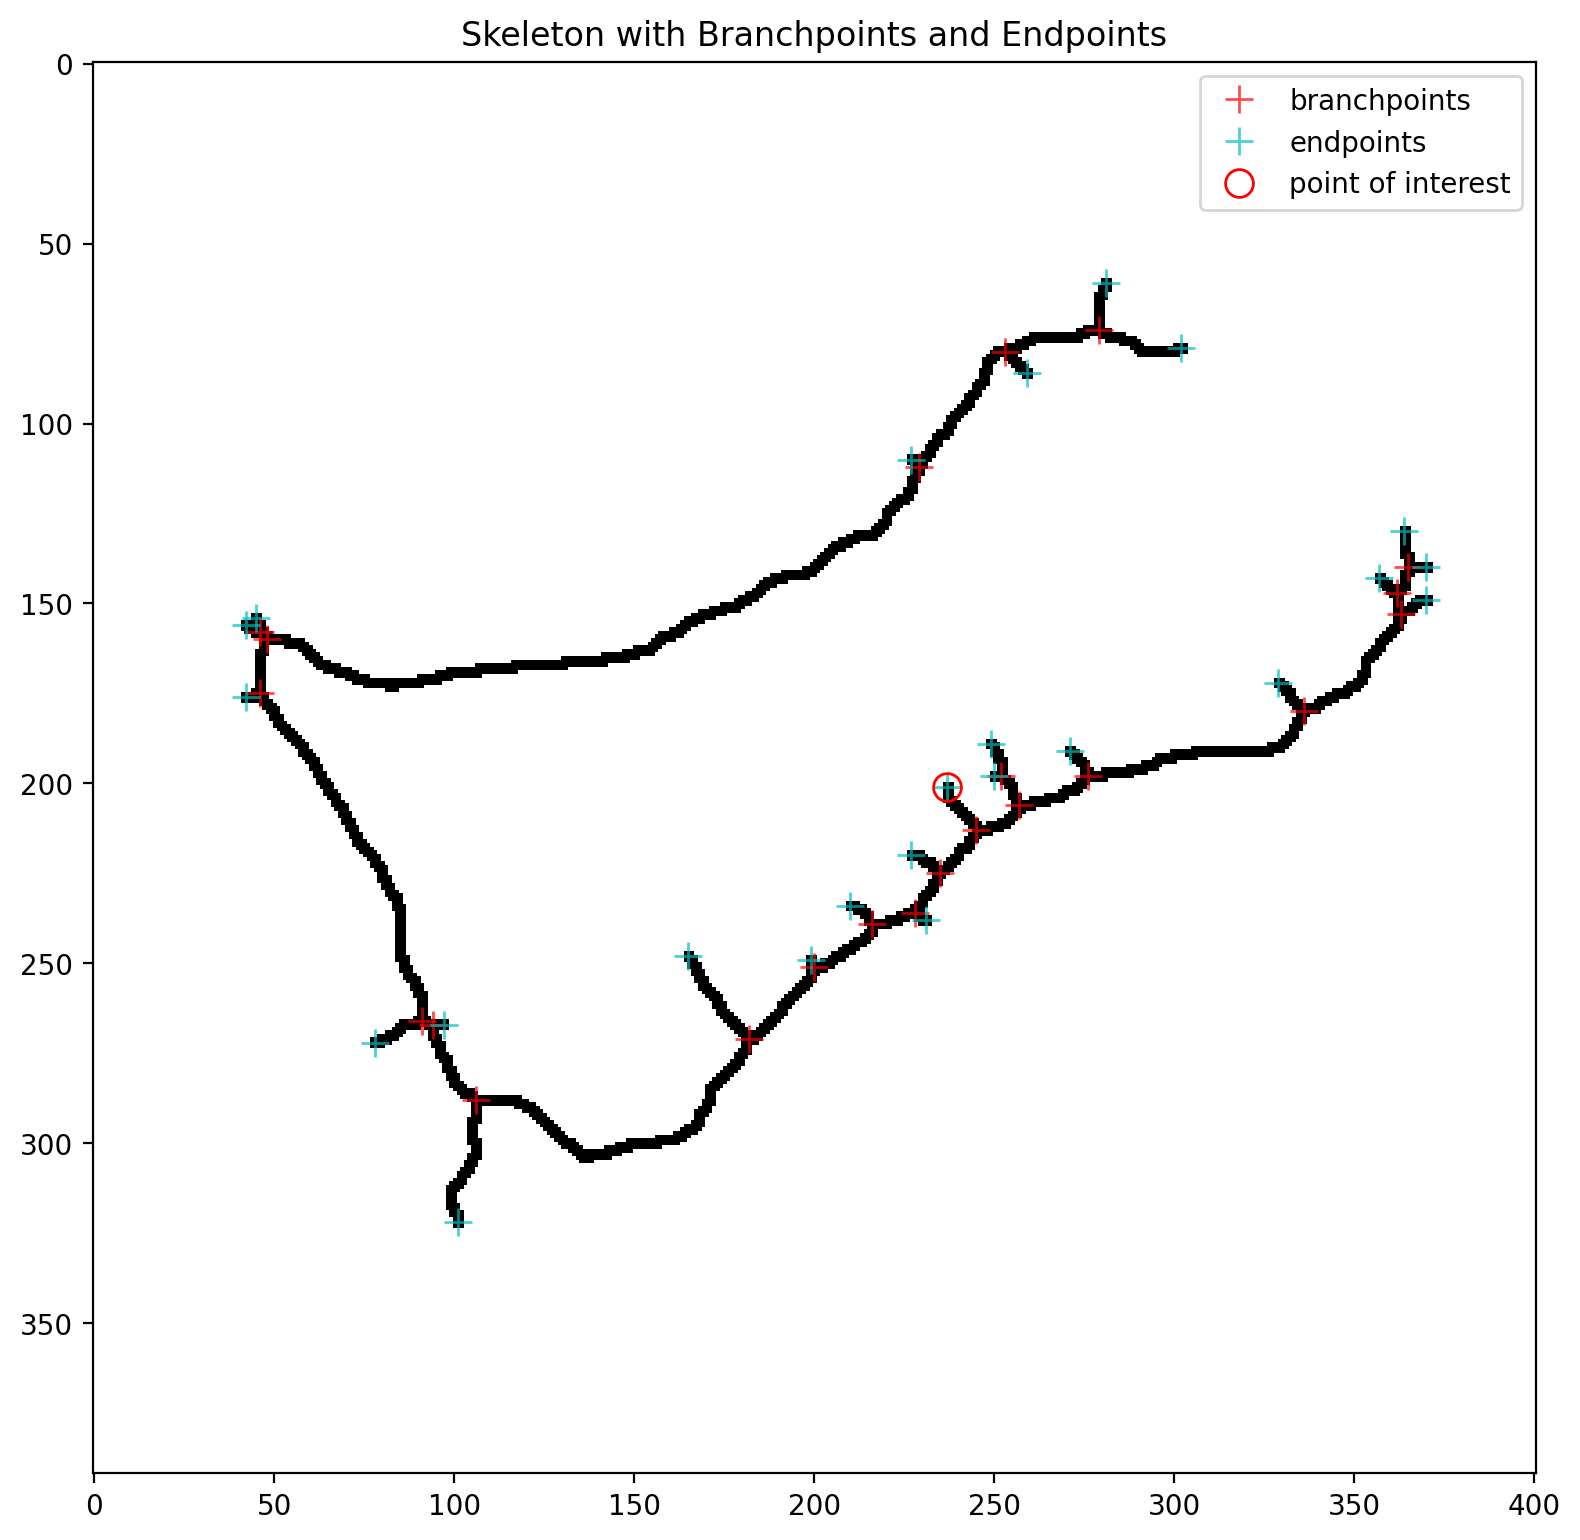

col =  90
k =  15
E location y, x =  (220, 227)


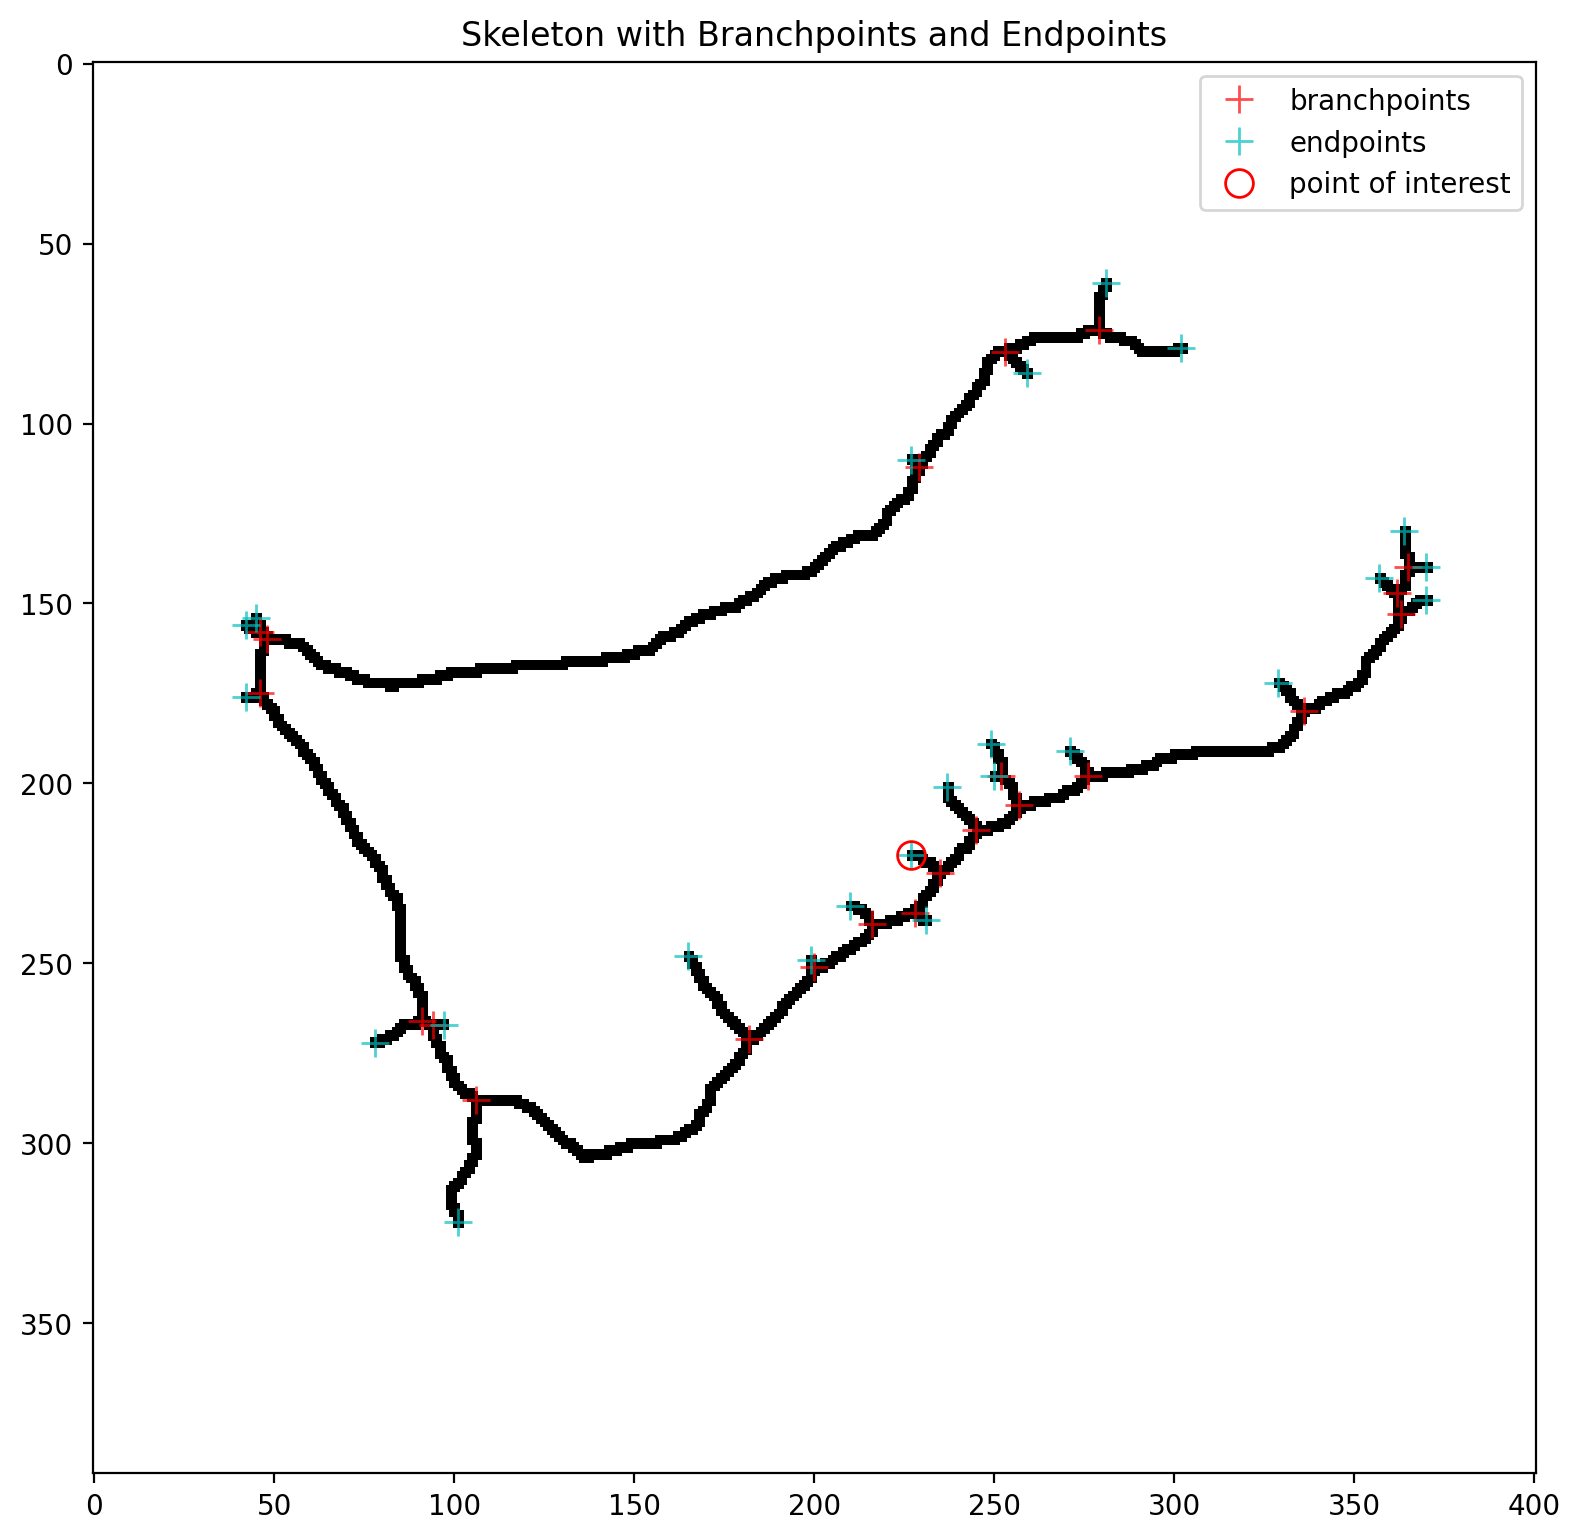

col =  96
k =  16
E location y, x =  (234, 210)


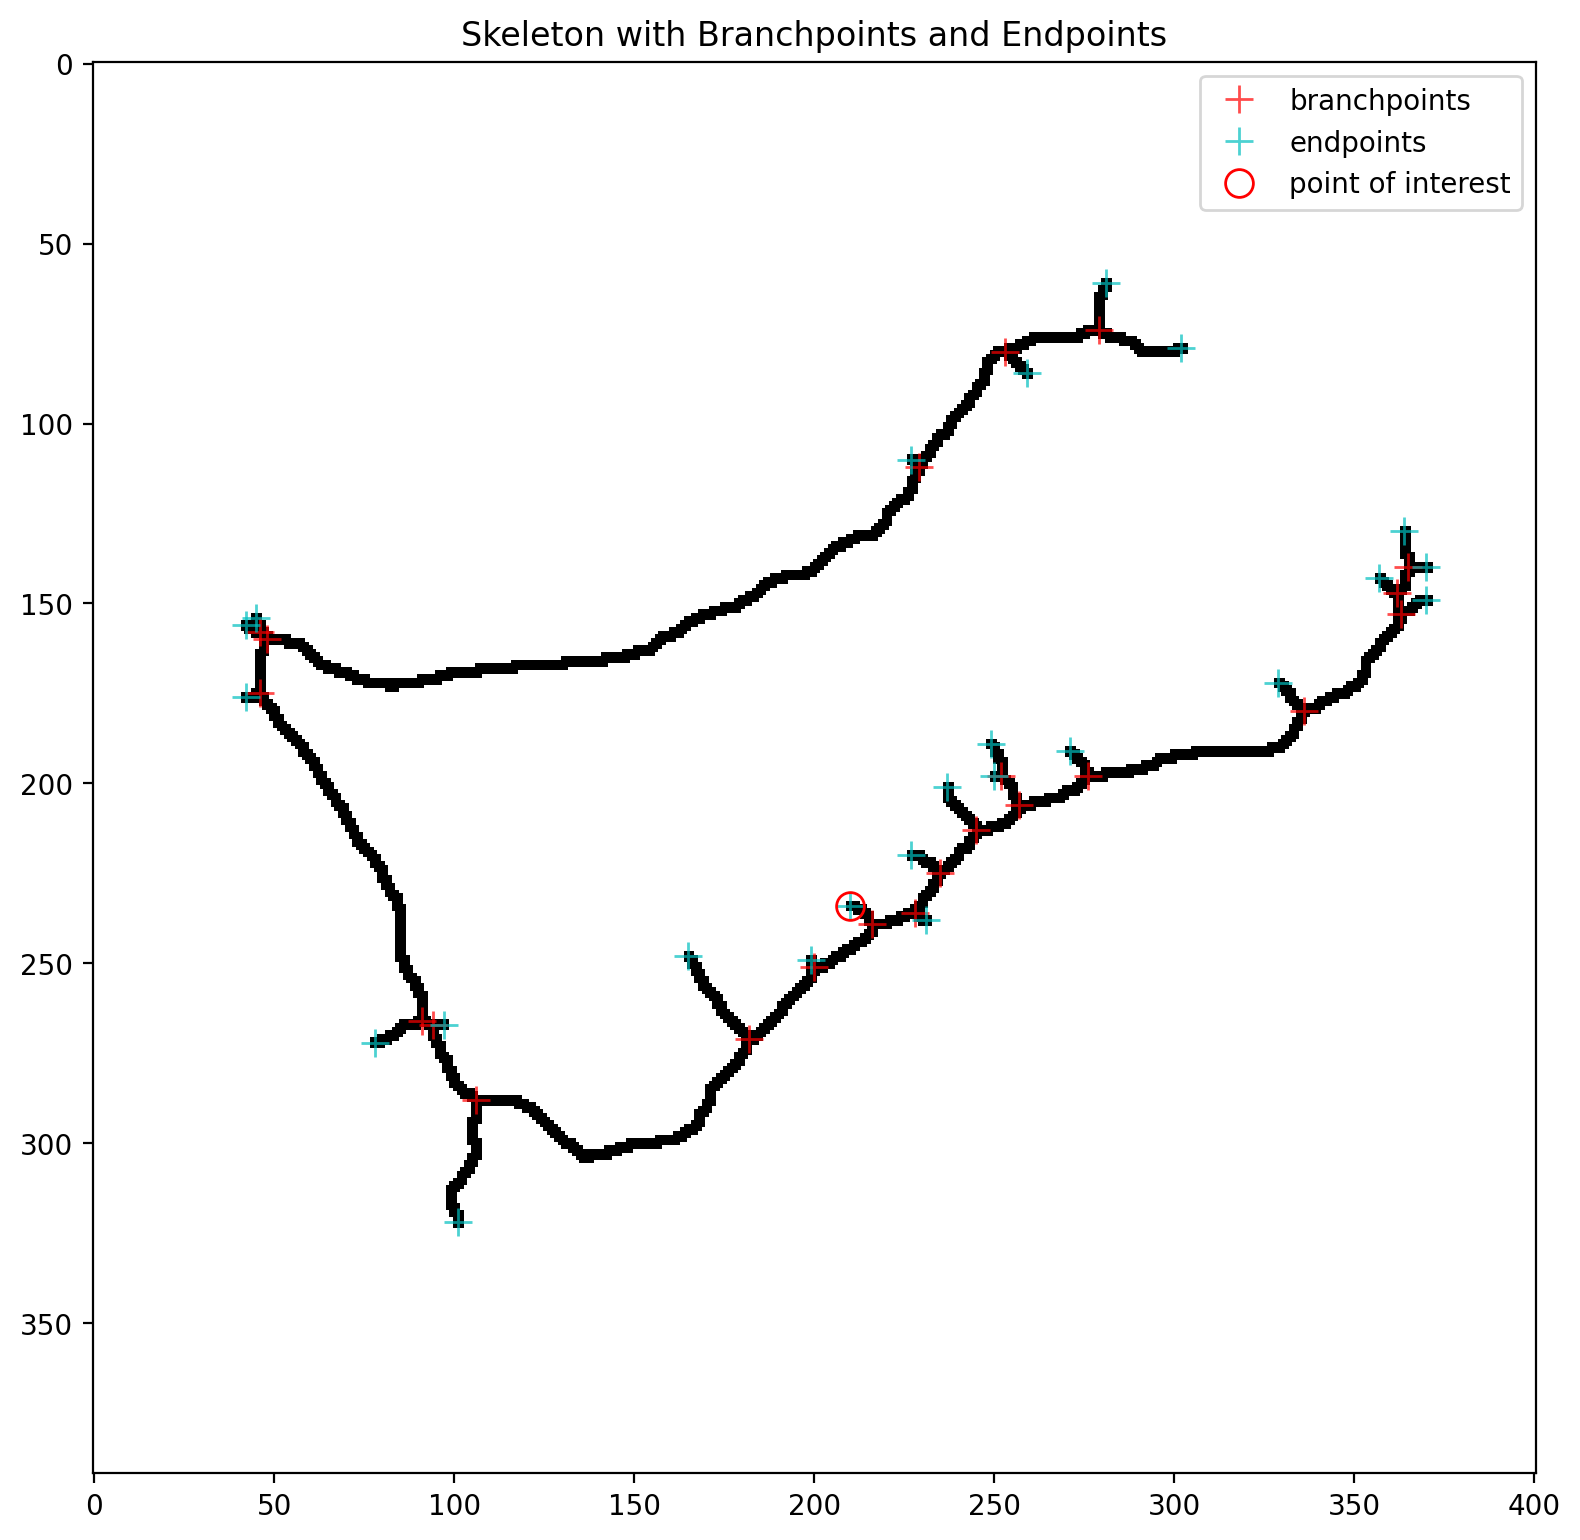

col =  102
k =  17
E location y, x =  (238, 231)


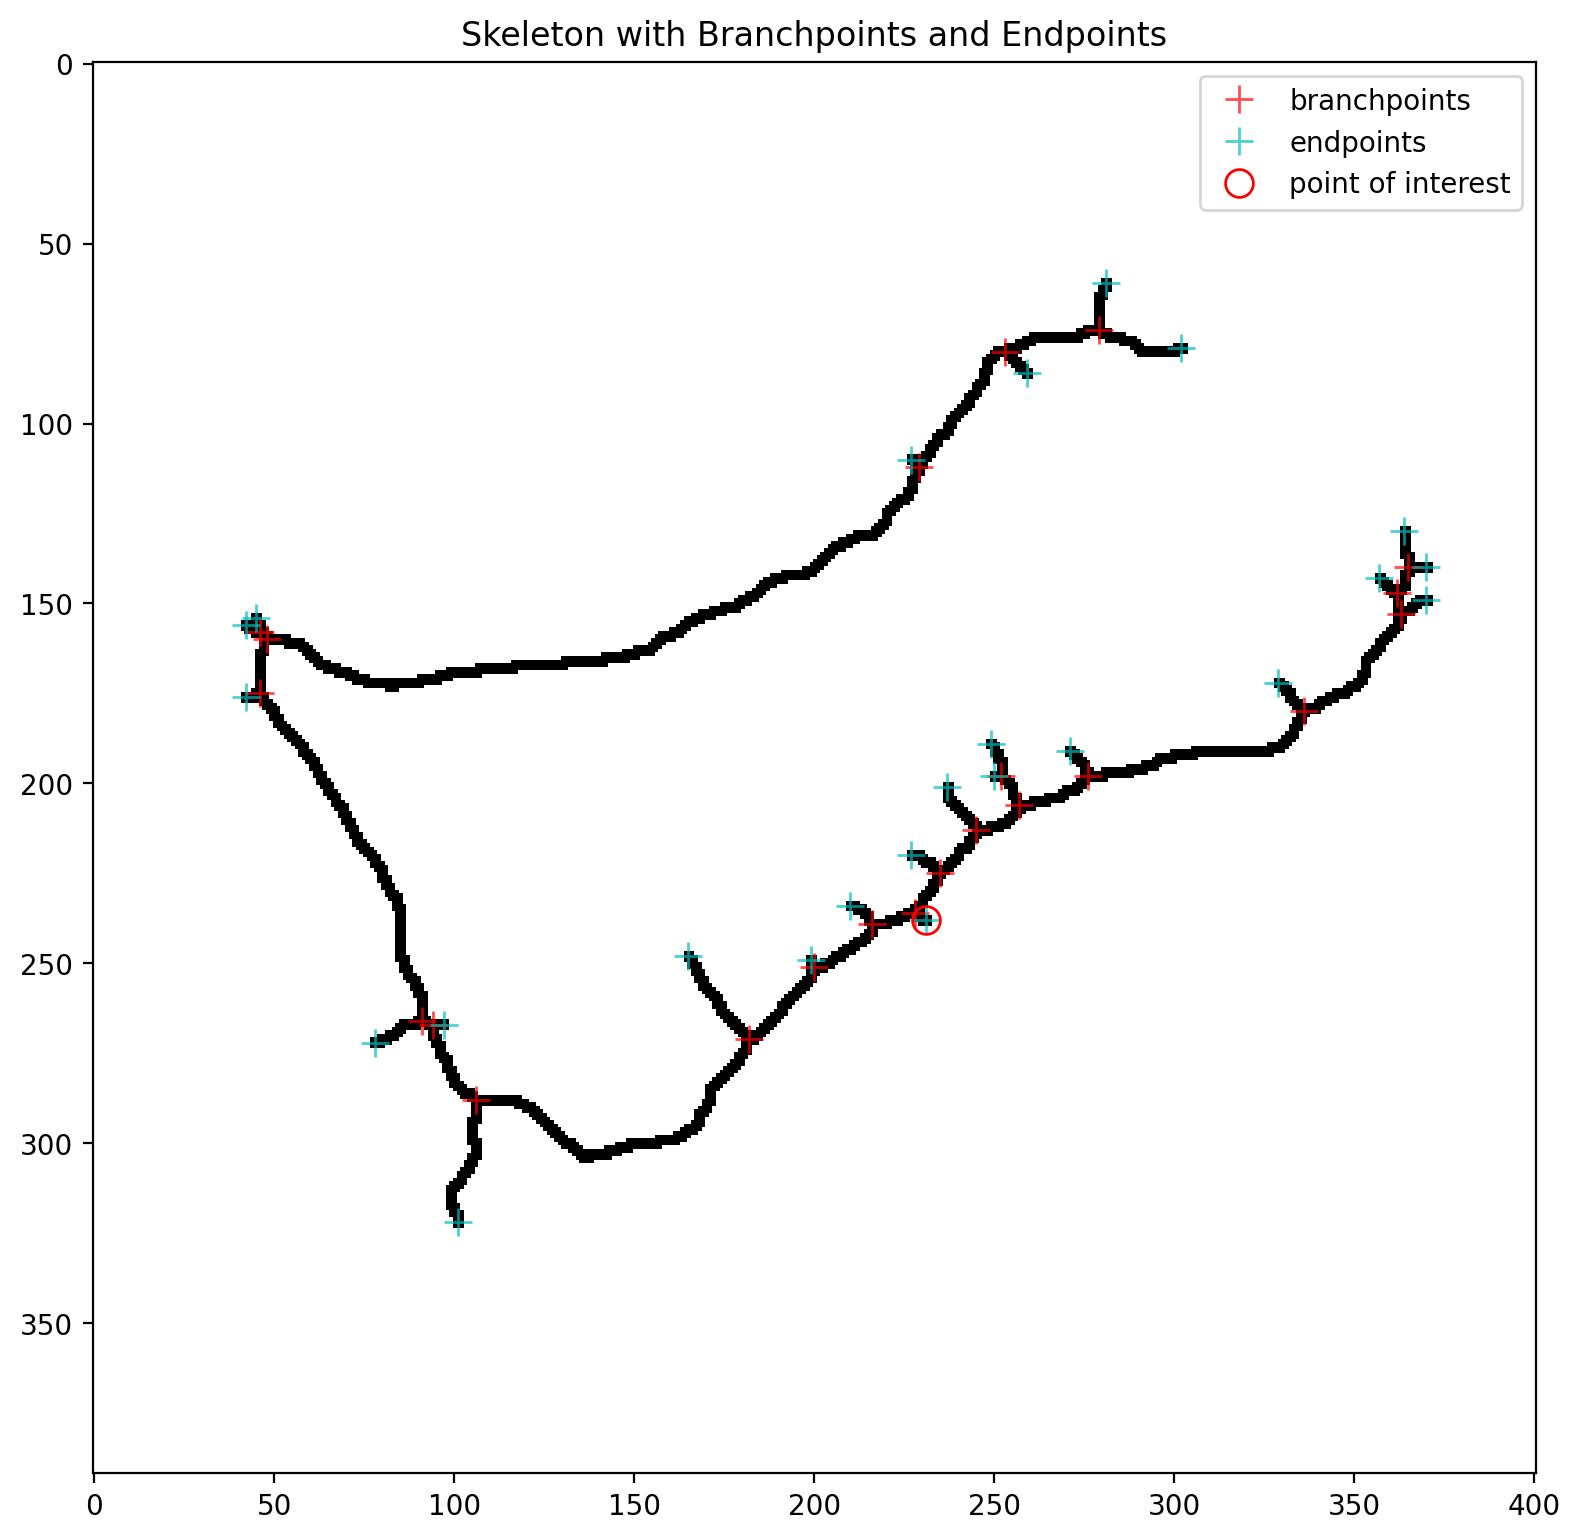

col =  108
k =  18
E location y, x =  (248, 165)


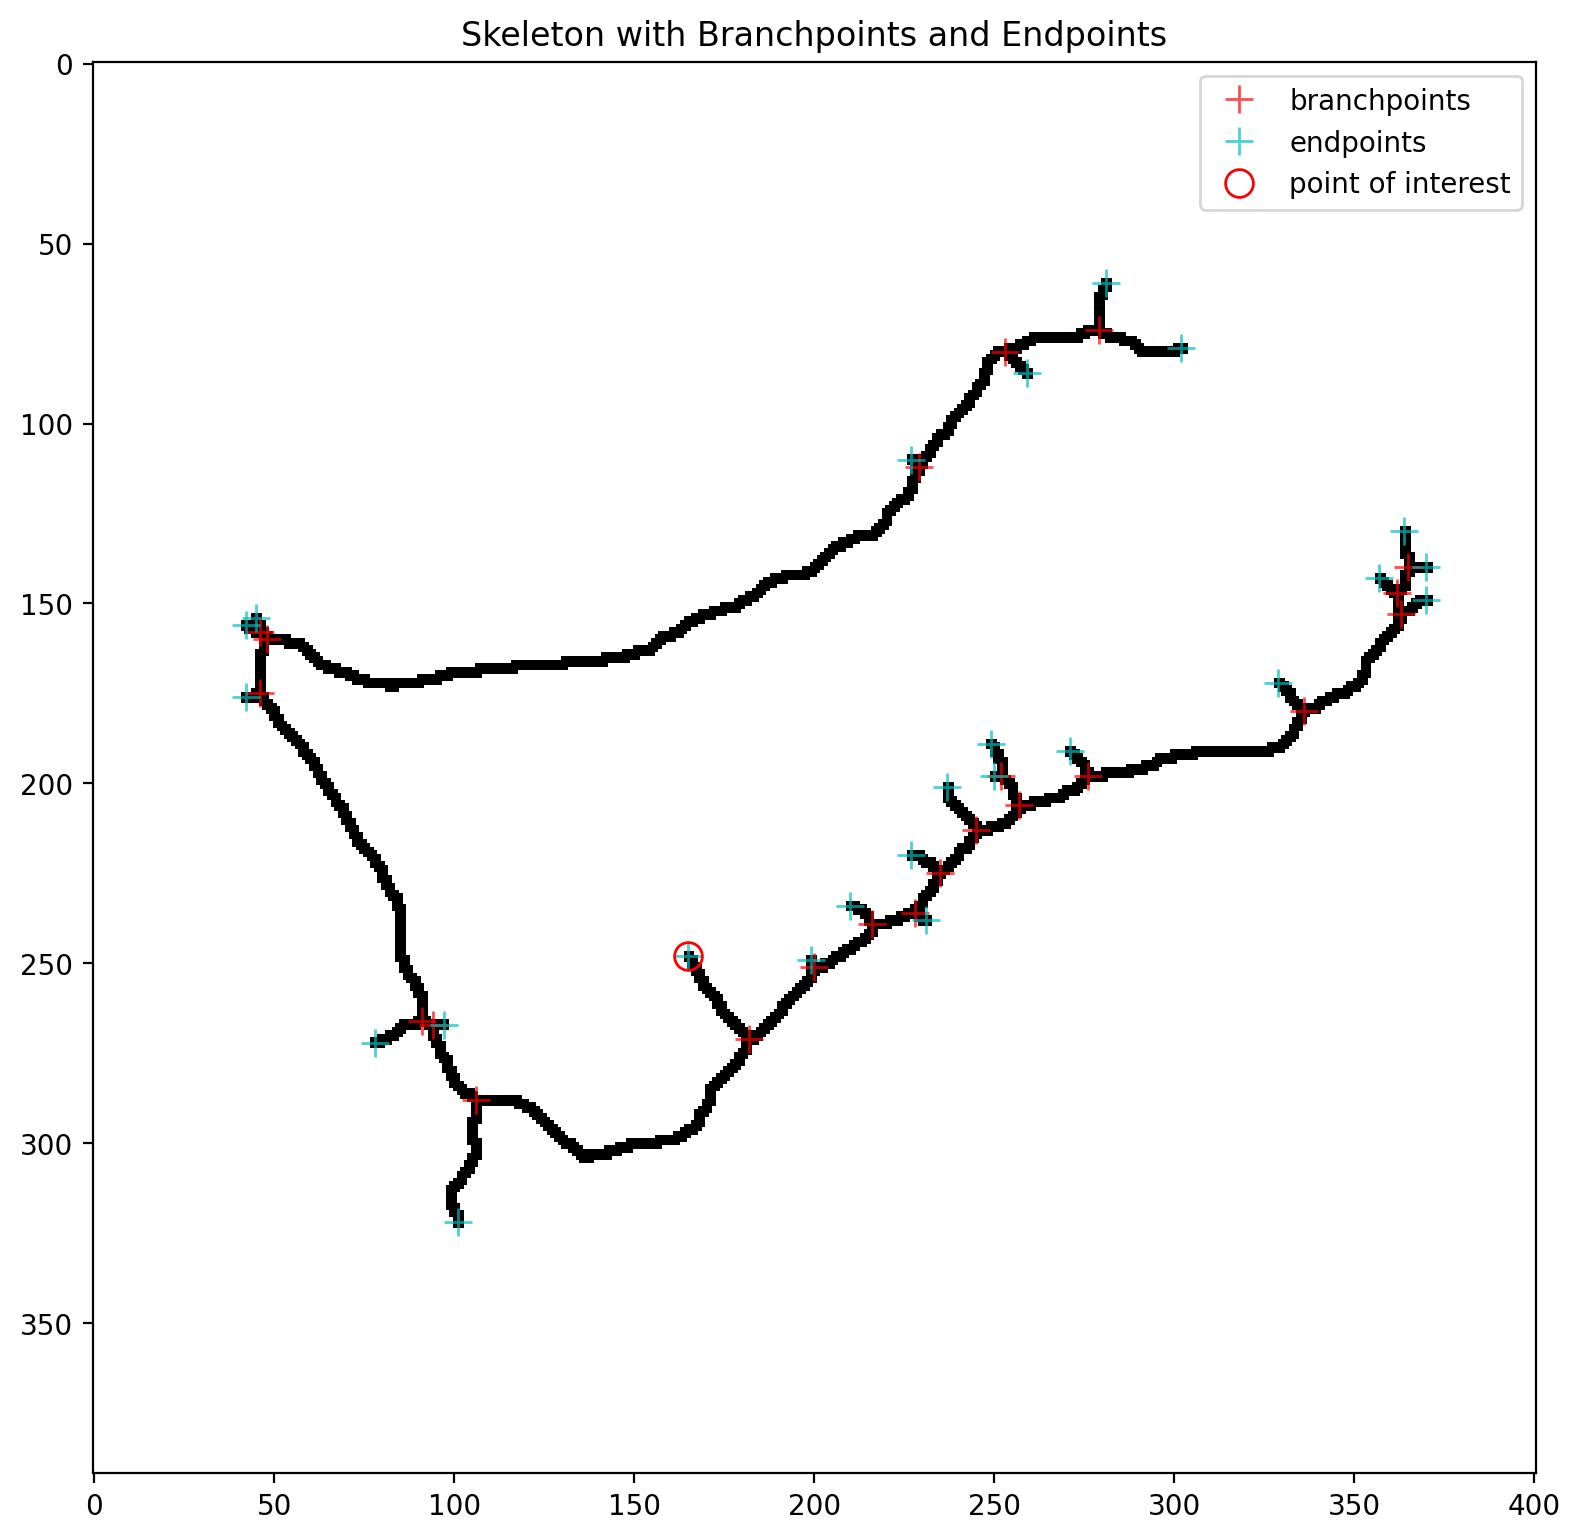

col =  114
k =  19
E location y, x =  (249, 199)


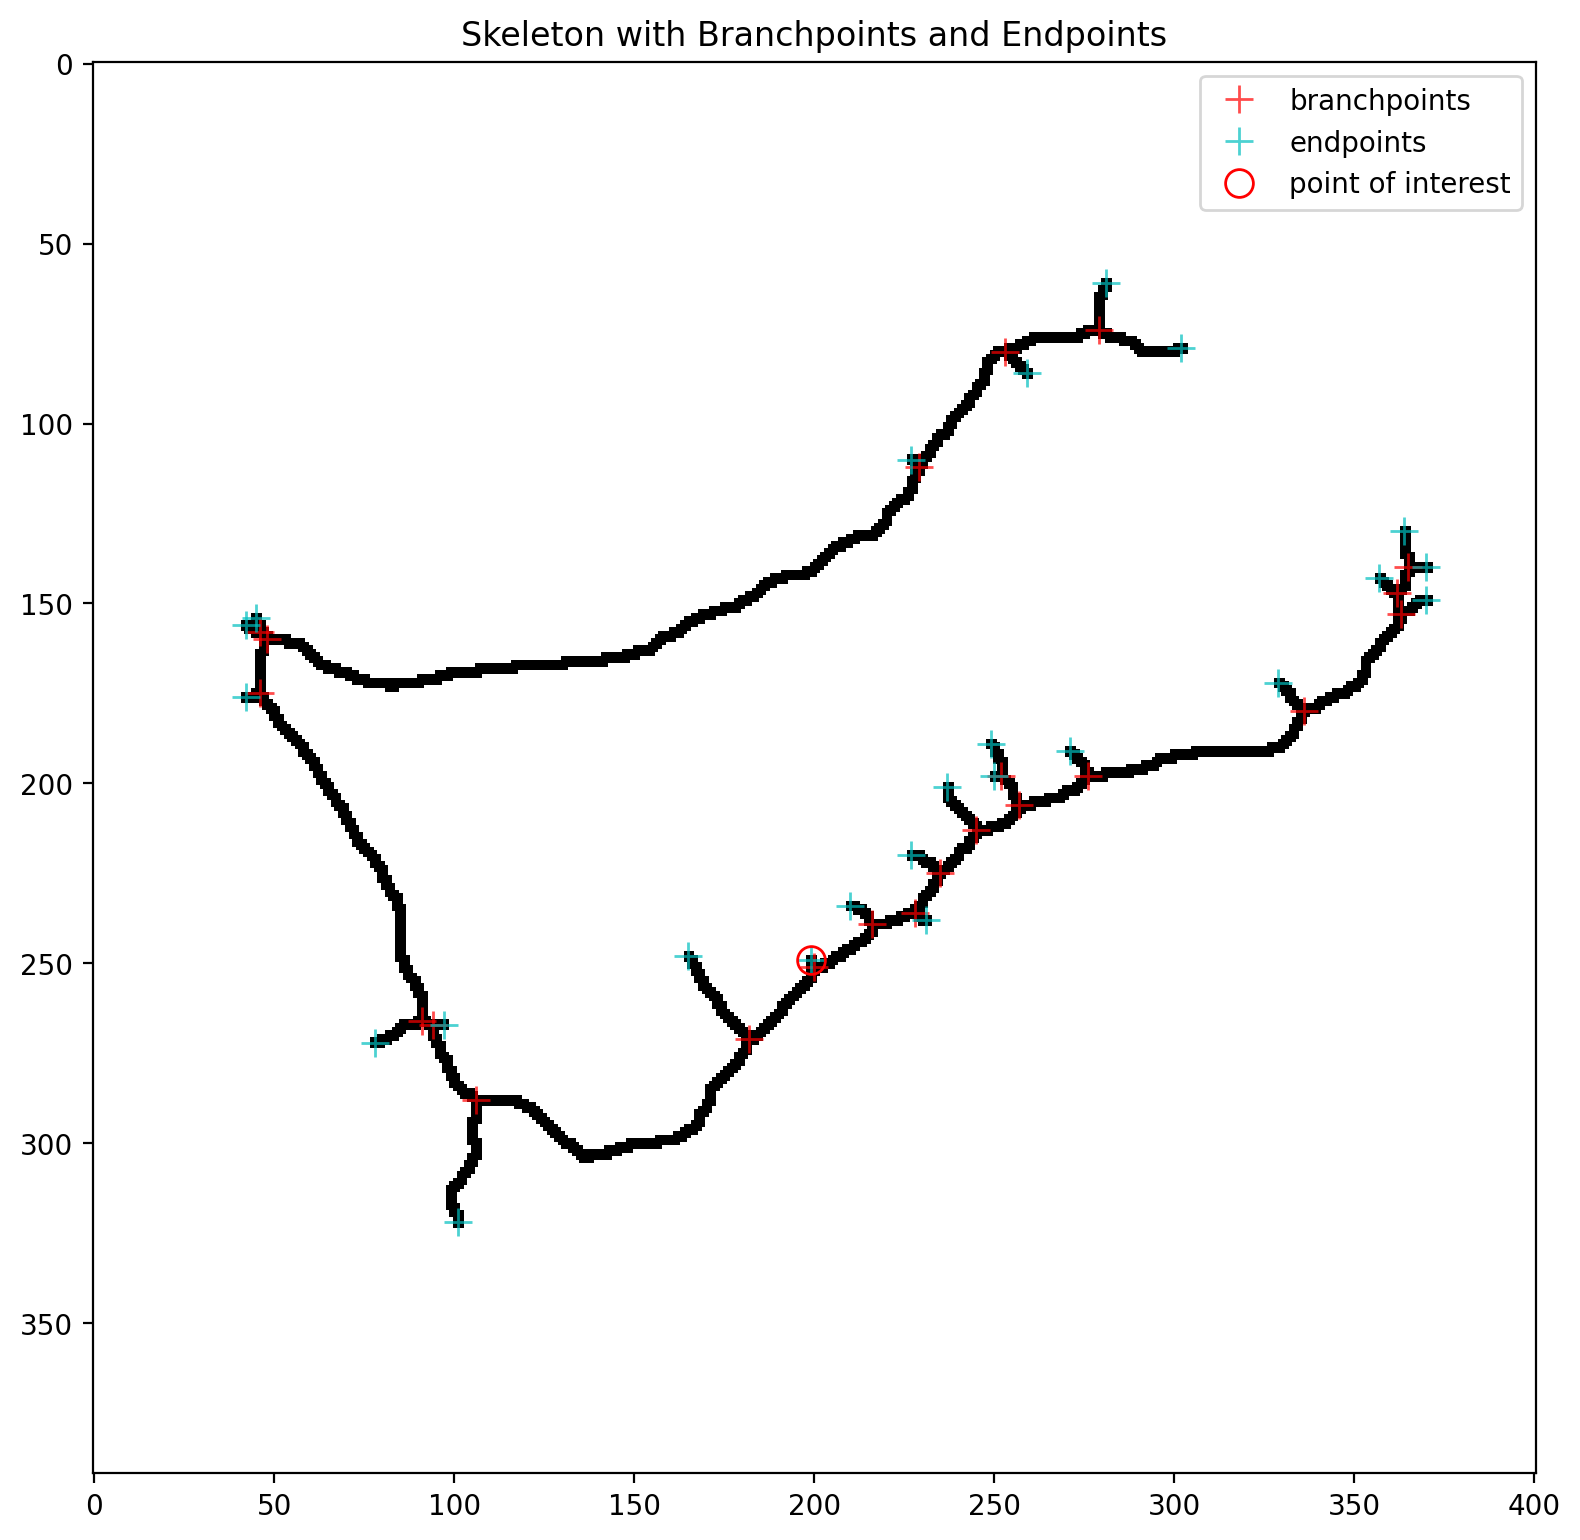

col =  120
k =  20
E location y, x =  (267, 97)


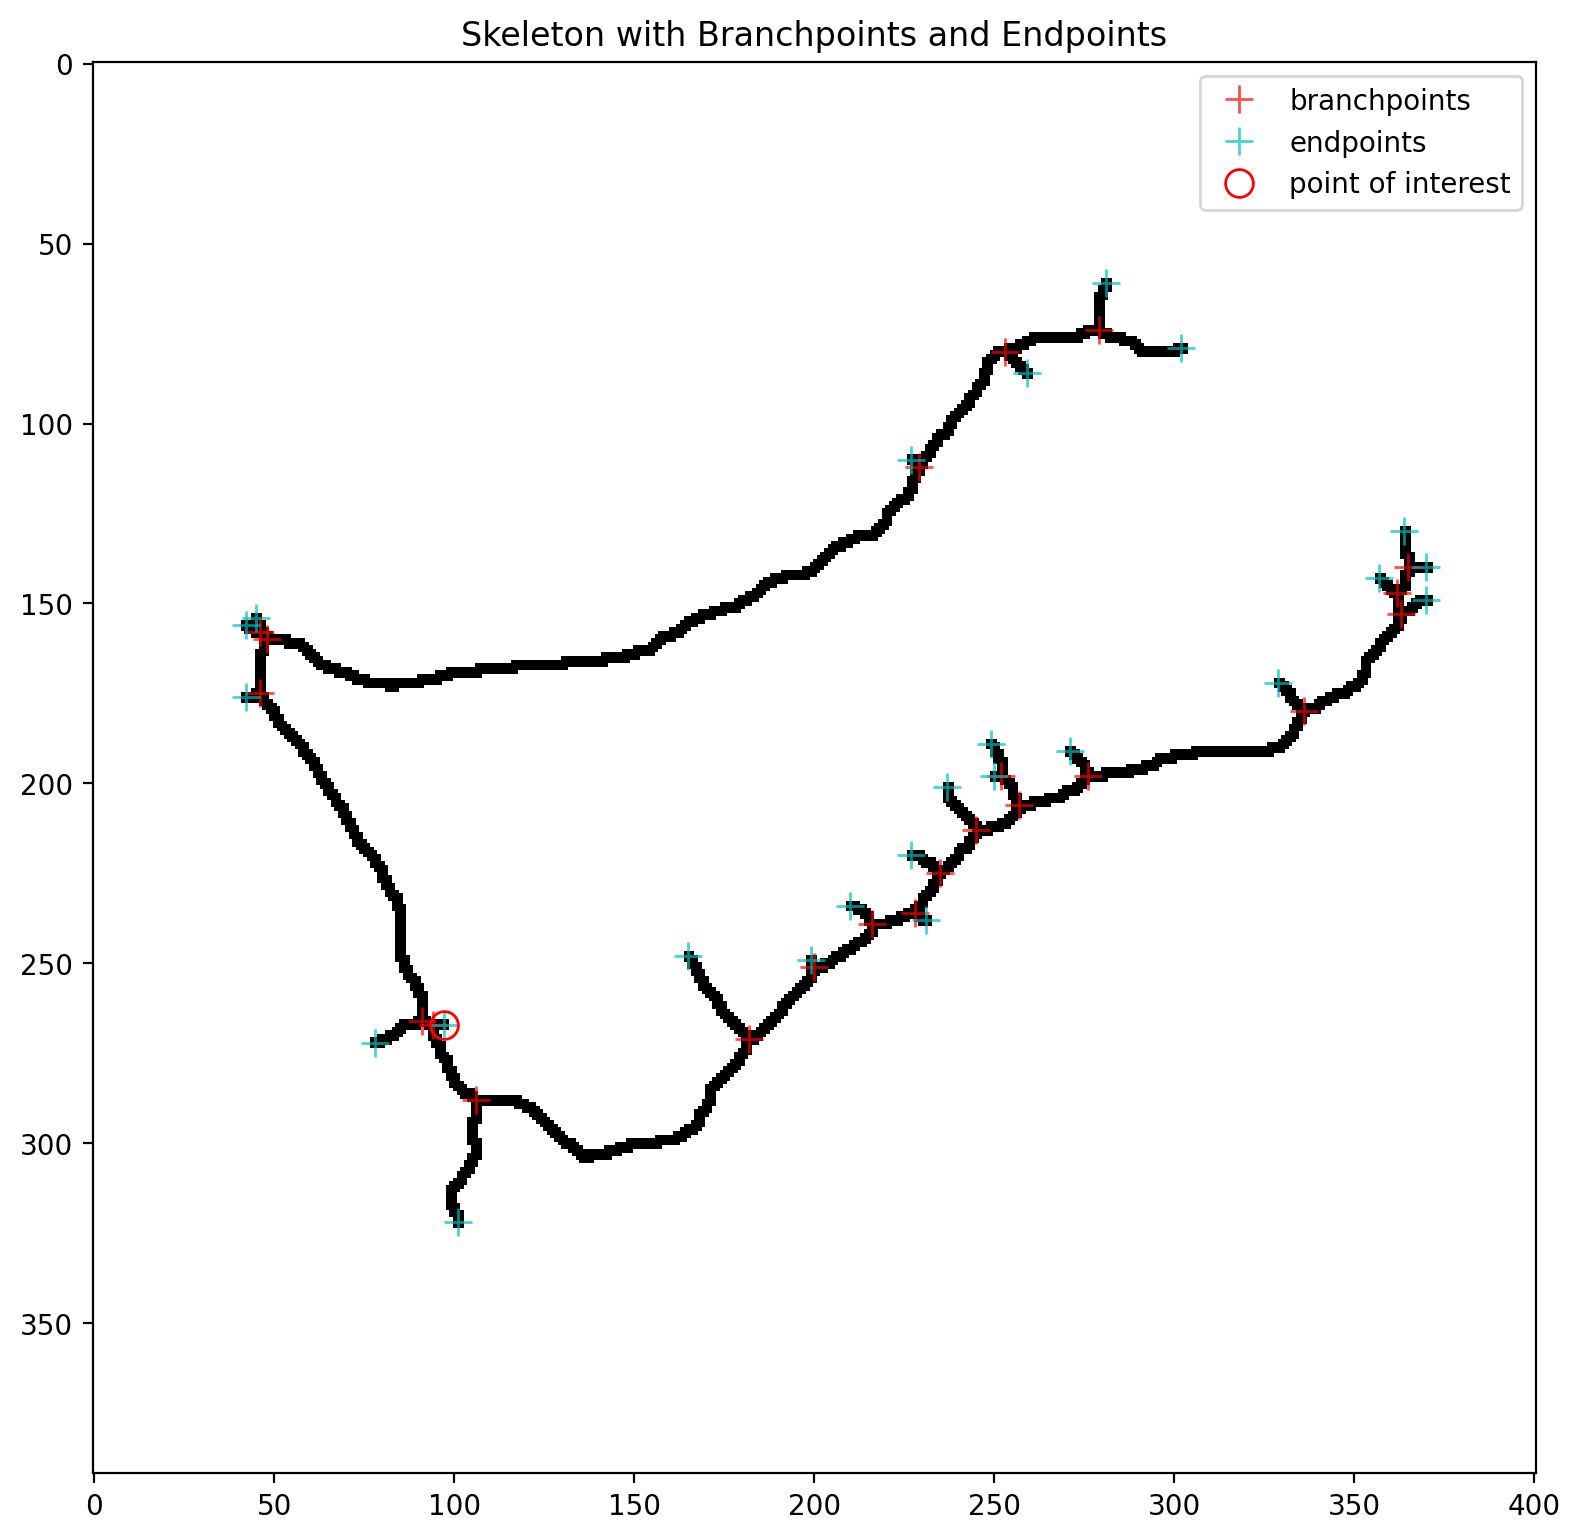

col =  126
k =  21
E location y, x =  (272, 78)


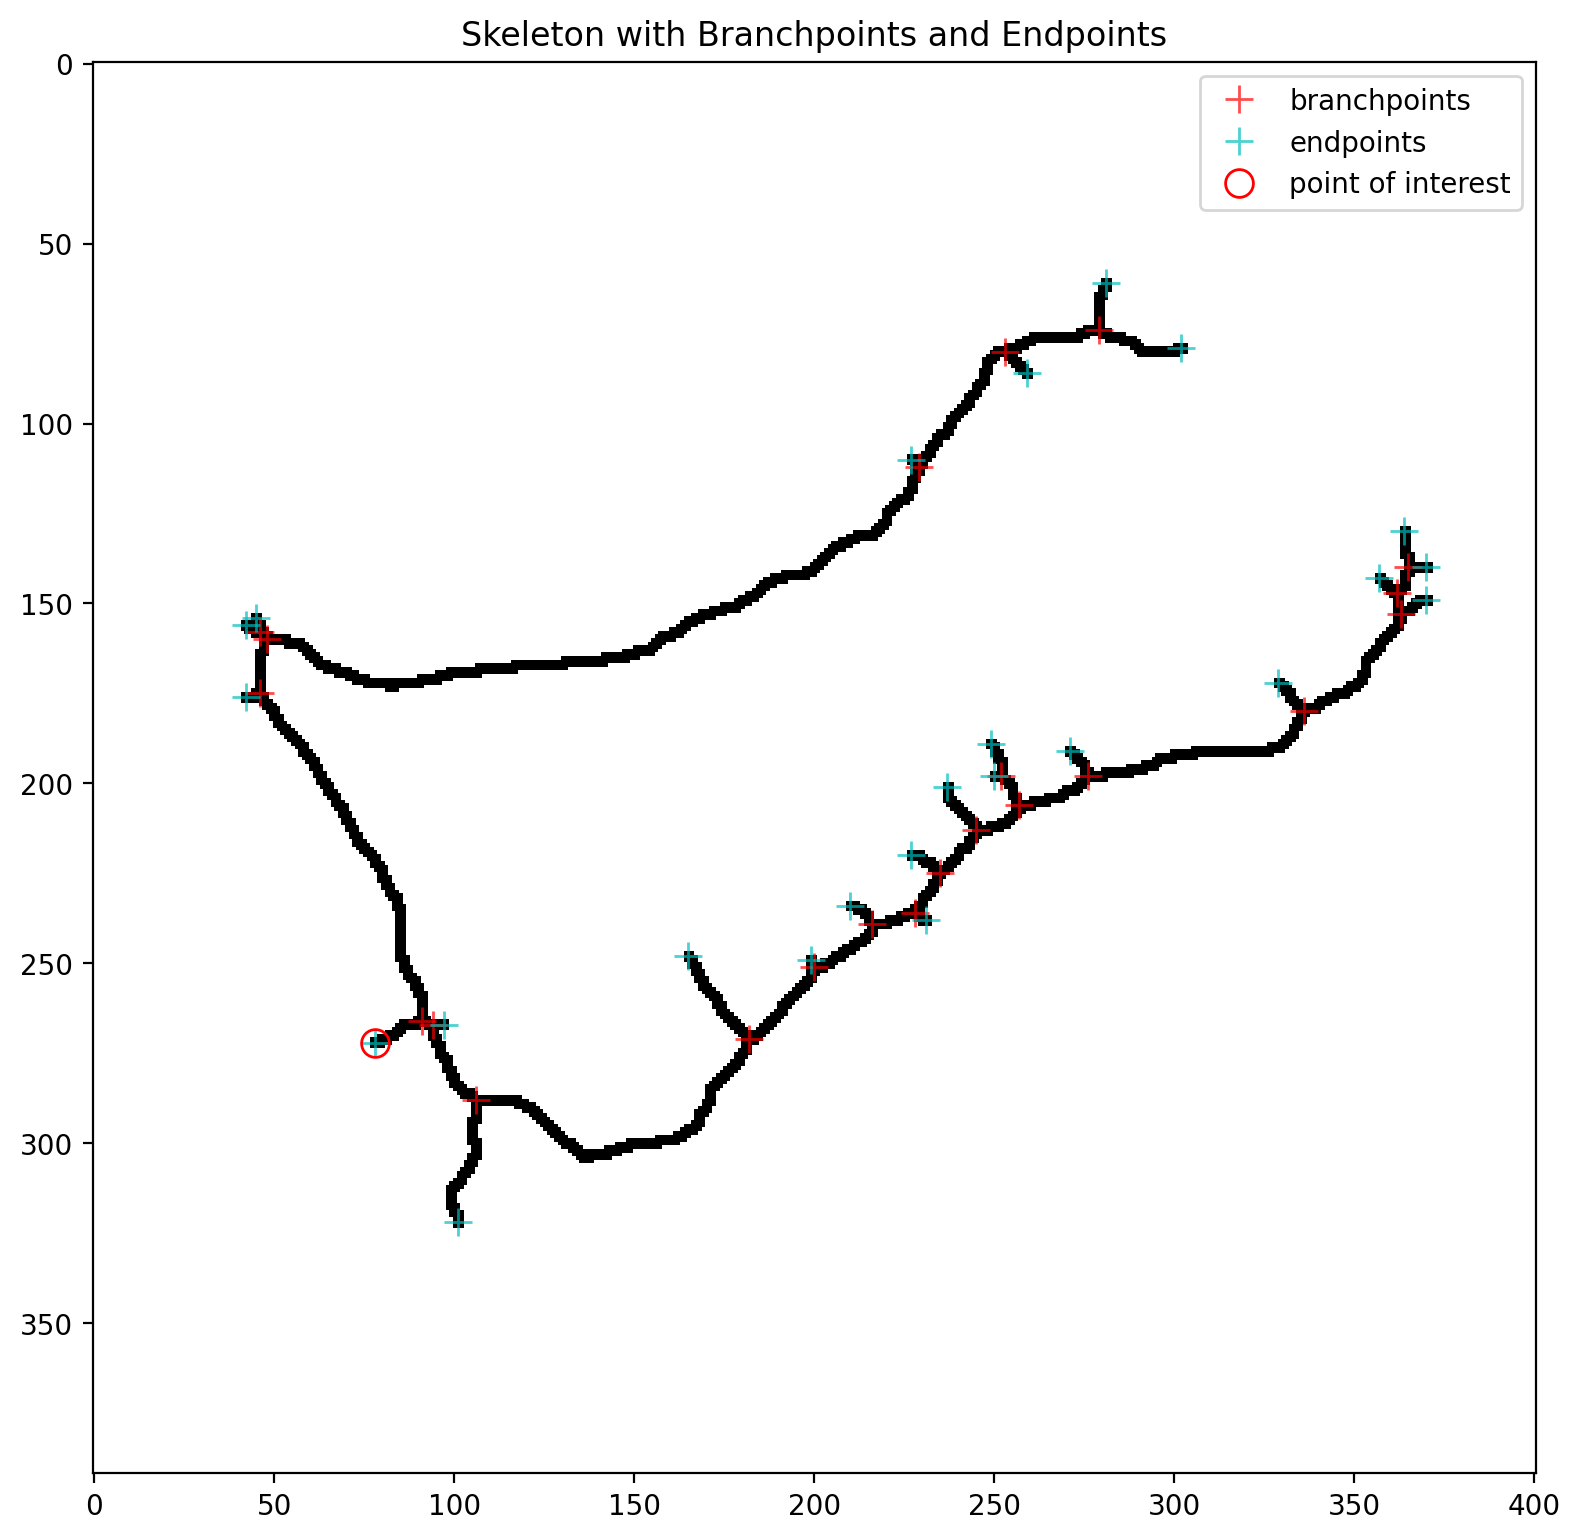

col =  132
k =  22
E location y, x =  (322, 101)


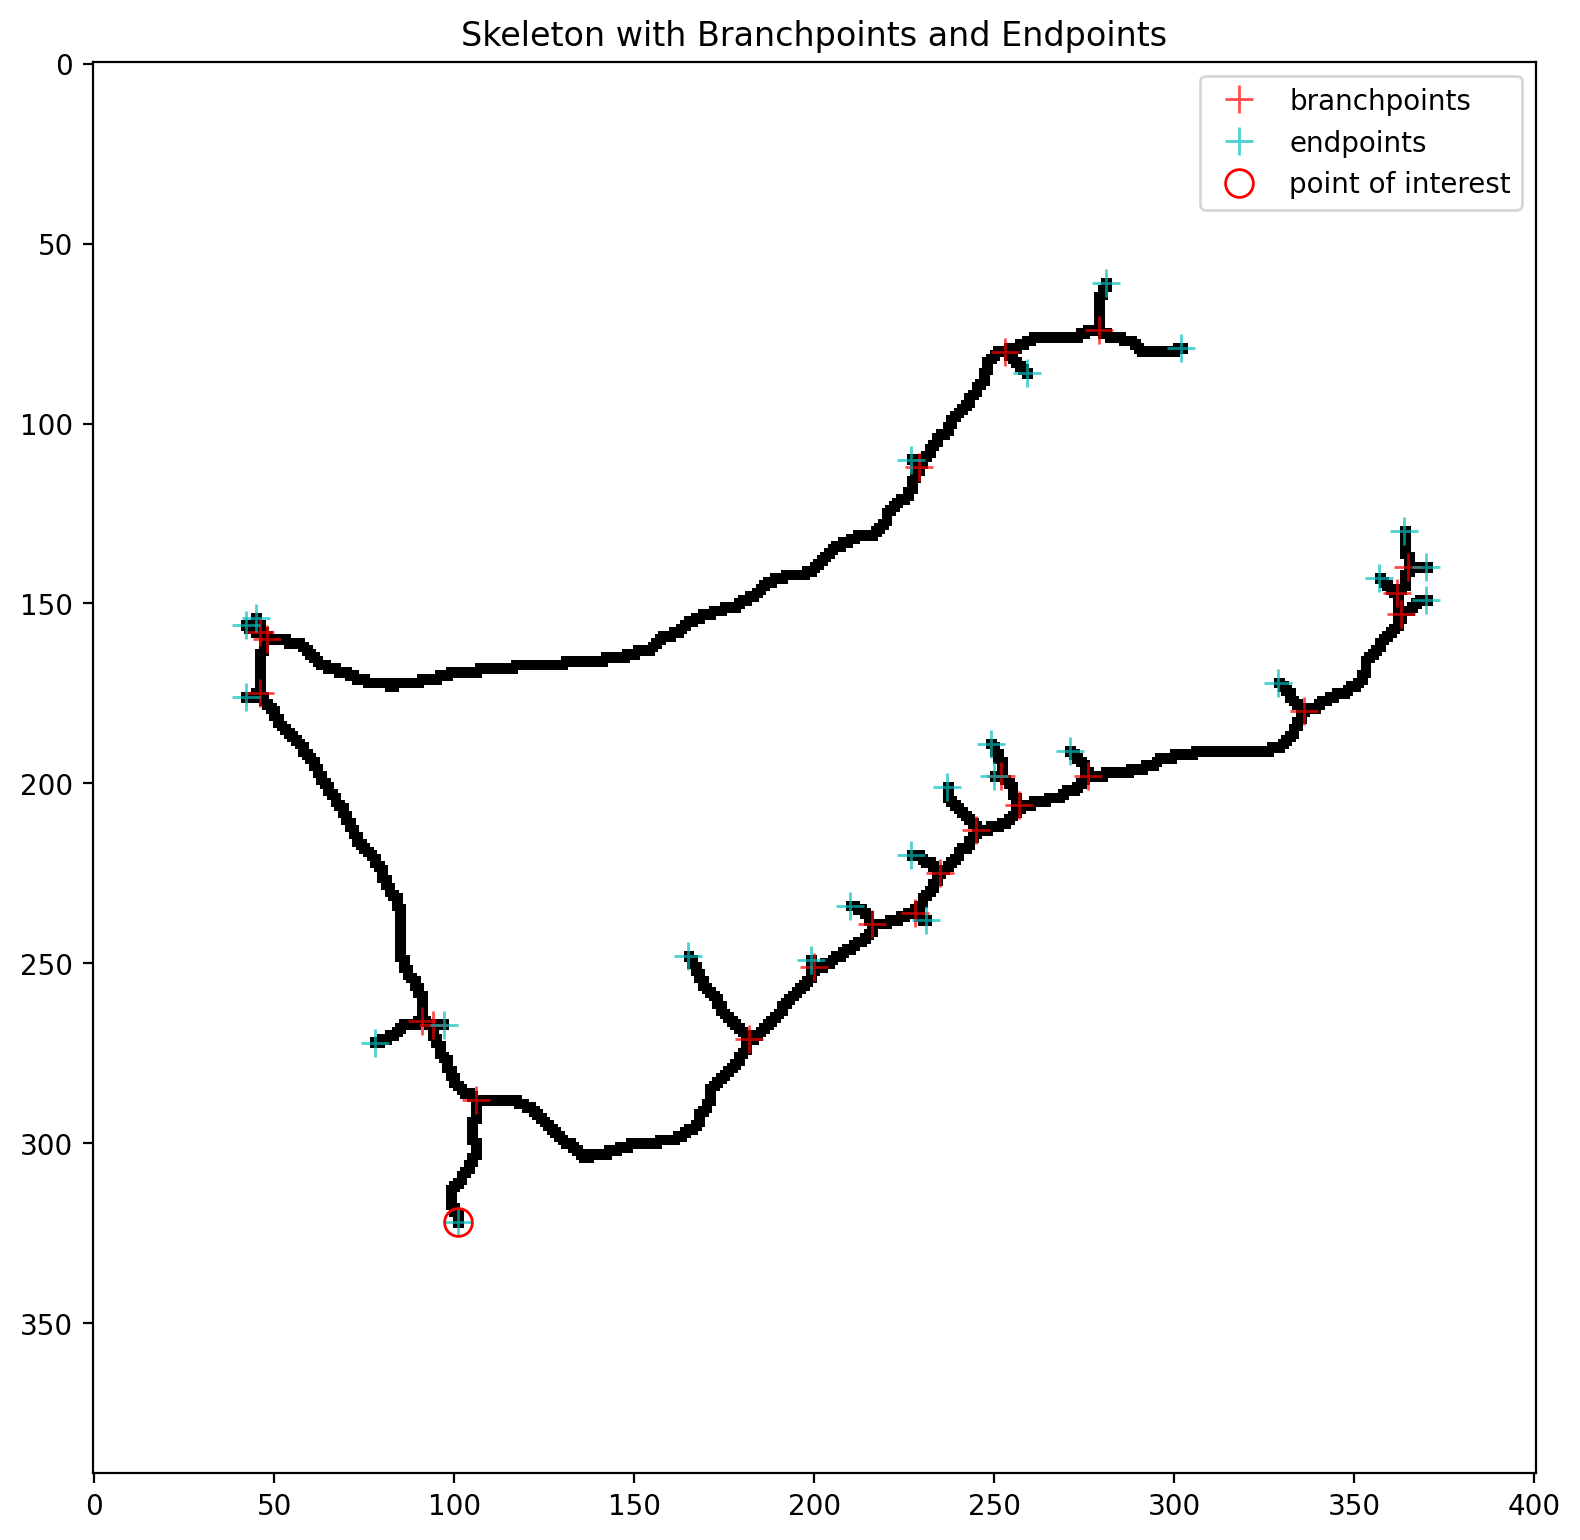

col =  138
while 1/4, Iteration 2: 3 endpoints remaining
order i =  2
col =  0
k =  0
E location y, x =  (74, 279)


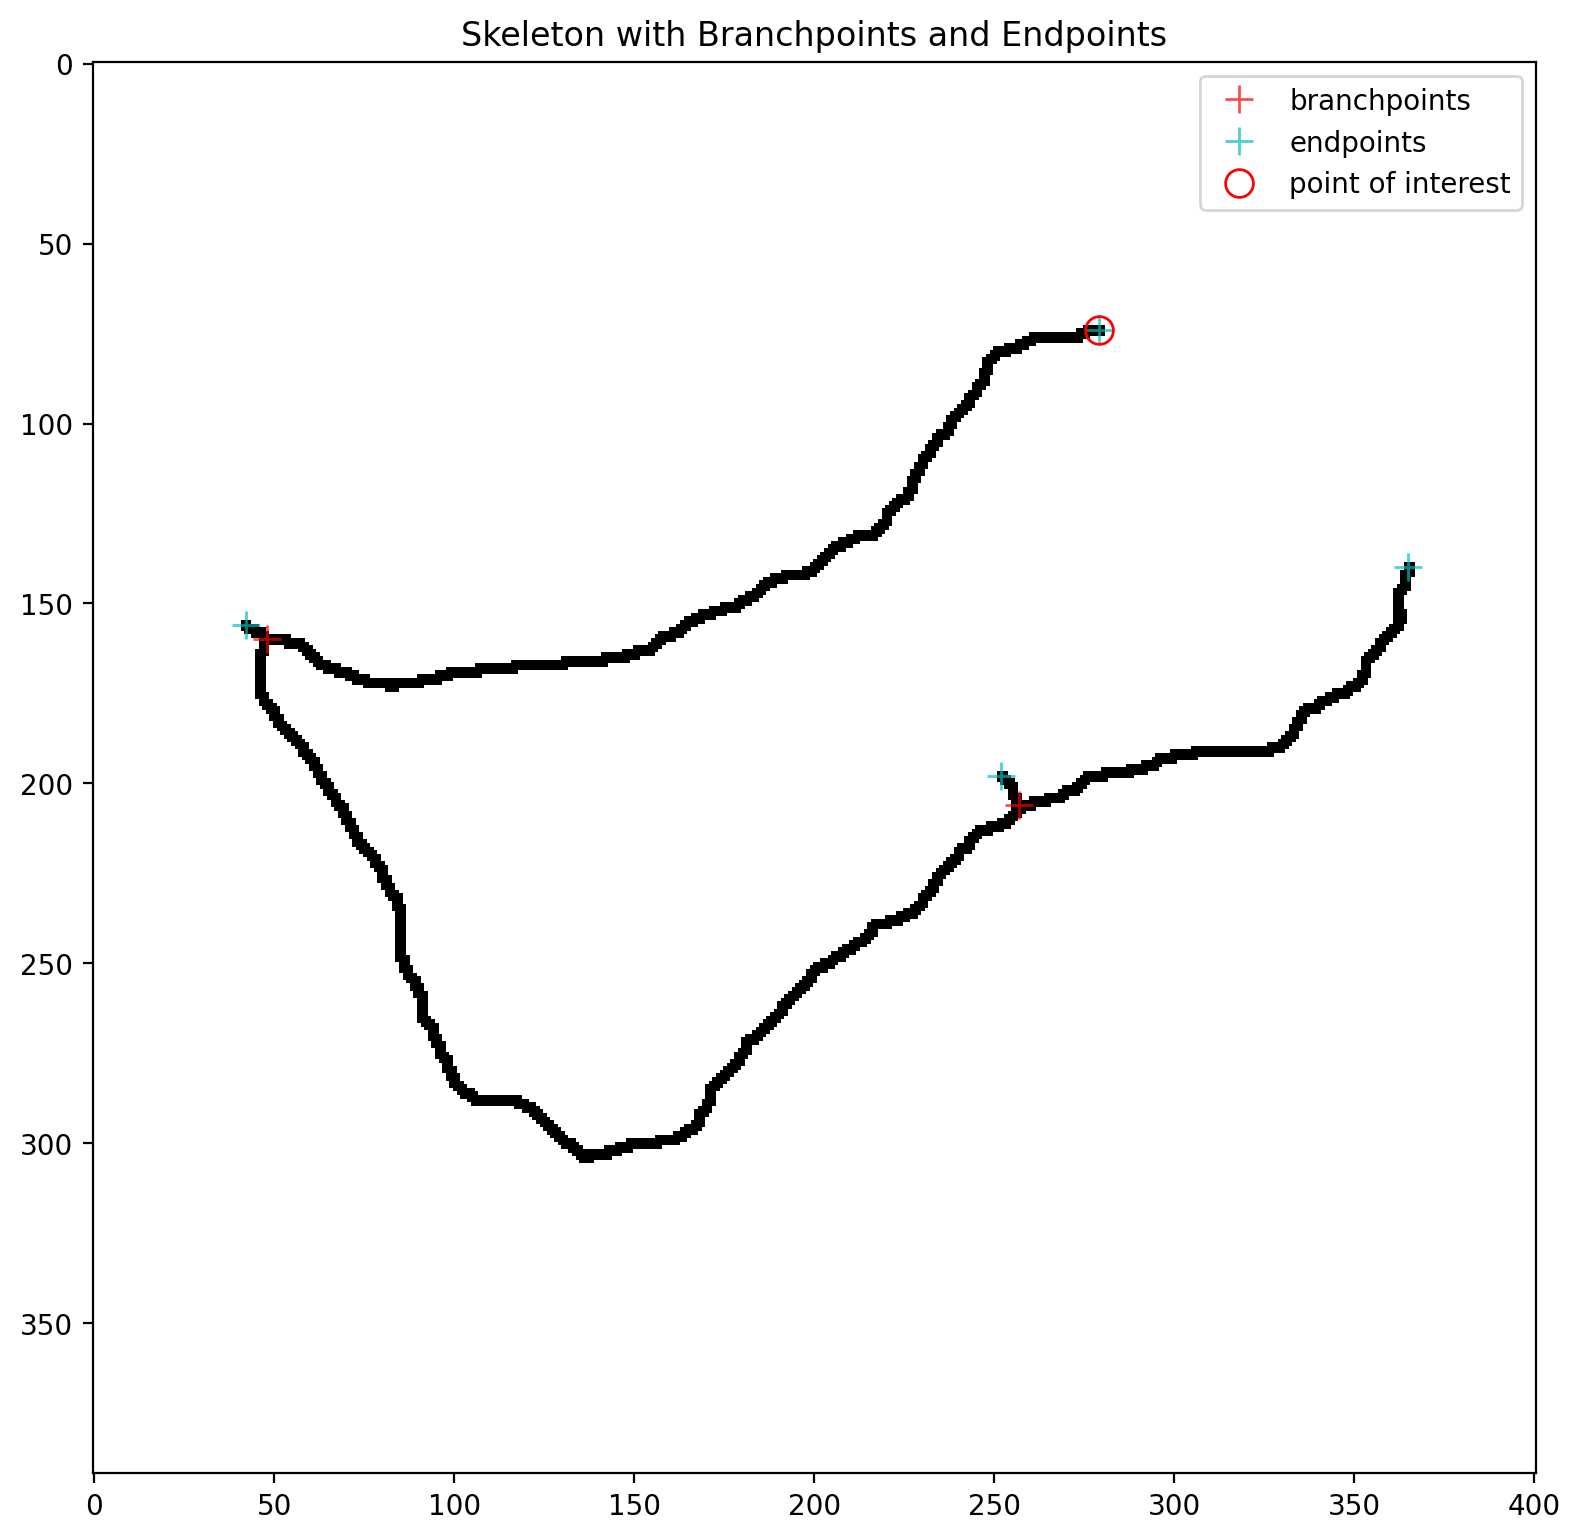

col =  6
k =  1
E location y, x =  (140, 365)


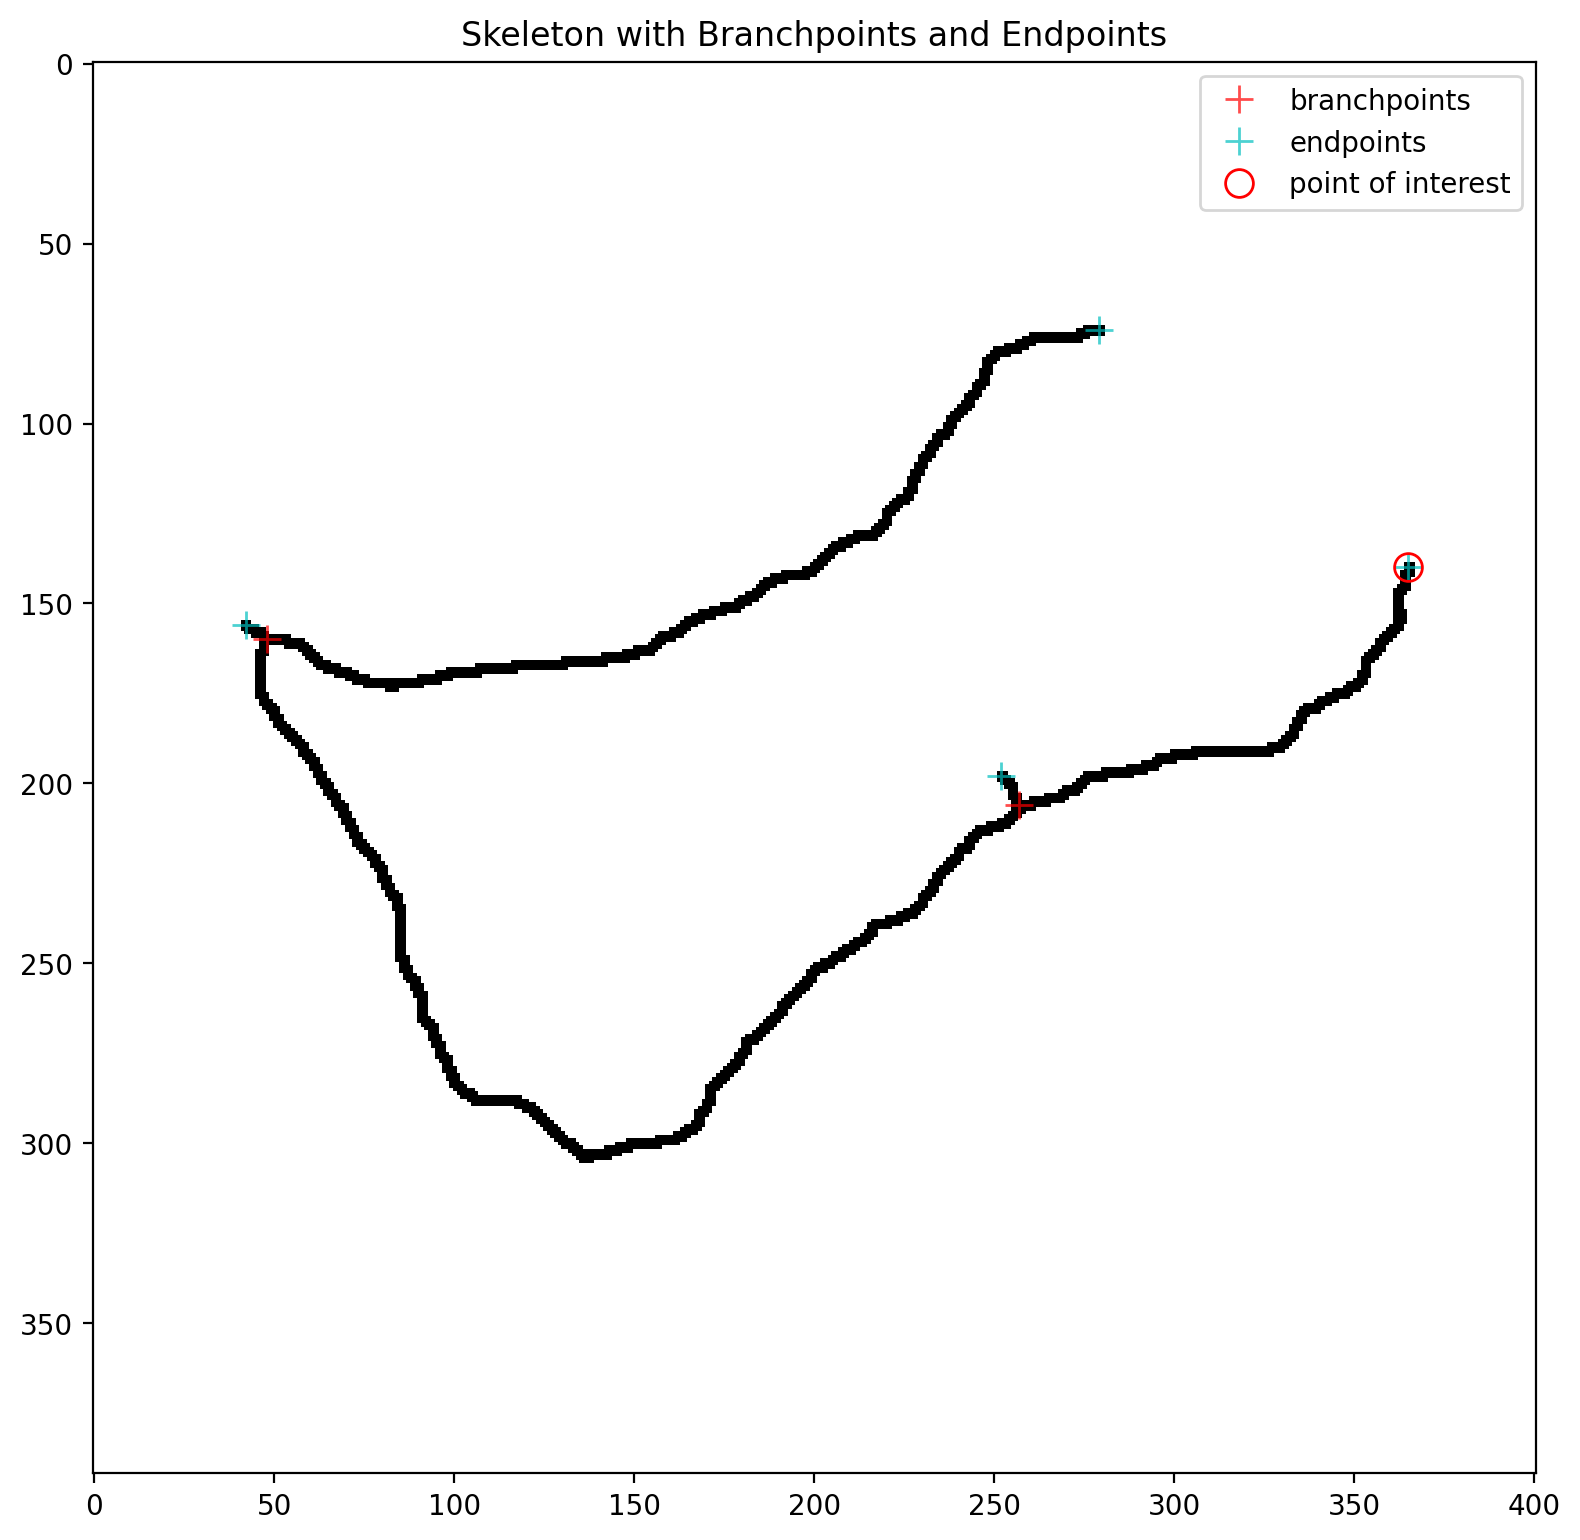

col =  12
k =  2
E location y, x =  (198, 252)


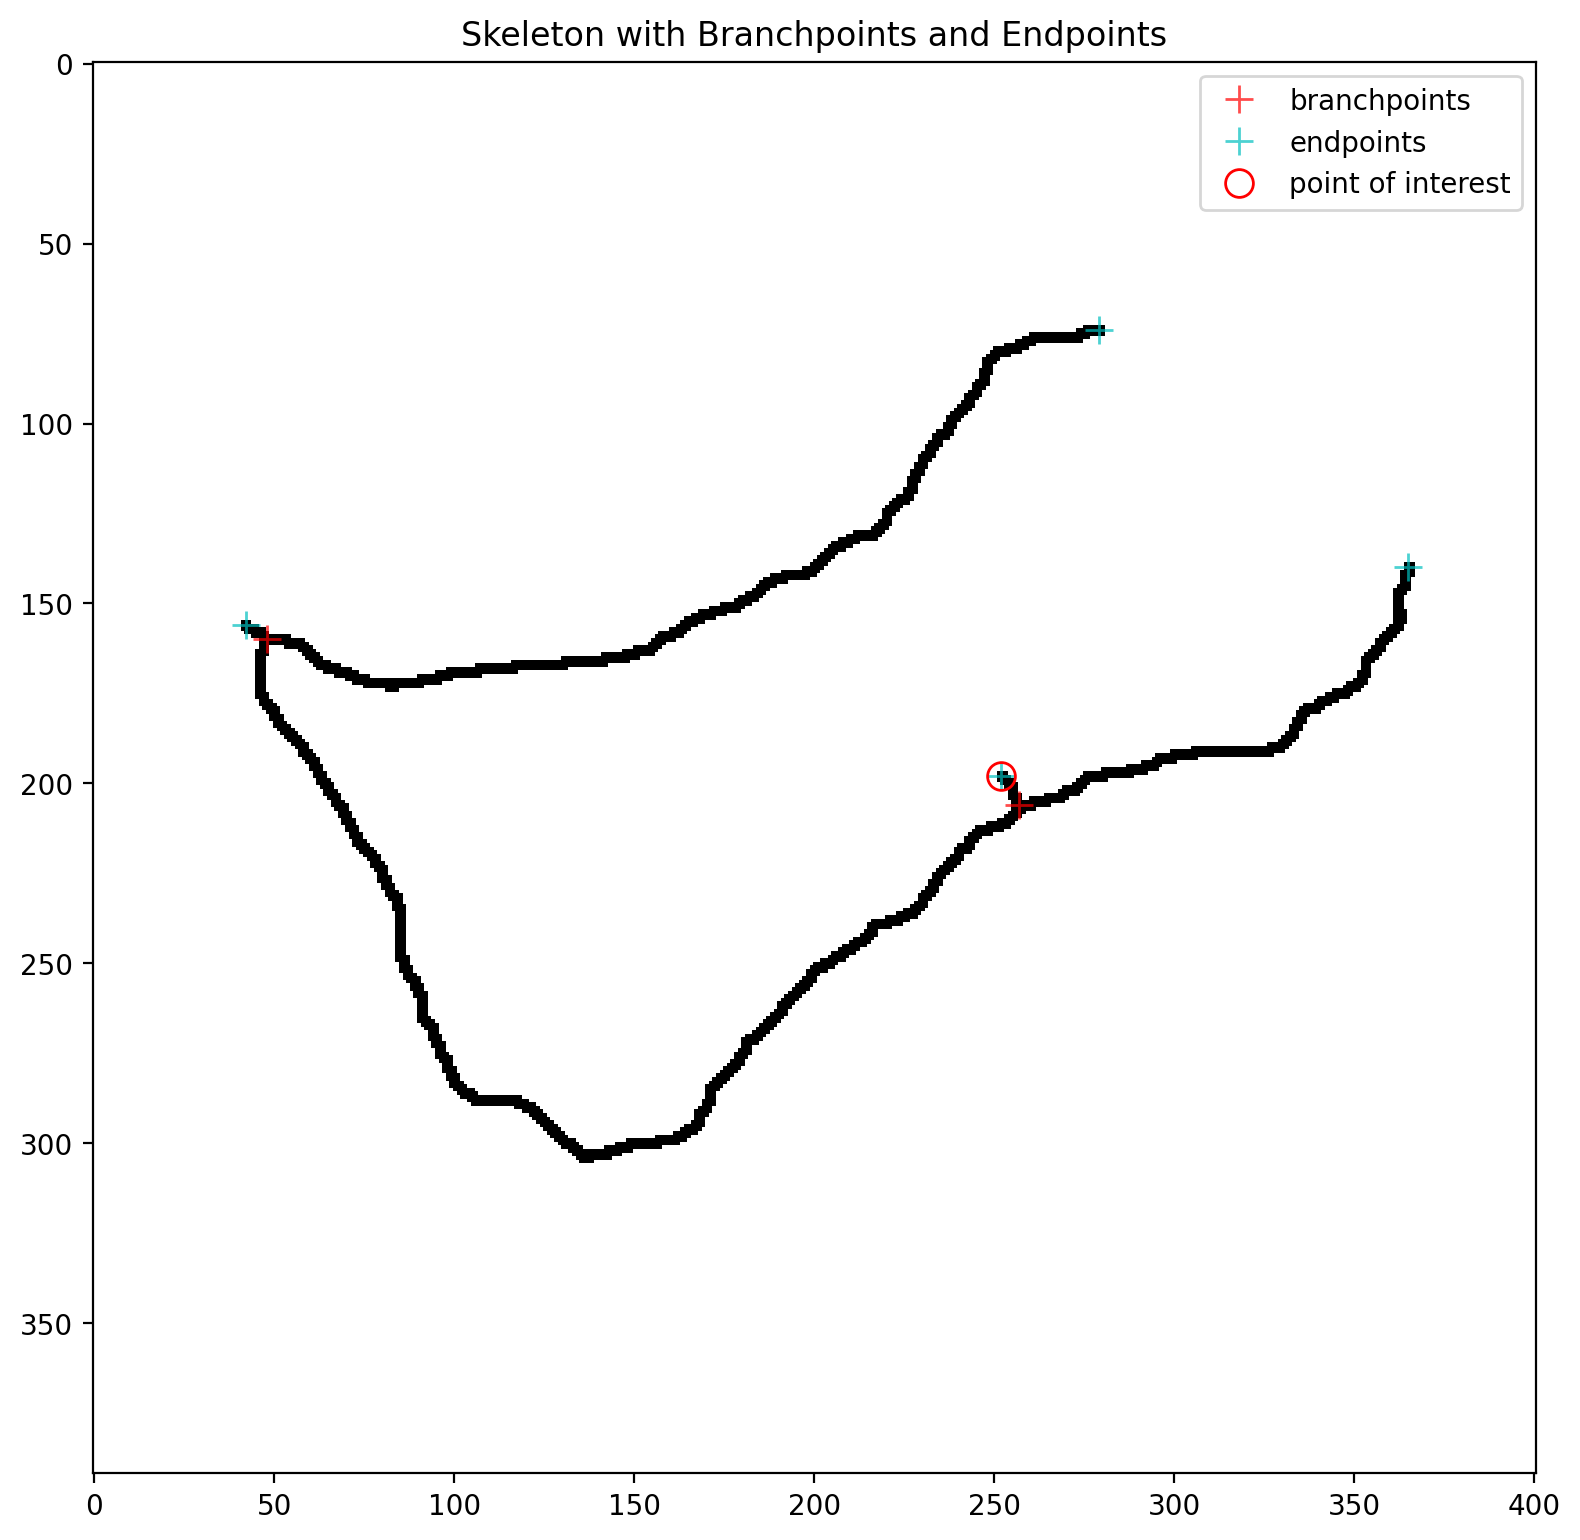

col =  18
while 1/4, Iteration 3: 1 endpoints remaining
order i =  3
col =  0
k =  0
E location y, x =  (206, 257)


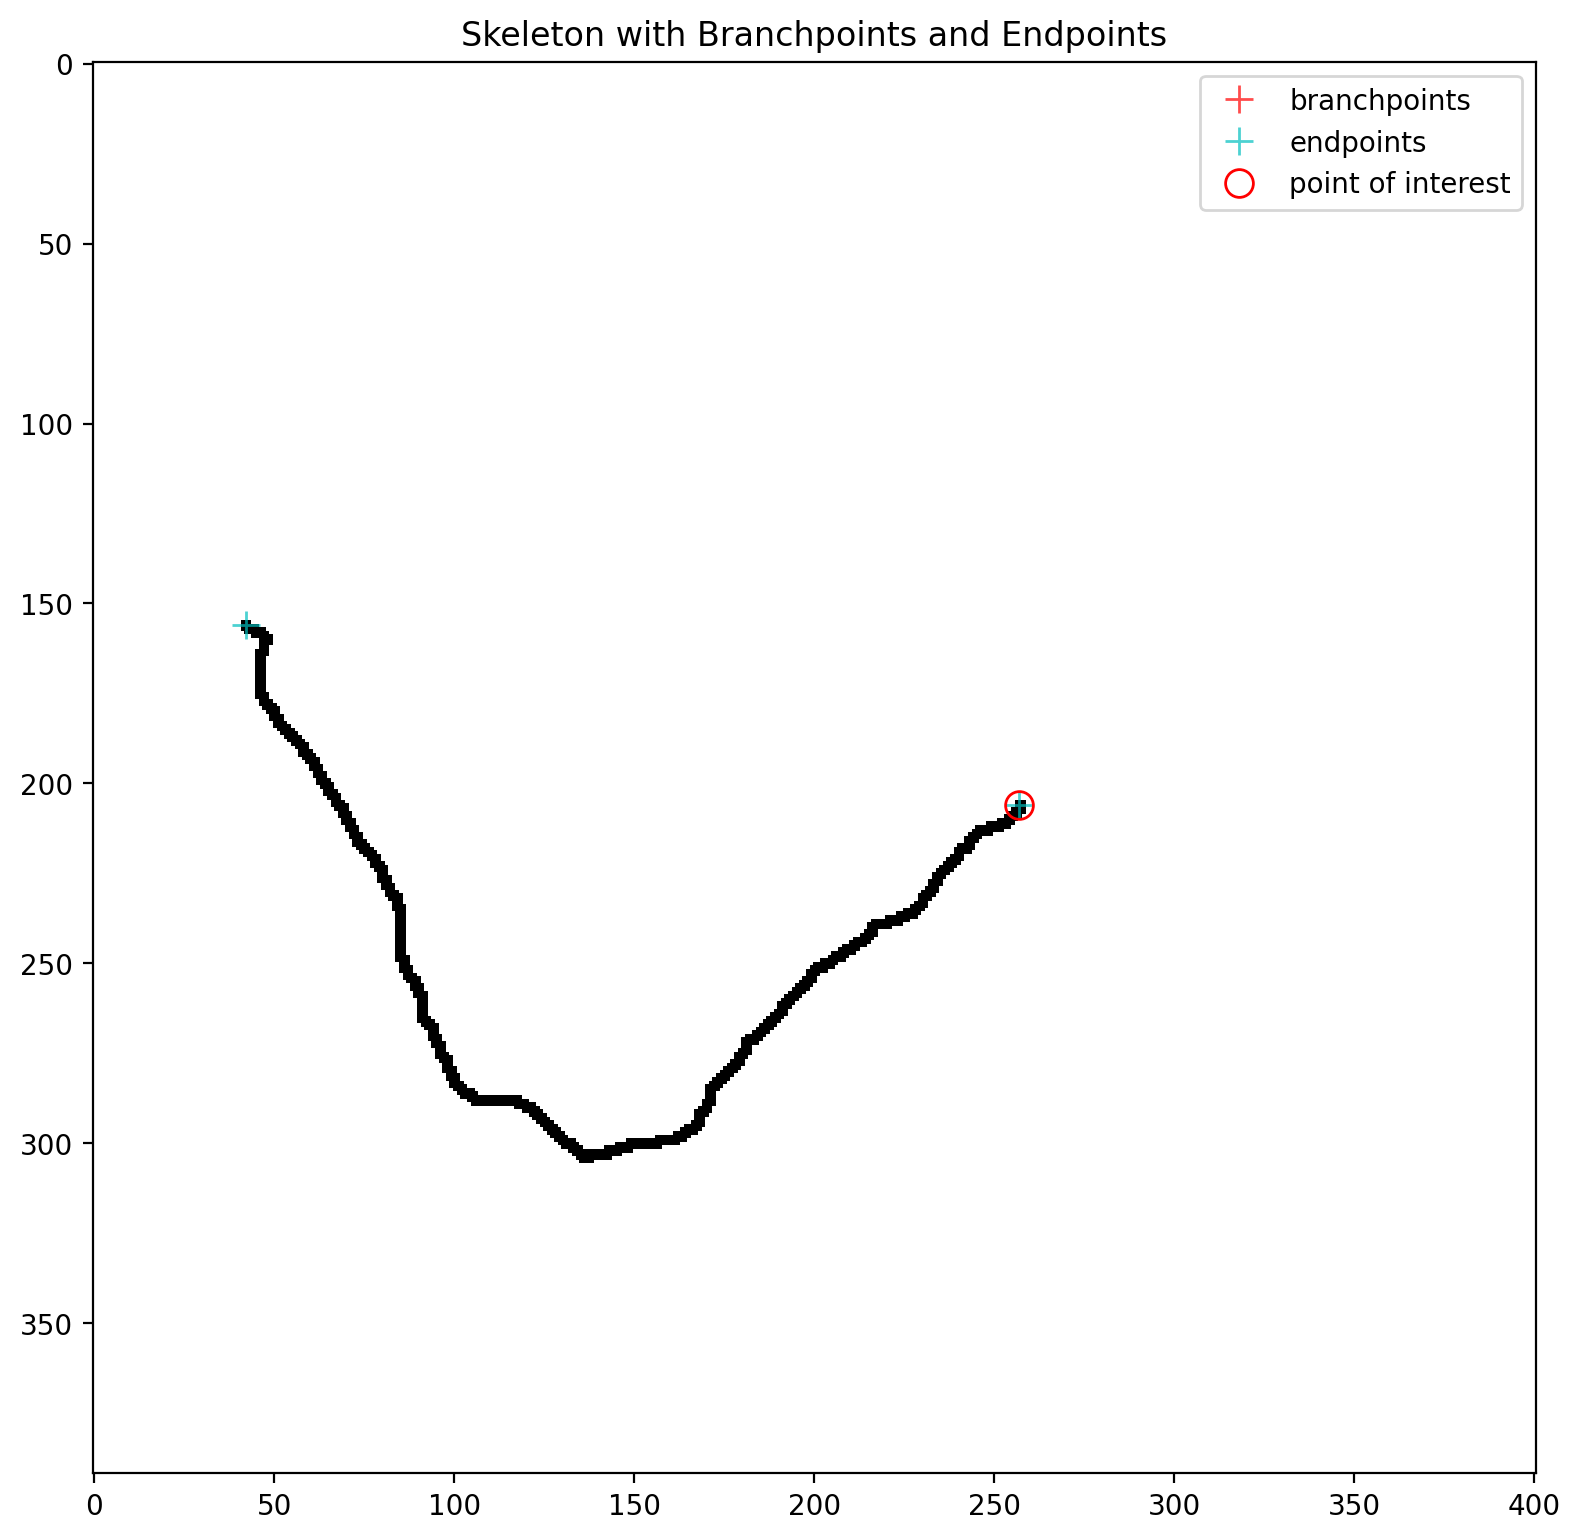

col =  6
Starting while loop 2:
while 2/4, Iteration 1: 1 endpoints remaining
order i =  3
k =  1
k2 =  0
E location y[k2], x[k2] =  (156, 42)


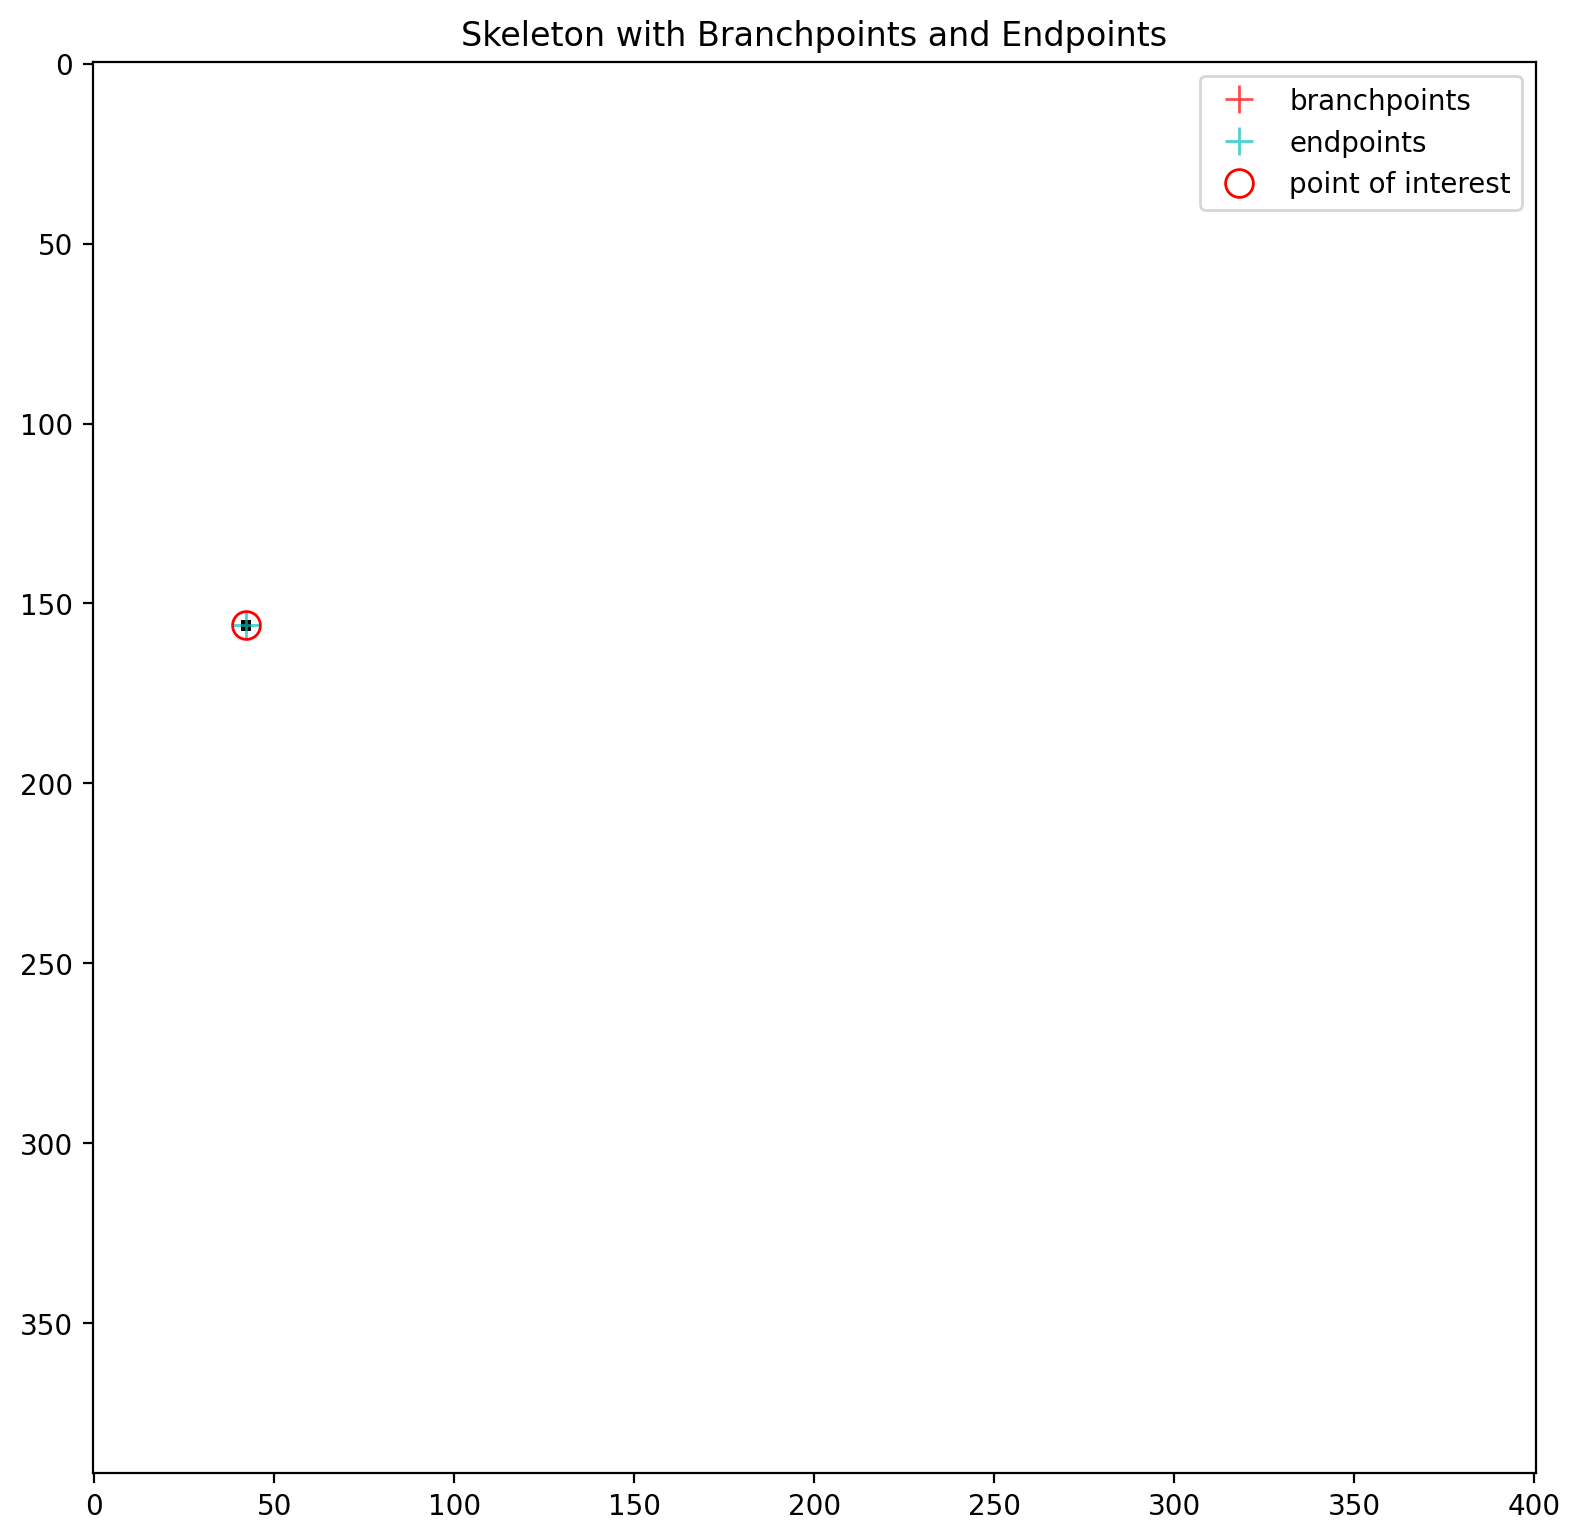

Removed isolated point at y=156, x=42
Starting while loop 3:
Starting while loop 4:


In [18]:
# Section 5 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed line-by-line by Sam Kraus 2024/11/25

# import specific algorithm functions
from Creek_Ordering import figure_creek_skeleton, process_creek_ordering, process_creek_ordering_diagnostic
# from Creek_Ordering import figure_creek_skeleton, process_creek_ordering_diagnostic

# load raw creek mask from Step 4
creekmask = load_creek_mask_h5('creekmask.h5')

# prep data for functions
skeleton = morphology.skeletonize(creekmask)

# execute functions in Creek_Ordering.py
# STRAHLER, STRAIGHTDIST, IDXSEG, IDXBRANCH, idxbreach, xbreach, ybreach, skeleton_breached, creekorder, creekordersing, PTS, ID = process_creek_ordering(ordermax, Z, skeleton, outletdetection, nbbreaches)

# diagnostic version - uncomment and run for debugging:
results_ordering = process_creek_ordering_diagnostic(ordermax, Z, skeleton, outletdetection, nbbreaches)
STRAHLER, STRAIGHTDIST, IDXSEG, IDXBRANCH, idxbreach, xbreach, ybreach, skeleton_breached, creekorder, creekordersing, PTS, ID = results_ordering

In [19]:
IDXSEG

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [279.,  67., 281., ...,   0.,   0.,   0.],
       [173., 152., 201., ..., 202., 254., 202.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

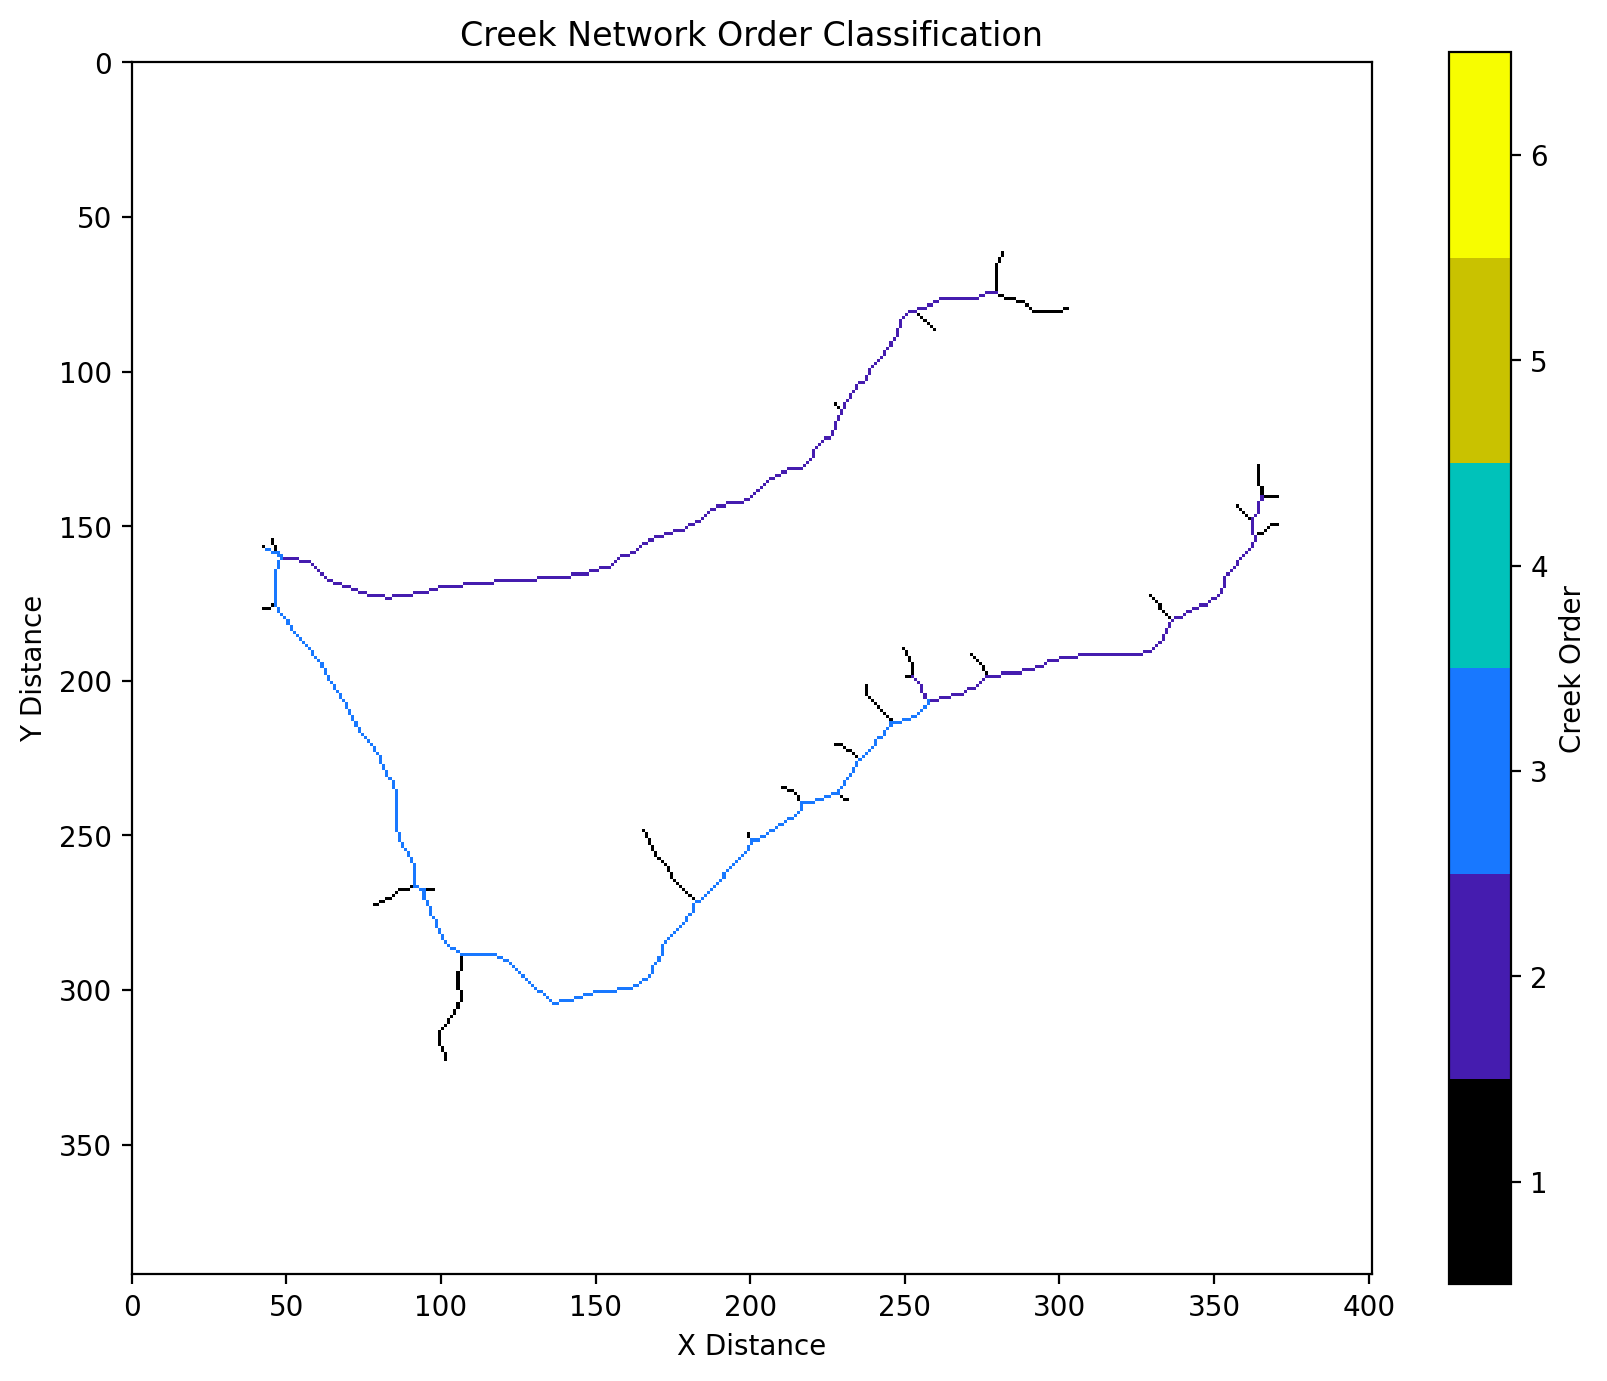

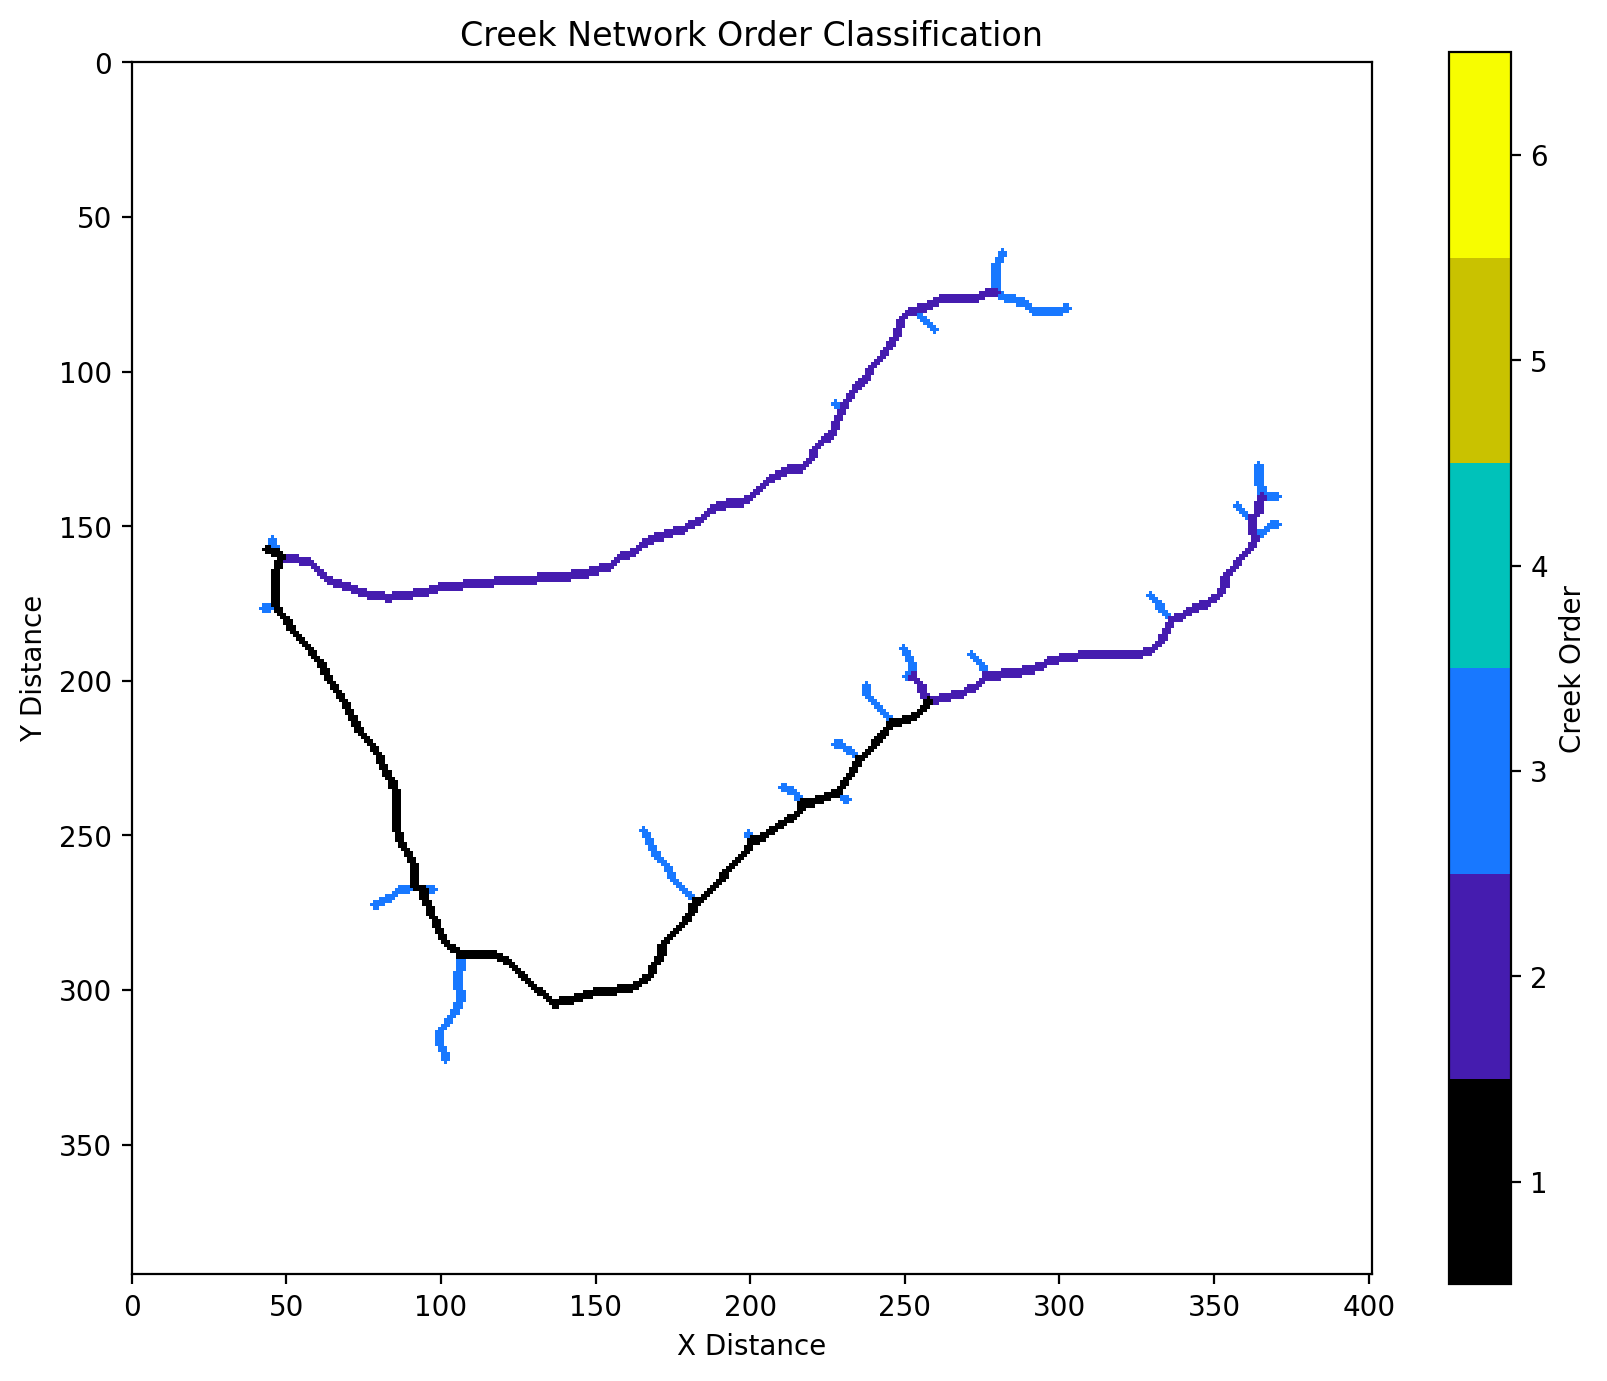

In [25]:
from check_plots_step5 import plot_creek_orders, plot_creek_orders_big

# Plot the sample data for skeleton
fig, ax = plot_creek_orders(skeleton_breached, creekordersing)
plt.show()

# Plot the sample data
fig, ax = plot_creek_orders_big(skeleton_breached, creekorder, ordermax, X=None, Y=None, colors=None, figsize=(10, 8), dpi=100)
plt.show()

In [26]:
# Section 6 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed by Sam Kraus 2024/12/15
from Strahler_Correction_class import CreekNetworkAnalyzer

# Your variables
variables_correction = {
    "skeleton": skeleton_breached,
    "X": X,
    "Y": Y,
    "creek_order": creekorder,
    "creek_order_single": creekordersing,
    "pts": PTS,
    "order_max": ordermax,
    "STRAHLER": STRAHLER,
    "STRAIGHTDIST": STRAIGHTDIST,
    "IDXBRANCH": IDXBRANCH,
    "IDXSEG": IDXSEG
}

# Convert all numpy arrays to lists
variables_correction = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in variables_correction.items()}

# Save to a JSON file
with open("variables_Strahler_Correction.json", "w") as f:
    json.dump(variables_correction, f)

# After running this cell, you need to run in terminal, following these steps: <br>
# 1) If you're on macOS or Linux, make sure that Tkinter (which matplotlib uses for plotting) is properly installed. 
#     On macOS, you can install it via Homebrew using: <br>
#     ```brew install python-tk```
#     NOTE: Homebrew is a package manager for macOS (and Linux)
#       that simplifies the process of installing, updating, and managing software and tools on your system.
# 2) Open terminal (Command Prompt in Windows)
# 3) Change current directory to folder containing creek correction .py files - the "~" is to reference your user local folder
#     (spaces in filepath need to be preceded by a single backslash \ to not break up continuous filepath): <br>
#      ```cd ~/RDE\ Dropbox/Projects/22386.Ashleyville\ Marsh/WORK/CODE/Python/CHIROL_CREEK_EXTRACTION_ALGORITHM```
# 4) Run .py file:  <br>
#     ```python Strahler_Correction_execute.py```
# 5) Plots should appear in python GUI windows - you can adjust plot positioning in this window, and save the figures. 
#       Follow the GUI instructions to correct loops.
# 6) Click the "Finish Correction" button after finishing ALL corrections

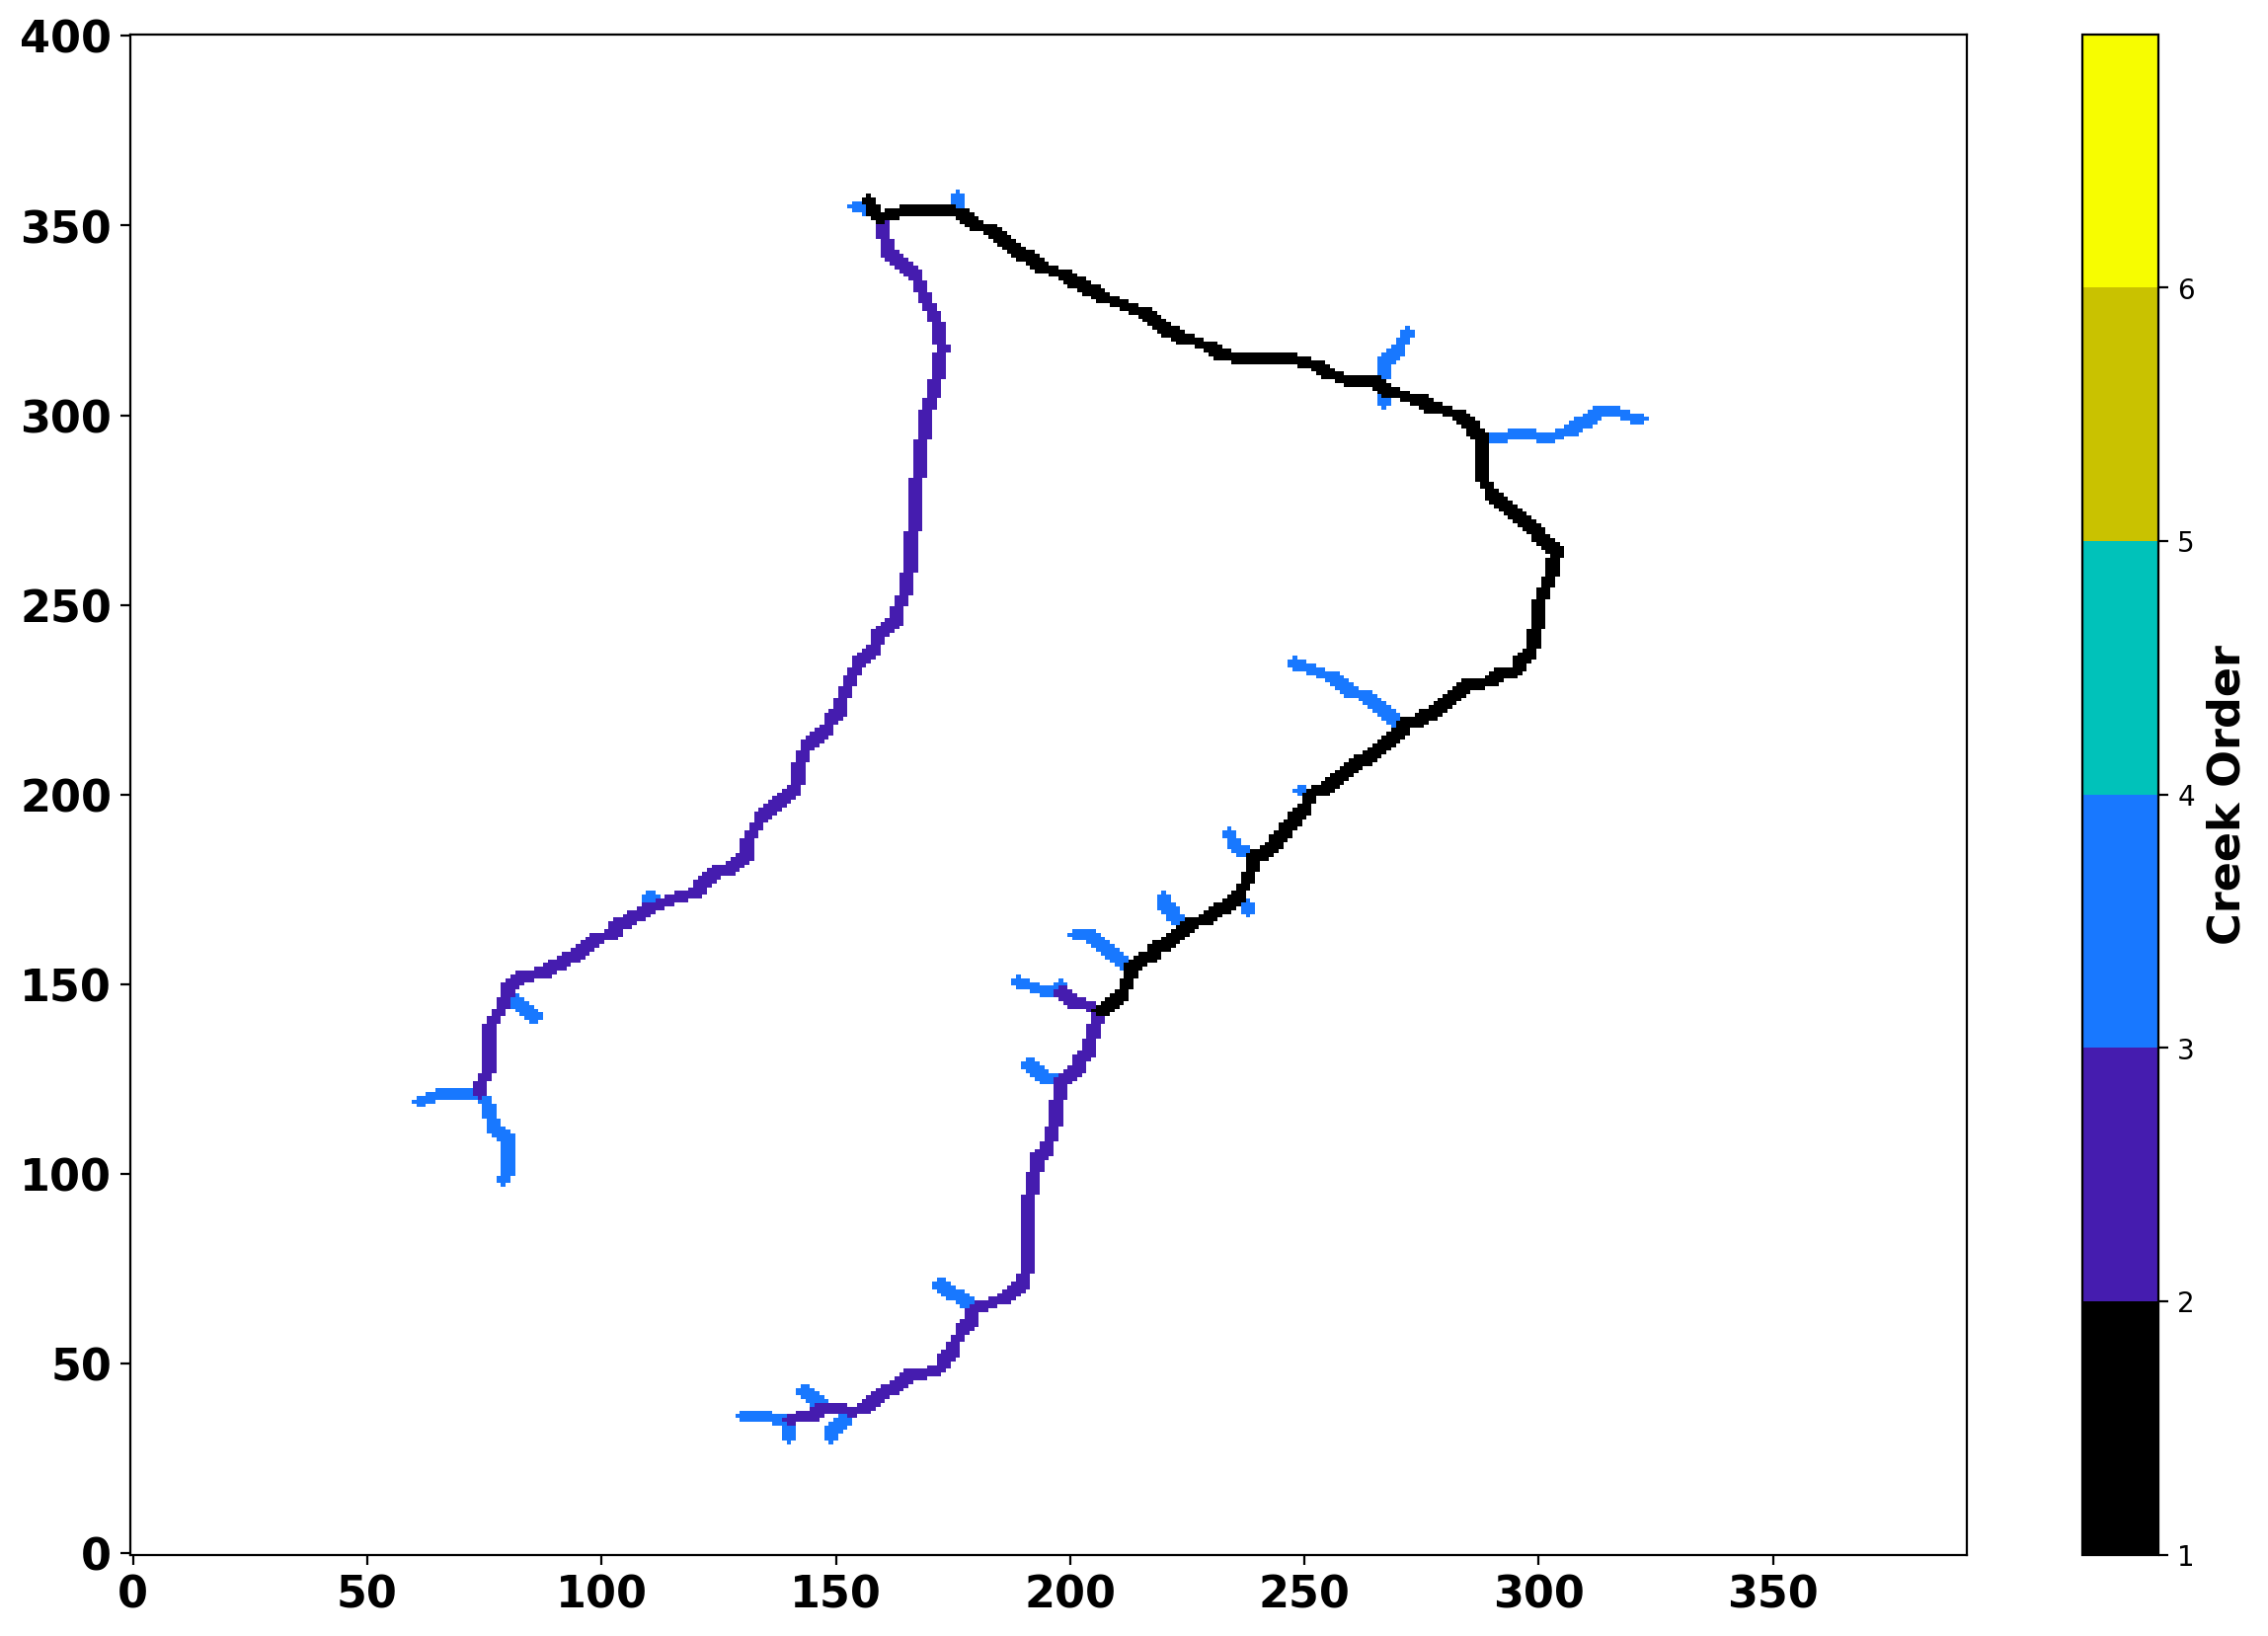

In [27]:
# Section 7 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed by Sam Kraus 12/16/24

# Load the variables from the JSON file
with open("processed_variables_Strahler_Correction.json", "r") as f:
    variables = json.load(f)

skeleton = variables["skeleton"]
X = variables["X"]
Y = variables["Y"]
creek_order = variables["creek_order"]
creek_order_single = variables["creek_order_single"]
creek_order_swapped = variables["creek_order_swapped"]
creek_order_single_swapped = variables["creek_order_single_swapped"]
PTS = variables["PTS"]
order_max = variables["order_max"]
STRAHLER = variables["STRAHLER"]
STRAIGHTDIST = variables["STRAIGHTDIST"]
IDXBRANCH = variables["IDXBRANCH"]
IDXSEG = variables["IDXSEG"]

def convert_to_numpy(data, dtype=None):
    """Safely convert input data to numpy array"""
    try:
        if isinstance(data, list):
            # Handle nested lists by converting inner lists first
            if data and isinstance(data[0], list):
                data = [np.array(row) for row in data]
        return np.array(data, dtype=dtype)
    except Exception as e:
        print(f"Error converting data to numpy array: {e}")
        print("Data sample:", data[:2] if isinstance(data, list) else data)
        raise

# Convert to numpy arrays first
skeleton = convert_to_numpy(skeleton, dtype=bool)
X = convert_to_numpy(X, dtype=float)
Y = convert_to_numpy(Y, dtype=float)
X = X - np.nanmin(X)
Y = Y - np.nanmin(Y)
creek_order = convert_to_numpy(creek_order, dtype=float)
creek_order_single = convert_to_numpy(creek_order, dtype=float)
creek_order_swapped = convert_to_numpy(creek_order_swapped, dtype=float)
creek_order_single_swapped = convert_to_numpy(creek_order_single_swapped, dtype=float)
PTS = convert_to_numpy(PTS, dtype=bool)
order_max = int(order_max)
STRAHLER = convert_to_numpy(STRAHLER, dtype=float)
STRAIGHTDIST = convert_to_numpy(STRAIGHTDIST, dtype=float)
IDXBRANCH = convert_to_numpy(IDXBRANCH, dtype=float)
IDXSEG = convert_to_numpy(IDXSEG, dtype=float)

# Step 7 function
def process_creek_orders(STRAHLER, STRAIGHTDIST, Z, X, Y, creek_order, ID, name):
    # Calculate sinuosity
    SINUOSITY = np.divide(STRAHLER, STRAIGHTDIST, where=(STRAIGHTDIST!=0))
    
    # Remove rows and columns of zeros
    # Find indices where rows/columns are not all zeros
    rows_to_keep = np.any(STRAHLER, axis=1)
    cols_to_keep = np.any(STRAHLER, axis=0)
    
    # Filter arrays
    SINUOSITY = SINUOSITY[rows_to_keep][:, cols_to_keep]
    STRAIGHTDIST = STRAIGHTDIST[rows_to_keep][:, cols_to_keep]
    STRAHLER = STRAHLER[rows_to_keep][:, cols_to_keep]
    
    # Get number of segments (count non-zero elements in each row)
    SEGMENTS = np.sum(STRAHLER != 0, axis=1)
    
    # Create SINUOUSLENGTH with same shape as STRAHLER
    SINUOUSLENGTH = STRAHLER.copy()
    
    # Reverse ID array
    ID = np.flip(ID)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Create contour mask
    contourmask = ~np.isnan(Z)
    # Fill holes
    contourmask = ndimage.binary_fill_holes(contourmask)
    
    # Morphological operations
    contourmask = morphology.binary_closing(contourmask)
    contourmask = morphology.thin(contourmask)  # equivalent to 'remove' in MATLAB
    # Note: 'diag' operation doesn't have direct equivalent in skimage
    contourmask = morphology.dilation(contourmask)  # equivalent to 'thicken'
    
    # Create discrete colormap: black + 5 colors
    colors = ['#000000', '#451caf', '#1878ff', '#00c2ba', '#c9c200', '#f7fd00']
    discrete_cmap = ListedColormap(colors)
    
    # Plot pcolor equivalent
    plt.pcolormesh(X, Y, creek_order, shading='auto', cmap=discrete_cmap)
    plt.clim(1, 7)
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Creek Order', fontsize=16, fontweight='bold')
    cbar.set_ticks([1, 2, 3, 4, 5, 6])
    
    # Set font properties
    plt.gca().tick_params(labelsize=16)
    for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
        label.set_fontweight('bold')
    
    # Save creek mask to HDF5 format
    output_filename = f'OUTPUTS/{shortname}_creekorder.h5'
    with h5py.File(output_filename, 'w') as f:
        # Create a dataset in the HDF5 file
        f.create_dataset('creek_order', data=creek_order, compression='gzip', compression_opts=9)
        
        # Add metadata if needed
        f.attrs['creation_date'] = str(np.datetime64('now'))
        f.attrs['description'] = 'Creek order analysis results'
    
    return SINUOSITY, STRAIGHTDIST, STRAHLER, SEGMENTS, SINUOUSLENGTH

SINUOSITY, STRAIGHTDIST, STRAHLER, SEGMENTS, SINUOUSLENGTH = process_creek_orders(STRAHLER, STRAIGHTDIST, Z, X, Y, creek_order_swapped, ID, name)

In [28]:
# Section 8 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed by Sam Kraus 12/16/24

from Process_CrossSections import process_xsects

WIDTH, DEPTH, AREA = process_xsects(creekmask, creek, IDXSEG, ordermax, figview=False)

order =  0
seg =  0
IDXSEG[order, seg] =  0.0
skipped bc no segment
order =  1
seg =  0
order =  2
seg =  0


In [29]:
# Section 9 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed by Sam Kraus 12/16/24

from Process_JunctionAngles import process_junction_angles

ANGLEORDER = process_junction_angles(skeleton, creekmask, IDXBRANCH, SINUOUSLENGTH, SEGMENTS, fig_view=False)

In [32]:
IDXSEG

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [104., 306., 111., 307.,  97., 301.],
       [255., 202., 256., 202., 254., 202.],
       ...,
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]])

In [31]:
# Section 10 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed by Sam Kraus 12/17/24

# Step 10 function:
# Create and save result tables
def process_creek_morphometry(ANGLEORDER, ID, SEGMENTS, SINUOUSLENGTH, SINUOSITY, WIDTH, 
                            DEPTH, AREA, STRAIGHTDIST, shortname, Cth, LZth, HZth, 
                            Ctharea, LZtharea, HZtharea):
    # Process ANGLEORDER
    A2 = ANGLEORDER.copy()
    A2[ANGLEORDER == 0] = np.nan
    
    if A2.shape[0] < len(ID):
        nanrow = np.full((1, A2.shape[1]), np.nan)
        A2 = np.vstack([A2, nanrow])
        ANGLEORDER = np.vstack([ANGLEORDER, nanrow])
    
    # Calculate mean column (excluding NaN values)
    meancol = np.nanmean(A2, axis=1, keepdims=True)
    ANGLEORDER = np.hstack([ANGLEORDER, meancol])
    
    # Replace zeros with NaN for various measurements
    for arr in [AREA, SINUOUSLENGTH, STRAIGHTDIST, WIDTH, DEPTH]:
        arr[arr <= 0] = np.nan
    
    # Create summary table
    summary_data = np.column_stack([
        ID,
        SEGMENTS,
        np.nansum(SINUOUSLENGTH, axis=1),
        np.nanmean(SINUOUSLENGTH, axis=1),
        np.nanmean(SINUOSITY, axis=1),
        np.nanmean(WIDTH, axis=1),
        np.nanmean(DEPTH, axis=1),
        np.nanmean(AREA, axis=1),
        np.nansum(STRAIGHTDIST, axis=1),
        np.nanmean(STRAIGHTDIST, axis=1)
    ])
    
    summary_columns = [
        'RS order', '# segments', 'Total sinuous length', 'Mean sinuous length',
        'Mean sinuosity', 'Mean channel width', 'Mean channel depth',
        'Mean cross-sectional area', 'Total channel length', 'Mean channel length'
    ]
    
    # Create DataFrame for summary table
    summary_df = pd.DataFrame(summary_data, columns=summary_columns)
    
    # Create detailed measurement tables
    sinuous_length = np.column_stack([
        ID,
        SEGMENTS,
        np.nansum(SINUOUSLENGTH, axis=1, keepdims=True),
        np.nanmean(SINUOUSLENGTH, axis=1, keepdims=True),
        SINUOUSLENGTH
    ])
    
    straight_dist = np.column_stack([
        ID,
        SEGMENTS,
        np.nansum(STRAIGHTDIST, axis=1, keepdims=True),
        np.nanmean(STRAIGHTDIST, axis=1, keepdims=True),
        STRAIGHTDIST
    ])
    
    sinuosity = np.column_stack([
        ID,
        SEGMENTS,
        np.nanmean(SINUOSITY, axis=1, keepdims=True),
        SINUOSITY
    ])
    
    depth = np.column_stack([DEPTH, np.nanmean(DEPTH, axis=1, keepdims=True)])
    width = np.column_stack([WIDTH, np.nanmean(WIDTH, axis=1, keepdims=True)])
    area = np.column_stack([AREA, np.nanmean(AREA, axis=1, keepdims=True)])
    
    # Create and display summary table
    plt.figure(figsize=(13, 2))
    plt.axis('tight')
    plt.axis('off')
    table = plt.table(cellText=summary_df.values,
                     colLabels=summary_df.columns,
                     cellLoc='center',
                     loc='center')
    
    # Save summary table to Excel
    output_path = f'OUTPUTS/{shortname}_CreekMorphometry.xlsx'
    summary_df.to_excel(output_path, index=False)
    
    # Create and display thresholds table
    thresh_data = np.array([
        [Cth, LZth, HZth],
        [Ctharea, LZtharea, HZtharea]
    ])
    
    thresh_columns = ['Slope threshold Sth', 
                     'Low elevation threshold LZth', 
                     'High elevation threshold HZth']
    thresh_index = ['Value', 'Area']
    
    thresh_df = pd.DataFrame(thresh_data, 
                           columns=thresh_columns,
                           index=thresh_index)
    
    plt.figure(figsize=(8, 1.5))
    plt.axis('tight')
    plt.axis('off')
    thresh_table = plt.table(cellText=thresh_df.values,
                           colLabels=thresh_df.columns,
                           rowLabels=thresh_df.index,
                           cellLoc='center',
                           loc='center')
    
    plt.show()
    
    return summary_df, thresh_df, sinuous_length, straight_dist, sinuosity, depth, width, area

# Execute Step 10
summary_df, thresh_df, sinuous_length, straight_dist, sinuosity, depth, width, area = process_creek_morphometry(ANGLEORDER, ID, SEGMENTS, SINUOUSLENGTH, 
                                 SINUOSITY, WIDTH, DEPTH, AREA, STRAIGHTDIST, 
                                 shortname, Cth, LZth, HZth, Ctharea, LZtharea, HZtharea)

IndexError: tuple index out of range